In [20]:
import tensorflow as tf
import tensorflow_addons
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from  tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding


data_path = os.getcwd().replace('\\', '/')+'/Data Preprocess/'


emoji_dict = {"0": ":heart:",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}


# reading the data :
df_train = pd.read_csv(data_path+'data/train.csv')
df_test = pd.read_csv(data_path+'data/test.csv')



In [71]:
total = len(df_train) + len(df_test)

print("pourcentage train ", len(df_train)*100/total)
print("pourcentage test ", len(df_test)*100/total)





pourcentage train  70.2127659574468
pourcentage test  29.78723404255319


In [2]:
def plot_hist(hist):
    
    for metric in hist.history.keys():
        if metric.startswith('val'):
            break
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+metric])
        plt.title('model '+metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show() 
        

In [3]:
# dividing data ;
train_x = df_train['0']
train_y = df_train['1']
test_x = df_test['0']
test_y = df_test['1']


In [5]:
# create vocabulary index 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000,
                               output_sequence_length=25)
text_ds = tf.data.Dataset.from_tensor_slices(train_x).batch(128)
vectorizer.adapt(text_ds)


In [6]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'i', 'you', 'is']

In [7]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([ 5,  1,  1, 39,  5,  1], dtype=int64)

In [8]:
# maping dict to words and its index 
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [9]:
# Getting the Glove model 
path_to_glove_file = data_path+'/glove/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [10]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 260 words (2 misses)


In [21]:
# creating the embedding layer 

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer= Constant(embedding_matrix),
    trainable=False,
)

In [22]:

train_x = vectorizer(np.array([[s] for s in train_x])).numpy()
test_x = vectorizer(np.array([[s] for s in test_x])).numpy()

In [23]:
train_y = tf.keras.utils.to_categorical(df_train['1'])
test_y = tf.keras.utils.to_categorical(df_test['1'])

In [72]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.Conv1D(128, 5, activation="relu",
                           padding="same")(embedded_sequences)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 128)         64128     
_________________________________________________________________
average_pooling1d_6 (Average (None, None, 128)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_7 (Average (None, None, 128)         0  

In [73]:

model.compile(tf.keras.optimizers.Adam(learning_rate=3e-3),
              "categorical_crossentropy", metrics=['acc'])


In [74]:
hist = model.fit(train_x, train_y, verbose=2, epochs=50, batch_size=128,
                 validation_split=0.1)



Epoch 1/50


1/1 - 3s - loss: 1.6092 - acc: 0.2288 - val_loss: 1.6157 - val_acc: 0.0714


Epoch 2/50
1/1 - 0s - loss: 1.5932 - acc: 0.3136 - val_loss: 1.6298 - val_acc: 0.0714


Epoch 3/50
1/1 - 0s - loss: 1.5751 - acc: 0.3051 - val_loss: 1.6600 - val_acc: 0.0714


Epoch 4/50


1/1 - 0s - loss: 1.5523 - acc: 0.3051 - val_loss: 1.7164 - val_acc: 0.0714


Epoch 5/50


1/1 - 0s - loss: 1.5693 - acc: 0.2458 - val_loss: 1.7378 - val_acc: 0.0714


Epoch 6/50


1/1 - 0s - loss: 1.5298 - acc: 0.3051 - val_loss: 1.7247 - val_acc: 0.1429


Epoch 7/50


1/1 - 0s - loss: 1.5191 - acc: 0.3136 - val_loss: 1.7026 - val_acc: 0.1429


Epoch 8/50


1/1 - 0s - loss: 1.5176 - acc: 0.3051 - val_loss: 1.6810 - val_acc: 0.1429


Epoch 9/50


1/1 - 0s - loss: 1.5239 - acc: 0.3136 - val_loss: 1.6631 - val_acc: 0.0714


Epoch 10/50


1/1 - 0s - loss: 1.4941 - acc: 0.3136 - val_loss: 1.6538 - val_acc: 0.0714


Epoch 11/50


1/1 - 0s - loss: 1.4834 - acc: 0.3390 - val_loss: 1.6499 - val_acc: 0.0714


Epoch 12/50


1/1 - 0s - loss: 1.4501 - acc: 0.3390 - val_loss: 1.6496 - val_acc: 0.0714


Epoch 13/50


1/1 - 0s - loss: 1.4436 - acc: 0.3983 - val_loss: 1.6518 - val_acc: 0.1429


Epoch 14/50


1/1 - 0s - loss: 1.4053 - acc: 0.3729 - val_loss: 1.6340 - val_acc: 0.2143


Epoch 15/50


1/1 - 0s - loss: 1.3790 - acc: 0.4661 - val_loss: 1.5929 - val_acc: 0.2143


Epoch 16/50


1/1 - 0s - loss: 1.3185 - acc: 0.4407 - val_loss: 1.5760 - val_acc: 0.2143


Epoch 17/50


1/1 - 0s - loss: 1.2731 - acc: 0.4576 - val_loss: 1.5791 - val_acc: 0.2143


Epoch 18/50


1/1 - 0s - loss: 1.2634 - acc: 0.4407 - val_loss: 1.5296 - val_acc: 0.2857


Epoch 19/50


1/1 - 0s - loss: 1.2175 - acc: 0.4746 - val_loss: 1.4913 - val_acc: 0.2857


Epoch 20/50


1/1 - 0s - loss: 1.1257 - acc: 0.5085 - val_loss: 1.4955 - val_acc: 0.2857


Epoch 21/50


1/1 - 0s - loss: 1.0838 - acc: 0.5254 - val_loss: 1.4677 - val_acc: 0.2857


Epoch 22/50


1/1 - 0s - loss: 1.0744 - acc: 0.5254 - val_loss: 1.4246 - val_acc: 0.2857


Epoch 23/50


1/1 - 0s - loss: 1.0677 - acc: 0.5932 - val_loss: 1.4817 - val_acc: 0.3571


Epoch 24/50


1/1 - 0s - loss: 1.0222 - acc: 0.6102 - val_loss: 1.4144 - val_acc: 0.4286


Epoch 25/50


1/1 - 0s - loss: 0.9378 - acc: 0.6610 - val_loss: 1.3550 - val_acc: 0.4286


Epoch 26/50


1/1 - 0s - loss: 0.9012 - acc: 0.6610 - val_loss: 1.3240 - val_acc: 0.5000


Epoch 27/50


1/1 - 0s - loss: 0.8448 - acc: 0.6780 - val_loss: 1.3468 - val_acc: 0.5000


Epoch 28/50


1/1 - 0s - loss: 0.7514 - acc: 0.7373 - val_loss: 1.3676 - val_acc: 0.4286


Epoch 29/50


1/1 - 0s - loss: 0.6774 - acc: 0.7373 - val_loss: 1.3059 - val_acc: 0.5000


Epoch 30/50


1/1 - 0s - loss: 0.6881 - acc: 0.7627 - val_loss: 1.2308 - val_acc: 0.5714


Epoch 31/50


1/1 - 0s - loss: 0.6110 - acc: 0.7712 - val_loss: 1.1336 - val_acc: 0.6429


Epoch 32/50


1/1 - 0s - loss: 0.5748 - acc: 0.7542 - val_loss: 1.1028 - val_acc: 0.5714


Epoch 33/50


1/1 - 0s - loss: 0.5187 - acc: 0.7712 - val_loss: 1.1376 - val_acc: 0.6429


Epoch 34/50


1/1 - 0s - loss: 0.4452 - acc: 0.8220 - val_loss: 1.2222 - val_acc: 0.6429


Epoch 35/50


1/1 - 0s - loss: 0.4391 - acc: 0.8559 - val_loss: 1.2570 - val_acc: 0.7143


Epoch 36/50


1/1 - 0s - loss: 0.3727 - acc: 0.8559 - val_loss: 1.1586 - val_acc: 0.7143


Epoch 37/50


1/1 - 0s - loss: 0.3496 - acc: 0.8898 - val_loss: 1.1585 - val_acc: 0.7143


Epoch 38/50


1/1 - 0s - loss: 0.3578 - acc: 0.9068 - val_loss: 1.1128 - val_acc: 0.7143


Epoch 39/50


1/1 - 0s - loss: 0.3041 - acc: 0.9068 - val_loss: 1.0113 - val_acc: 0.7143


Epoch 40/50


1/1 - 0s - loss: 0.1969 - acc: 0.9492 - val_loss: 1.0065 - val_acc: 0.7143


Epoch 41/50


1/1 - 0s - loss: 0.2178 - acc: 0.9407 - val_loss: 1.1104 - val_acc: 0.7143


Epoch 42/50


1/1 - 0s - loss: 0.2096 - acc: 0.9322 - val_loss: 1.2960 - val_acc: 0.7143


Epoch 43/50


1/1 - 0s - loss: 0.1608 - acc: 0.9237 - val_loss: 1.4866 - val_acc: 0.7143


Epoch 44/50


1/1 - 0s - loss: 0.2679 - acc: 0.9322 - val_loss: 1.5977 - val_acc: 0.7143


Epoch 45/50


1/1 - 0s - loss: 0.1869 - acc: 0.9407 - val_loss: 1.6528 - val_acc: 0.7143


Epoch 46/50


1/1 - 0s - loss: 0.1832 - acc: 0.9407 - val_loss: 1.6340 - val_acc: 0.7143


Epoch 47/50


1/1 - 0s - loss: 0.1758 - acc: 0.9492 - val_loss: 1.5391 - val_acc: 0.7143


Epoch 48/50


1/1 - 0s - loss: 0.0845 - acc: 0.9492 - val_loss: 1.3879 - val_acc: 0.7143


Epoch 49/50


1/1 - 0s - loss: 0.1116 - acc: 0.9661 - val_loss: 1.3134 - val_acc: 0.7143


Epoch 50/50


1/1 - 0s - loss: 0.1544 - acc: 0.9322 - val_loss: 1.3440 - val_acc: 0.7143


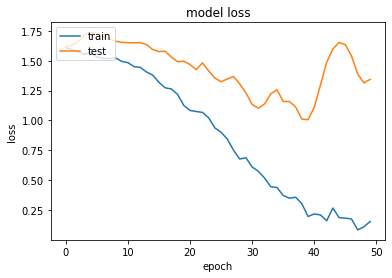

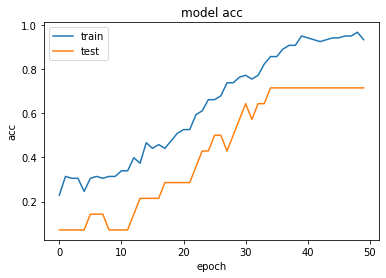

In [75]:
plot_hist(hist)

In [76]:
model.evaluate(test_x, test_y)

1/2 [==============>...............] - ETA: 0s - loss: 1.3335 - acc: 0.6250

2/2 [==============================] - 0s 12ms/step - loss: 1.6174 - acc: 0.6429


[1.6173592805862427, 0.6428571343421936]

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
conv1d_39 (Conv1D)           (None, None, 256)         128256    
_________________________________________________________________
average_pooling1d_12 (Averag (None, None, 256)         0         
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
dropout_33 (Dropout)         (None, None, 256)         0  

1/1 - 4s - loss: 1.6140 - acc: 0.2095 - val_loss: 1.6122 - val_acc: 0.1852


Epoch 2/50
1/1 - 0s - loss: 1.5960 - acc: 0.3333 - val_loss: 1.6139 - val_acc: 0.1852


Epoch 3/50
1/1 - 0s - loss: 1.5880 - acc: 0.3143 - val_loss: 1.6180 - val_acc: 0.1852


Epoch 4/50
1/1 - 0s - loss: 1.5756 - acc: 0.3429 - val_loss: 1.6267 - val_acc: 0.1852


Epoch 5/50
1/1 - 0s - loss: 1.5564 - acc: 0.3810 - val_loss: 1.6432 - val_acc: 0.1852


Epoch 6/50
1/1 - 0s - loss: 1.5376 - acc: 0.3238 - val_loss: 1.6695 - val_acc: 0.1852


Epoch 7/50
1/1 - 0s - loss: 1.5323 - acc: 0.3238 - val_loss: 1.7003 - val_acc: 0.1852


Epoch 8/50
1/1 - 0s - loss: 1.5109 - acc: 0.3619 - val_loss: 1.7307 - val_acc: 0.2222


Epoch 9/50
1/1 - 0s - loss: 1.5191 - acc: 0.3048 - val_loss: 1.7476 - val_acc: 0.2222


Epoch 10/50


1/1 - 0s - loss: 1.4905 - acc: 0.3429 - val_loss: 1.7495 - val_acc: 0.2593


Epoch 11/50


1/1 - 0s - loss: 1.4697 - acc: 0.3905 - val_loss: 1.7337 - val_acc: 0.2593


Epoch 12/50


1/1 - 0s - loss: 1.4773 - acc: 0.3524 - val_loss: 1.7002 - val_acc: 0.2222


Epoch 13/50


1/1 - 0s - loss: 1.4020 - acc: 0.4190 - val_loss: 1.6615 - val_acc: 0.2222


Epoch 14/50
1/1 - 0s - loss: 1.3921 - acc: 0.3619 - val_loss: 1.6167 - val_acc: 0.2222


Epoch 15/50
1/1 - 0s - loss: 1.3847 - acc: 0.4286 - val_loss: 1.5717 - val_acc: 0.2222


Epoch 16/50


1/1 - 0s - loss: 1.3316 - acc: 0.4571 - val_loss: 1.5302 - val_acc: 0.2222


Epoch 17/50


1/1 - 0s - loss: 1.2914 - acc: 0.4667 - val_loss: 1.4905 - val_acc: 0.2222


Epoch 18/50
1/1 - 0s - loss: 1.2384 - acc: 0.4857 - val_loss: 1.4555 - val_acc: 0.2593


Epoch 19/50
1/1 - 0s - loss: 1.1963 - acc: 0.5429 - val_loss: 1.4426 - val_acc: 0.2593


Epoch 20/50
1/1 - 0s - loss: 1.0843 - acc: 0.6000 - val_loss: 1.4423 - val_acc: 0.2963


Epoch 21/50


1/1 - 0s - loss: 1.0341 - acc: 0.6095 - val_loss: 1.4237 - val_acc: 0.4074


Epoch 22/50


1/1 - 0s - loss: 0.9858 - acc: 0.6381 - val_loss: 1.3903 - val_acc: 0.3704


Epoch 23/50


1/1 - 0s - loss: 0.9090 - acc: 0.6571 - val_loss: 1.3845 - val_acc: 0.4074


Epoch 24/50


1/1 - 0s - loss: 0.9057 - acc: 0.6857 - val_loss: 1.3431 - val_acc: 0.4815


Epoch 25/50


1/1 - 0s - loss: 0.8305 - acc: 0.6762 - val_loss: 1.3001 - val_acc: 0.4815


Epoch 26/50


1/1 - 0s - loss: 0.8775 - acc: 0.6476 - val_loss: 1.2356 - val_acc: 0.4815


Epoch 27/50


1/1 - 0s - loss: 0.7028 - acc: 0.7333 - val_loss: 1.2363 - val_acc: 0.4815


Epoch 28/50


1/1 - 0s - loss: 0.6992 - acc: 0.7714 - val_loss: 1.1558 - val_acc: 0.5926


Epoch 29/50


1/1 - 0s - loss: 0.7200 - acc: 0.7143 - val_loss: 1.2099 - val_acc: 0.5185


Epoch 30/50


1/1 - 0s - loss: 0.6404 - acc: 0.8190 - val_loss: 1.2995 - val_acc: 0.5185


Epoch 31/50


1/1 - 0s - loss: 0.6542 - acc: 0.7619 - val_loss: 1.2784 - val_acc: 0.5926


Epoch 32/50
1/1 - 0s - loss: 0.5444 - acc: 0.8095 - val_loss: 1.2275 - val_acc: 0.6296


Epoch 33/50


1/1 - 0s - loss: 0.6103 - acc: 0.7619 - val_loss: 1.1534 - val_acc: 0.7037


Epoch 34/50


1/1 - 0s - loss: 0.5173 - acc: 0.8095 - val_loss: 1.1408 - val_acc: 0.7037


Epoch 35/50


1/1 - 0s - loss: 0.4224 - acc: 0.8762 - val_loss: 1.0563 - val_acc: 0.7407


Epoch 36/50
1/1 - 0s - loss: 0.4544 - acc: 0.8286 - val_loss: 1.0650 - val_acc: 0.7037


Epoch 37/50
1/1 - 0s - loss: 0.3911 - acc: 0.8762 - val_loss: 1.0971 - val_acc: 0.6667


Epoch 38/50
1/1 - 0s - loss: 0.4040 - acc: 0.8762 - val_loss: 1.0066 - val_acc: 0.7037


Epoch 39/50
1/1 - 0s - loss: 0.3437 - acc: 0.9048 - val_loss: 1.0658 - val_acc: 0.7037


Epoch 40/50


1/1 - 0s - loss: 0.3021 - acc: 0.8952 - val_loss: 1.3026 - val_acc: 0.7037


Epoch 41/50


1/1 - 0s - loss: 0.3930 - acc: 0.8571 - val_loss: 1.2164 - val_acc: 0.6667


Epoch 42/50


1/1 - 0s - loss: 0.3047 - acc: 0.9048 - val_loss: 1.2710 - val_acc: 0.6296


Epoch 43/50


1/1 - 0s - loss: 0.3322 - acc: 0.8952 - val_loss: 1.1929 - val_acc: 0.6667


Epoch 44/50


1/1 - 0s - loss: 0.2580 - acc: 0.9143 - val_loss: 1.0750 - val_acc: 0.7407


Epoch 45/50


1/1 - 0s - loss: 0.2219 - acc: 0.9429 - val_loss: 1.0391 - val_acc: 0.6667


Epoch 46/50


1/1 - 0s - loss: 0.1669 - acc: 0.9619 - val_loss: 1.0087 - val_acc: 0.6296


Epoch 47/50
1/1 - 0s - loss: 0.1878 - acc: 0.9524 - val_loss: 1.1375 - val_acc: 0.6667


Epoch 48/50


1/1 - 0s - loss: 0.2086 - acc: 0.9524 - val_loss: 1.3455 - val_acc: 0.6667


Epoch 49/50
1/1 - 0s - loss: 0.1667 - acc: 0.9429 - val_loss: 1.6271 - val_acc: 0.6296


Epoch 50/50
1/1 - 0s - loss: 0.1223 - acc: 0.9524 - val_loss: 1.7296 - val_acc: 0.6296


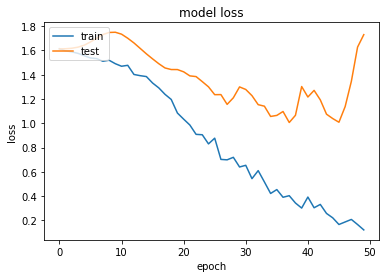

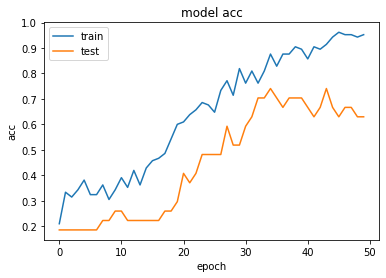

1/2 [==============>...............] - ETA: 0s - loss: 1.1719 - acc: 0.7188

2/2 [==============================] - ETA: 0s - loss: 1.5293 - acc: 0.6607

2/2 [==============================] - 0s 71ms/step - loss: 1.5293 - acc: 0.6607


[1.529258370399475, 0.6607142686843872]

In [79]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.Conv1D(256, 5, activation="relu",
                           padding="same")(embedded_sequences)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128, validation_split=0.2, verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, None, 256)         128256    
_________________________________________________________________
average_pooling1d_14 (Averag (None, None, 256)         0         
_________________________________________________________________
dropout_39 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
dropout_40 (Dropout)         (None, None, 256)         0  

1/1 - 5s - loss: 1.6083 - acc: 0.2286 - val_loss: 1.6102 - val_acc: 0.1481


Epoch 2/50
1/1 - 0s - loss: 1.6014 - acc: 0.3048 - val_loss: 1.6115 - val_acc: 0.2222


Epoch 3/50


1/1 - 0s - loss: 1.5925 - acc: 0.3143 - val_loss: 1.6138 - val_acc: 0.2222


Epoch 4/50


1/1 - 0s - loss: 1.5764 - acc: 0.3333 - val_loss: 1.6200 - val_acc: 0.2222


Epoch 5/50


1/1 - 0s - loss: 1.5675 - acc: 0.3524 - val_loss: 1.6352 - val_acc: 0.2593


Epoch 6/50
1/1 - 0s - loss: 1.5510 - acc: 0.3905 - val_loss: 1.6680 - val_acc: 0.2222


Epoch 7/50
1/1 - 0s - loss: 1.5241 - acc: 0.3143 - val_loss: 1.7288 - val_acc: 0.2222


Epoch 8/50
1/1 - 0s - loss: 1.5176 - acc: 0.3524 - val_loss: 1.8004 - val_acc: 0.2222


Epoch 9/50


1/1 - 0s - loss: 1.5049 - acc: 0.2762 - val_loss: 1.8425 - val_acc: 0.2222


Epoch 10/50


1/1 - 0s - loss: 1.5130 - acc: 0.3524 - val_loss: 1.8461 - val_acc: 0.2222


Epoch 11/50


1/1 - 0s - loss: 1.5312 - acc: 0.3143 - val_loss: 1.8151 - val_acc: 0.2222


Epoch 12/50


1/1 - 0s - loss: 1.4907 - acc: 0.3333 - val_loss: 1.7771 - val_acc: 0.2222


Epoch 13/50


1/1 - 0s - loss: 1.4943 - acc: 0.3333 - val_loss: 1.7402 - val_acc: 0.2593


Epoch 14/50


1/1 - 0s - loss: 1.4989 - acc: 0.2762 - val_loss: 1.7079 - val_acc: 0.2222


Epoch 15/50


1/1 - 0s - loss: 1.4867 - acc: 0.3238 - val_loss: 1.6818 - val_acc: 0.2593


Epoch 16/50


1/1 - 0s - loss: 1.4784 - acc: 0.4000 - val_loss: 1.6609 - val_acc: 0.2593


Epoch 17/50


1/1 - 0s - loss: 1.4792 - acc: 0.3238 - val_loss: 1.6406 - val_acc: 0.2593


Epoch 18/50


1/1 - 0s - loss: 1.4402 - acc: 0.3429 - val_loss: 1.6236 - val_acc: 0.2593


Epoch 19/50


1/1 - 0s - loss: 1.4435 - acc: 0.3143 - val_loss: 1.6071 - val_acc: 0.2593


Epoch 20/50


1/1 - 0s - loss: 1.3971 - acc: 0.4286 - val_loss: 1.5942 - val_acc: 0.2593


Epoch 21/50
1/1 - 0s - loss: 1.3947 - acc: 0.3810 - val_loss: 1.5728 - val_acc: 0.2222


Epoch 22/50
1/1 - 0s - loss: 1.3098 - acc: 0.4857 - val_loss: 1.5620 - val_acc: 0.2963


Epoch 23/50


1/1 - 0s - loss: 1.2826 - acc: 0.4857 - val_loss: 1.5443 - val_acc: 0.2593


Epoch 24/50
1/1 - 0s - loss: 1.2448 - acc: 0.4762 - val_loss: 1.5124 - val_acc: 0.2593


Epoch 25/50
1/1 - 0s - loss: 1.1878 - acc: 0.4857 - val_loss: 1.4755 - val_acc: 0.2963


Epoch 26/50
1/1 - 0s - loss: 1.1196 - acc: 0.5714 - val_loss: 1.4496 - val_acc: 0.3333


Epoch 27/50


1/1 - 0s - loss: 1.1254 - acc: 0.5905 - val_loss: 1.4331 - val_acc: 0.4074


Epoch 28/50
1/1 - 0s - loss: 1.0590 - acc: 0.6095 - val_loss: 1.4153 - val_acc: 0.4815


Epoch 29/50
1/1 - 0s - loss: 0.9998 - acc: 0.6381 - val_loss: 1.4021 - val_acc: 0.4815


Epoch 30/50
1/1 - 0s - loss: 0.9393 - acc: 0.6571 - val_loss: 1.4281 - val_acc: 0.4815


Epoch 31/50
1/1 - 0s - loss: 0.9094 - acc: 0.7048 - val_loss: 1.3975 - val_acc: 0.4815


Epoch 32/50


1/1 - 0s - loss: 0.7753 - acc: 0.7333 - val_loss: 1.4068 - val_acc: 0.5185


Epoch 33/50
1/1 - 0s - loss: 0.7991 - acc: 0.6952 - val_loss: 1.3165 - val_acc: 0.5556


Epoch 34/50


1/1 - 0s - loss: 0.7204 - acc: 0.7238 - val_loss: 1.2370 - val_acc: 0.6667


Epoch 35/50


1/1 - 0s - loss: 0.7395 - acc: 0.7714 - val_loss: 1.2038 - val_acc: 0.6667


Epoch 36/50


1/1 - 0s - loss: 0.6340 - acc: 0.8095 - val_loss: 1.1883 - val_acc: 0.7037


Epoch 37/50
1/1 - 0s - loss: 0.5824 - acc: 0.8381 - val_loss: 1.2082 - val_acc: 0.6667


Epoch 38/50
1/1 - 0s - loss: 0.6564 - acc: 0.7714 - val_loss: 1.2405 - val_acc: 0.5556


Epoch 39/50


1/1 - 0s - loss: 0.4923 - acc: 0.8381 - val_loss: 1.2447 - val_acc: 0.5556


Epoch 40/50


1/1 - 0s - loss: 0.4648 - acc: 0.8762 - val_loss: 1.2563 - val_acc: 0.5556


Epoch 41/50
1/1 - 0s - loss: 0.4120 - acc: 0.8667 - val_loss: 1.2969 - val_acc: 0.5556


Epoch 42/50
1/1 - 0s - loss: 0.4359 - acc: 0.8476 - val_loss: 1.3984 - val_acc: 0.5556


Epoch 43/50
1/1 - 0s - loss: 0.4474 - acc: 0.8286 - val_loss: 1.3980 - val_acc: 0.5926


Epoch 44/50


1/1 - 0s - loss: 0.4315 - acc: 0.8667 - val_loss: 1.2751 - val_acc: 0.6667


Epoch 45/50


1/1 - 0s - loss: 0.4085 - acc: 0.8762 - val_loss: 1.2733 - val_acc: 0.6667


Epoch 46/50
1/1 - 0s - loss: 0.4425 - acc: 0.8571 - val_loss: 1.2758 - val_acc: 0.6296


Epoch 47/50
1/1 - 0s - loss: 0.3795 - acc: 0.8762 - val_loss: 1.4007 - val_acc: 0.5926


Epoch 48/50
1/1 - 0s - loss: 0.2934 - acc: 0.9238 - val_loss: 1.4901 - val_acc: 0.5926


Epoch 49/50
1/1 - 0s - loss: 0.3668 - acc: 0.8857 - val_loss: 1.4218 - val_acc: 0.6667


Epoch 50/50
1/1 - 0s - loss: 0.3675 - acc: 0.8571 - val_loss: 1.2720 - val_acc: 0.7037


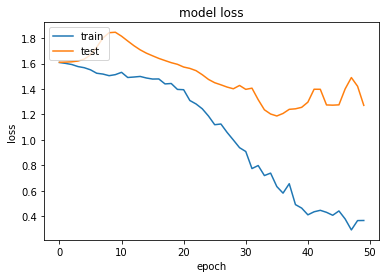

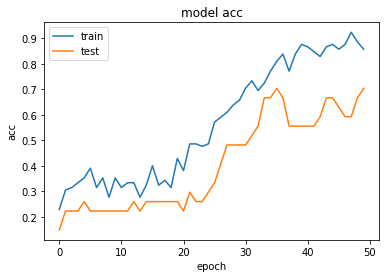

1/2 [==============>...............] - ETA: 0s - loss: 1.2728 - acc: 0.5625

2/2 [==============================] - 0s 23ms/step - loss: 1.4032 - acc: 0.5893


[1.4032342433929443, 0.5892857313156128]

In [81]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.Conv1D(256, 5, activation="relu",
                           padding="same")(embedded_sequences)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128, validation_split=0.2, verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_54 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
dropout_55 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_11  (None, 128)               0  

2/2 - 3s - loss: 1.6191 - acc: 0.1364 - val_loss: 1.6007 - val_acc: 0.2857


Epoch 2/50
2/2 - 0s - loss: 1.5911 - acc: 0.3561 - val_loss: 1.5870 - val_acc: 0.3036


Epoch 3/50
2/2 - 0s - loss: 1.5798 - acc: 0.3106 - val_loss: 1.5685 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5600 - acc: 0.3864 - val_loss: 1.5476 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5602 - acc: 0.2955 - val_loss: 1.5316 - val_acc: 0.3214


Epoch 6/50


2/2 - 0s - loss: 1.5397 - acc: 0.3182 - val_loss: 1.5241 - val_acc: 0.3750


Epoch 7/50


2/2 - 0s - loss: 1.5213 - acc: 0.3030 - val_loss: 1.5167 - val_acc: 0.3571


Epoch 8/50


2/2 - 0s - loss: 1.5070 - acc: 0.3258 - val_loss: 1.5090 - val_acc: 0.3214


Epoch 9/50


2/2 - 0s - loss: 1.5180 - acc: 0.2652 - val_loss: 1.5021 - val_acc: 0.3393


Epoch 10/50


2/2 - 0s - loss: 1.4779 - acc: 0.3182 - val_loss: 1.4920 - val_acc: 0.3393


Epoch 11/50


2/2 - 0s - loss: 1.4768 - acc: 0.2803 - val_loss: 1.4819 - val_acc: 0.3214


Epoch 12/50


2/2 - 0s - loss: 1.4603 - acc: 0.3939 - val_loss: 1.4698 - val_acc: 0.4464


Epoch 13/50


2/2 - 0s - loss: 1.4172 - acc: 0.4015 - val_loss: 1.4535 - val_acc: 0.3750


Epoch 14/50


2/2 - 0s - loss: 1.3862 - acc: 0.4015 - val_loss: 1.4271 - val_acc: 0.4286


Epoch 15/50


2/2 - 0s - loss: 1.3791 - acc: 0.4394 - val_loss: 1.3938 - val_acc: 0.3929


Epoch 16/50


2/2 - 0s - loss: 1.3224 - acc: 0.3939 - val_loss: 1.3698 - val_acc: 0.3571


Epoch 17/50


2/2 - 0s - loss: 1.2758 - acc: 0.4394 - val_loss: 1.3565 - val_acc: 0.3750


Epoch 18/50


2/2 - 0s - loss: 1.2632 - acc: 0.4470 - val_loss: 1.3116 - val_acc: 0.4643


Epoch 19/50


2/2 - 0s - loss: 1.2284 - acc: 0.4697 - val_loss: 1.4027 - val_acc: 0.3036


Epoch 20/50


2/2 - 0s - loss: 1.3085 - acc: 0.4394 - val_loss: 1.4038 - val_acc: 0.3571


Epoch 21/50


2/2 - 0s - loss: 1.3216 - acc: 0.4773 - val_loss: 1.2479 - val_acc: 0.4821


Epoch 22/50


2/2 - 0s - loss: 1.1120 - acc: 0.5455 - val_loss: 1.2793 - val_acc: 0.4464


Epoch 23/50


2/2 - 0s - loss: 1.1968 - acc: 0.4621 - val_loss: 1.2609 - val_acc: 0.4464


Epoch 24/50


2/2 - 0s - loss: 1.1183 - acc: 0.5682 - val_loss: 1.3106 - val_acc: 0.4643


Epoch 25/50


2/2 - 0s - loss: 1.1393 - acc: 0.5379 - val_loss: 1.3130 - val_acc: 0.4464


Epoch 26/50


2/2 - 0s - loss: 1.1344 - acc: 0.5833 - val_loss: 1.2147 - val_acc: 0.5714


Epoch 27/50


2/2 - 0s - loss: 1.0465 - acc: 0.6591 - val_loss: 1.1347 - val_acc: 0.6071


Epoch 28/50


2/2 - 0s - loss: 0.9923 - acc: 0.6364 - val_loss: 1.1057 - val_acc: 0.6250


Epoch 29/50


2/2 - 0s - loss: 0.9413 - acc: 0.6515 - val_loss: 1.0858 - val_acc: 0.5714


Epoch 30/50


2/2 - 0s - loss: 0.8881 - acc: 0.6212 - val_loss: 1.0632 - val_acc: 0.5893


Epoch 31/50


2/2 - 0s - loss: 0.9053 - acc: 0.5985 - val_loss: 1.0553 - val_acc: 0.5714


Epoch 32/50


2/2 - 0s - loss: 0.9133 - acc: 0.6136 - val_loss: 1.0200 - val_acc: 0.5893


Epoch 33/50


2/2 - 0s - loss: 0.8616 - acc: 0.6288 - val_loss: 1.0374 - val_acc: 0.5714


Epoch 34/50


2/2 - 0s - loss: 0.8296 - acc: 0.6591 - val_loss: 1.1632 - val_acc: 0.5357


Epoch 35/50


2/2 - 0s - loss: 0.8874 - acc: 0.6061 - val_loss: 1.0039 - val_acc: 0.5357


Epoch 36/50


2/2 - 0s - loss: 0.7471 - acc: 0.7045 - val_loss: 0.9925 - val_acc: 0.6071


Epoch 37/50


2/2 - 0s - loss: 0.6721 - acc: 0.7348 - val_loss: 1.0541 - val_acc: 0.5536


Epoch 38/50


2/2 - 0s - loss: 0.7372 - acc: 0.7197 - val_loss: 0.9549 - val_acc: 0.6250


Epoch 39/50


2/2 - 0s - loss: 0.6265 - acc: 0.7424 - val_loss: 0.9784 - val_acc: 0.6429


Epoch 40/50


2/2 - 0s - loss: 0.6638 - acc: 0.7576 - val_loss: 1.0215 - val_acc: 0.5893


Epoch 41/50


2/2 - 0s - loss: 0.7472 - acc: 0.7197 - val_loss: 1.1311 - val_acc: 0.5893


Epoch 42/50


2/2 - 0s - loss: 0.8856 - acc: 0.6894 - val_loss: 1.0459 - val_acc: 0.6071


Epoch 43/50


2/2 - 0s - loss: 0.7704 - acc: 0.7576 - val_loss: 0.9780 - val_acc: 0.6071


Epoch 44/50


2/2 - 0s - loss: 0.7370 - acc: 0.7197 - val_loss: 1.0703 - val_acc: 0.5357


Epoch 45/50


2/2 - 0s - loss: 0.8264 - acc: 0.6364 - val_loss: 1.1027 - val_acc: 0.4643


Epoch 46/50


2/2 - 0s - loss: 0.8523 - acc: 0.6212 - val_loss: 1.0445 - val_acc: 0.5357


Epoch 47/50
2/2 - 0s - loss: 0.7486 - acc: 0.7197 - val_loss: 0.9356 - val_acc: 0.6429


Epoch 48/50
2/2 - 0s - loss: 0.6281 - acc: 0.7879 - val_loss: 0.8713 - val_acc: 0.6429


Epoch 49/50


2/2 - 0s - loss: 0.5379 - acc: 0.8409 - val_loss: 0.8705 - val_acc: 0.6786


Epoch 50/50
2/2 - 0s - loss: 0.5059 - acc: 0.8333 - val_loss: 0.9136 - val_acc: 0.6429


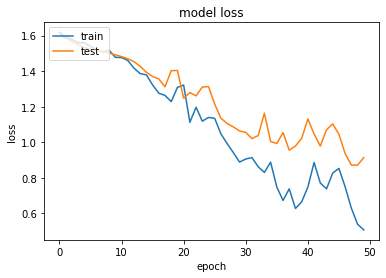

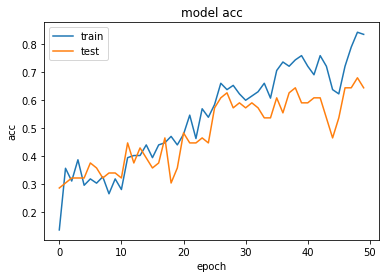

1/2 [==============>...............] - ETA: 0s - loss: 0.7771 - acc: 0.7188

2/2 [==============================] - 0s 15ms/step - loss: 0.9136 - acc: 0.6429


[0.9135890007019043, 0.6428571343421936]

In [85]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu",
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 256)         365568    
_________________________________________________________________
dropout_58 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, None, 256)         327936    
_________________________________________________________________
average_pooling1d_16 (Averag (None, None, 256)         0         
_________________________________________________________________
dropout_59 (Dropout)         (None, None, 256)         0  

2/2 - 3s - loss: 1.6070 - acc: 0.2500 - val_loss: 1.5815 - val_acc: 0.3036


Epoch 2/50
2/2 - 0s - loss: 1.5782 - acc: 0.2652 - val_loss: 1.5568 - val_acc: 0.2857


Epoch 3/50
2/2 - 0s - loss: 1.5365 - acc: 0.3333 - val_loss: 1.5421 - val_acc: 0.2857


Epoch 4/50


2/2 - 0s - loss: 1.5876 - acc: 0.3182 - val_loss: 1.5334 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5409 - acc: 0.3485 - val_loss: 1.5284 - val_acc: 0.3214


Epoch 6/50


2/2 - 0s - loss: 1.6139 - acc: 0.2424 - val_loss: 1.5147 - val_acc: 0.3036


Epoch 7/50


2/2 - 0s - loss: 1.5770 - acc: 0.2576 - val_loss: 1.5127 - val_acc: 0.2857


Epoch 8/50


2/2 - 0s - loss: 1.5051 - acc: 0.2879 - val_loss: 1.5043 - val_acc: 0.2857


Epoch 9/50


2/2 - 0s - loss: 1.4768 - acc: 0.3106 - val_loss: 1.5000 - val_acc: 0.2857


Epoch 10/50


2/2 - 0s - loss: 1.5352 - acc: 0.2879 - val_loss: 1.4641 - val_acc: 0.2857


Epoch 11/50


2/2 - 0s - loss: 1.4637 - acc: 0.3333 - val_loss: 1.4592 - val_acc: 0.3393


Epoch 12/50


2/2 - 0s - loss: 1.3844 - acc: 0.3712 - val_loss: 1.4259 - val_acc: 0.4107


Epoch 13/50


2/2 - 0s - loss: 1.3971 - acc: 0.3561 - val_loss: 1.4225 - val_acc: 0.4821


Epoch 14/50


2/2 - 0s - loss: 1.3590 - acc: 0.3409 - val_loss: 1.4678 - val_acc: 0.3571


Epoch 15/50


2/2 - 0s - loss: 1.3836 - acc: 0.3409 - val_loss: 1.4150 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.3405 - acc: 0.4015 - val_loss: 1.3576 - val_acc: 0.4821


Epoch 17/50
2/2 - 0s - loss: 1.2538 - acc: 0.4394 - val_loss: 1.3376 - val_acc: 0.3929


Epoch 18/50


2/2 - 0s - loss: 1.2796 - acc: 0.4621 - val_loss: 1.3564 - val_acc: 0.5357


Epoch 19/50


2/2 - 0s - loss: 1.3023 - acc: 0.4167 - val_loss: 1.3157 - val_acc: 0.4286


Epoch 20/50


2/2 - 0s - loss: 1.2477 - acc: 0.4167 - val_loss: 1.3359 - val_acc: 0.5357


Epoch 21/50


2/2 - 0s - loss: 1.2417 - acc: 0.5227 - val_loss: 1.3327 - val_acc: 0.6786


Epoch 22/50


2/2 - 0s - loss: 1.2250 - acc: 0.5455 - val_loss: 1.2929 - val_acc: 0.6071


Epoch 23/50


2/2 - 0s - loss: 1.1737 - acc: 0.6061 - val_loss: 1.2201 - val_acc: 0.5714


Epoch 24/50


2/2 - 0s - loss: 1.0985 - acc: 0.5682 - val_loss: 1.1581 - val_acc: 0.6071


Epoch 25/50


2/2 - 0s - loss: 1.0125 - acc: 0.6136 - val_loss: 1.1297 - val_acc: 0.5179


Epoch 26/50


2/2 - 0s - loss: 0.9459 - acc: 0.6288 - val_loss: 1.1240 - val_acc: 0.5179


Epoch 27/50


2/2 - 0s - loss: 0.9789 - acc: 0.5682 - val_loss: 1.1511 - val_acc: 0.5357


Epoch 28/50


2/2 - 0s - loss: 0.9140 - acc: 0.5985 - val_loss: 1.2152 - val_acc: 0.5714


Epoch 29/50


2/2 - 0s - loss: 0.9641 - acc: 0.5909 - val_loss: 1.2389 - val_acc: 0.5179


Epoch 30/50


2/2 - 0s - loss: 0.8609 - acc: 0.6818 - val_loss: 1.2712 - val_acc: 0.5179


Epoch 31/50


2/2 - 0s - loss: 0.8039 - acc: 0.7045 - val_loss: 1.2017 - val_acc: 0.5536


Epoch 32/50


2/2 - 0s - loss: 0.7579 - acc: 0.6818 - val_loss: 1.1645 - val_acc: 0.5893


Epoch 33/50


2/2 - 0s - loss: 0.7570 - acc: 0.6970 - val_loss: 1.1781 - val_acc: 0.5714


Epoch 34/50


2/2 - 0s - loss: 0.6812 - acc: 0.7273 - val_loss: 1.3775 - val_acc: 0.5000


Epoch 35/50


2/2 - 0s - loss: 0.8299 - acc: 0.7197 - val_loss: 1.1934 - val_acc: 0.5714


Epoch 36/50


2/2 - 0s - loss: 0.7997 - acc: 0.7424 - val_loss: 1.3156 - val_acc: 0.5357


Epoch 37/50


2/2 - 0s - loss: 1.1119 - acc: 0.6061 - val_loss: 1.0848 - val_acc: 0.5714


Epoch 38/50


2/2 - 0s - loss: 0.7968 - acc: 0.6667 - val_loss: 1.1858 - val_acc: 0.6071


Epoch 39/50
2/2 - 0s - loss: 0.8525 - acc: 0.6894 - val_loss: 1.1307 - val_acc: 0.5893


Epoch 40/50


2/2 - 0s - loss: 0.7764 - acc: 0.7348 - val_loss: 1.0435 - val_acc: 0.5357


Epoch 41/50


2/2 - 0s - loss: 0.6933 - acc: 0.7348 - val_loss: 0.9924 - val_acc: 0.5536


Epoch 42/50


2/2 - 0s - loss: 0.6349 - acc: 0.7500 - val_loss: 0.9554 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.6188 - acc: 0.7652 - val_loss: 0.9202 - val_acc: 0.6786


Epoch 44/50


2/2 - 0s - loss: 0.6085 - acc: 0.7955 - val_loss: 0.9114 - val_acc: 0.6786


Epoch 45/50


2/2 - 0s - loss: 0.5482 - acc: 0.7727 - val_loss: 0.9585 - val_acc: 0.6071


Epoch 46/50
2/2 - 0s - loss: 0.5645 - acc: 0.7955 - val_loss: 0.9576 - val_acc: 0.5893


Epoch 47/50
2/2 - 0s - loss: 0.5157 - acc: 0.7879 - val_loss: 0.9065 - val_acc: 0.6250


Epoch 48/50
2/2 - 0s - loss: 0.4436 - acc: 0.8636 - val_loss: 0.9297 - val_acc: 0.6250


Epoch 49/50


2/2 - 0s - loss: 0.4566 - acc: 0.8561 - val_loss: 0.9887 - val_acc: 0.6250


Epoch 50/50


2/2 - 0s - loss: 0.5738 - acc: 0.7955 - val_loss: 0.9592 - val_acc: 0.6607


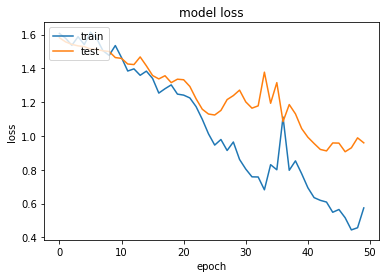

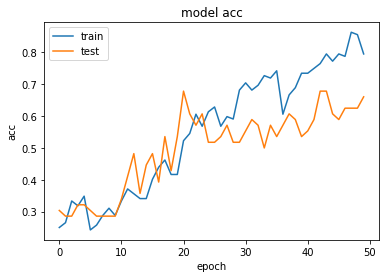

1/2 [==============>...............] - ETA: 0s - loss: 0.9138 - acc: 0.6562

2/2 [==============================] - ETA: 0s - loss: 0.9592 - acc: 0.6607

2/2 [==============================] - 0s 72ms/step - loss: 0.9592 - acc: 0.6607


[0.9591687321662903, 0.6607142686843872]

In [86]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(100, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 256)         365568    
_________________________________________________________________
dropout_62 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, None, 256)         327936    
_________________________________________________________________
average_pooling1d_17 (Averag (None, None, 256)         0         
_________________________________________________________________
dropout_63 (Dropout)         (None, None, 256)         0  

2/2 - 3s - loss: 1.6098 - acc: 0.1591 - val_loss: 1.6004 - val_acc: 0.2679


Epoch 2/50


2/2 - 0s - loss: 1.5992 - acc: 0.2727 - val_loss: 1.5914 - val_acc: 0.3571


Epoch 3/50
2/2 - 0s - loss: 1.5880 - acc: 0.3258 - val_loss: 1.5769 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5807 - acc: 0.3258 - val_loss: 1.5529 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5587 - acc: 0.3258 - val_loss: 1.5482 - val_acc: 0.3214


Epoch 6/50


2/2 - 0s - loss: 1.5787 - acc: 0.3030 - val_loss: 1.6592 - val_acc: 0.3214


Epoch 7/50


2/2 - 0s - loss: 1.7837 - acc: 0.2727 - val_loss: 1.5611 - val_acc: 0.3214


Epoch 8/50


2/2 - 0s - loss: 1.6544 - acc: 0.3030 - val_loss: 1.5238 - val_acc: 0.3214


Epoch 9/50


2/2 - 0s - loss: 1.5305 - acc: 0.2727 - val_loss: 1.5383 - val_acc: 0.3214


Epoch 10/50


2/2 - 0s - loss: 1.5085 - acc: 0.3788 - val_loss: 1.5471 - val_acc: 0.3929


Epoch 11/50


2/2 - 0s - loss: 1.5313 - acc: 0.3182 - val_loss: 1.5490 - val_acc: 0.2679


Epoch 12/50


2/2 - 0s - loss: 1.5429 - acc: 0.2803 - val_loss: 1.5471 - val_acc: 0.3036


Epoch 13/50


2/2 - 0s - loss: 1.5219 - acc: 0.2879 - val_loss: 1.5408 - val_acc: 0.2857


Epoch 14/50


2/2 - 0s - loss: 1.5151 - acc: 0.2803 - val_loss: 1.5419 - val_acc: 0.2857


Epoch 15/50


2/2 - 0s - loss: 1.5260 - acc: 0.2727 - val_loss: 1.5228 - val_acc: 0.3036


Epoch 16/50


2/2 - 0s - loss: 1.5158 - acc: 0.2803 - val_loss: 1.5288 - val_acc: 0.3036


Epoch 17/50


2/2 - 0s - loss: 1.4813 - acc: 0.2955 - val_loss: 1.5226 - val_acc: 0.3750


Epoch 18/50


2/2 - 0s - loss: 1.4801 - acc: 0.2727 - val_loss: 1.4932 - val_acc: 0.3214


Epoch 19/50


2/2 - 0s - loss: 1.4703 - acc: 0.2576 - val_loss: 1.4779 - val_acc: 0.3214


Epoch 20/50


2/2 - 0s - loss: 1.4765 - acc: 0.2576 - val_loss: 1.5132 - val_acc: 0.3750


Epoch 21/50


2/2 - 0s - loss: 1.4653 - acc: 0.3636 - val_loss: 1.5372 - val_acc: 0.3214


Epoch 22/50


2/2 - 0s - loss: 1.5078 - acc: 0.4015 - val_loss: 1.5278 - val_acc: 0.3214


Epoch 23/50


2/2 - 0s - loss: 1.4938 - acc: 0.4167 - val_loss: 1.5082 - val_acc: 0.3393


Epoch 24/50


2/2 - 0s - loss: 1.4659 - acc: 0.3788 - val_loss: 1.4891 - val_acc: 0.3571


Epoch 25/50


2/2 - 0s - loss: 1.4538 - acc: 0.3636 - val_loss: 1.4673 - val_acc: 0.3214


Epoch 26/50


2/2 - 0s - loss: 1.4166 - acc: 0.3636 - val_loss: 1.4333 - val_acc: 0.3214


Epoch 27/50


2/2 - 0s - loss: 1.3672 - acc: 0.4167 - val_loss: 1.4314 - val_acc: 0.3214


Epoch 28/50


2/2 - 0s - loss: 1.4077 - acc: 0.3712 - val_loss: 1.4152 - val_acc: 0.4107


Epoch 29/50


2/2 - 0s - loss: 1.3549 - acc: 0.4697 - val_loss: 1.3376 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 1.3105 - acc: 0.4470 - val_loss: 1.2887 - val_acc: 0.5000


Epoch 31/50


2/2 - 0s - loss: 1.2455 - acc: 0.4848 - val_loss: 1.2721 - val_acc: 0.5000


Epoch 32/50


2/2 - 0s - loss: 1.2216 - acc: 0.4924 - val_loss: 1.2797 - val_acc: 0.5000


Epoch 33/50


2/2 - 0s - loss: 1.1681 - acc: 0.4924 - val_loss: 1.2442 - val_acc: 0.4821


Epoch 34/50


2/2 - 0s - loss: 1.0750 - acc: 0.5606 - val_loss: 1.1505 - val_acc: 0.5536


Epoch 35/50


2/2 - 0s - loss: 1.0022 - acc: 0.6136 - val_loss: 1.1470 - val_acc: 0.4464


Epoch 36/50


2/2 - 0s - loss: 0.9395 - acc: 0.5909 - val_loss: 1.2710 - val_acc: 0.3750


Epoch 37/50


2/2 - 0s - loss: 0.9671 - acc: 0.6061 - val_loss: 1.1954 - val_acc: 0.4464


Epoch 38/50


2/2 - 0s - loss: 0.8829 - acc: 0.6364 - val_loss: 1.1199 - val_acc: 0.4821


Epoch 39/50


2/2 - 0s - loss: 0.8791 - acc: 0.5985 - val_loss: 1.2002 - val_acc: 0.5357


Epoch 40/50


2/2 - 0s - loss: 0.9201 - acc: 0.6212 - val_loss: 1.3088 - val_acc: 0.5179


Epoch 41/50


2/2 - 0s - loss: 0.9728 - acc: 0.5909 - val_loss: 1.2618 - val_acc: 0.5536


Epoch 42/50


2/2 - 0s - loss: 0.8155 - acc: 0.6591 - val_loss: 1.3111 - val_acc: 0.5000


Epoch 43/50


2/2 - 0s - loss: 0.9537 - acc: 0.6818 - val_loss: 1.2650 - val_acc: 0.4821


Epoch 44/50


2/2 - 0s - loss: 0.9953 - acc: 0.6212 - val_loss: 1.3758 - val_acc: 0.4643


Epoch 45/50


2/2 - 0s - loss: 0.9300 - acc: 0.6136 - val_loss: 1.3401 - val_acc: 0.5179


Epoch 46/50


2/2 - 0s - loss: 1.0028 - acc: 0.5682 - val_loss: 1.2506 - val_acc: 0.5000


Epoch 47/50


2/2 - 0s - loss: 0.9934 - acc: 0.5909 - val_loss: 1.1688 - val_acc: 0.5357


Epoch 48/50


2/2 - 0s - loss: 0.8815 - acc: 0.5985 - val_loss: 1.0948 - val_acc: 0.5000


Epoch 49/50


2/2 - 0s - loss: 0.7975 - acc: 0.6818 - val_loss: 1.1890 - val_acc: 0.5357


Epoch 50/50


2/2 - 0s - loss: 0.9598 - acc: 0.5985 - val_loss: 1.1862 - val_acc: 0.5000


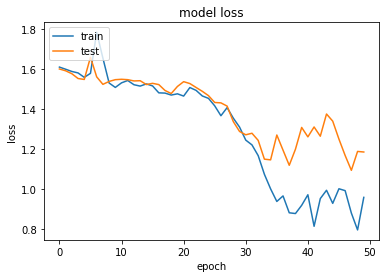

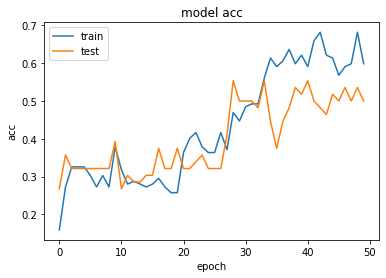

1/2 [==============>...............] - ETA: 0s - loss: 1.0907 - acc: 0.5312

2/2 [==============================] - 0s 31ms/step - loss: 1.1862 - acc: 0.5000


[1.1862118244171143, 0.5]

In [87]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_24 (LSTM)               (None, None, 256)         365568    
_________________________________________________________________
dropout_66 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, None, 512)         655872    
_________________________________________________________________
average_pooling1d_18 (Averag (None, None, 512)         0         
_________________________________________________________________
dropout_67 (Dropout)         (None, None, 512)         0  

2/2 - 4s - loss: 1.6174 - acc: 0.0758 - val_loss: 1.6110 - val_acc: 0.1429


Epoch 2/50
2/2 - 0s - loss: 1.6217 - acc: 0.1970 - val_loss: 1.6117 - val_acc: 0.1429


Epoch 3/50
2/2 - 0s - loss: 1.6554 - acc: 0.1667 - val_loss: 1.6082 - val_acc: 0.2679


Epoch 4/50
2/2 - 0s - loss: 1.6299 - acc: 0.2576 - val_loss: 1.6045 - val_acc: 0.3214


Epoch 5/50
2/2 - 0s - loss: 1.6159 - acc: 0.2197 - val_loss: 1.6024 - val_acc: 0.3214


Epoch 6/50


2/2 - 0s - loss: 1.6130 - acc: 0.2197 - val_loss: 1.6010 - val_acc: 0.3214


Epoch 7/50


2/2 - 0s - loss: 1.6287 - acc: 0.2045 - val_loss: 1.5999 - val_acc: 0.3214


Epoch 8/50


2/2 - 0s - loss: 1.6242 - acc: 0.1591 - val_loss: 1.5991 - val_acc: 0.3214


Epoch 9/50


2/2 - 0s - loss: 1.5905 - acc: 0.3030 - val_loss: 1.5985 - val_acc: 0.3214


Epoch 10/50


2/2 - 0s - loss: 1.5948 - acc: 0.2879 - val_loss: 1.5976 - val_acc: 0.3214


Epoch 11/50


2/2 - 0s - loss: 1.5948 - acc: 0.3106 - val_loss: 1.5967 - val_acc: 0.3214


Epoch 12/50


2/2 - 0s - loss: 1.6005 - acc: 0.2576 - val_loss: 1.5954 - val_acc: 0.3214


Epoch 13/50
2/2 - 0s - loss: 1.6055 - acc: 0.2197 - val_loss: 1.5935 - val_acc: 0.3214


Epoch 14/50


2/2 - 0s - loss: 1.5997 - acc: 0.2879 - val_loss: 1.5920 - val_acc: 0.3214


Epoch 15/50


2/2 - 0s - loss: 1.6310 - acc: 0.2500 - val_loss: 1.5914 - val_acc: 0.3214


Epoch 16/50


2/2 - 0s - loss: 1.6040 - acc: 0.2500 - val_loss: 1.5905 - val_acc: 0.3214


Epoch 17/50


2/2 - 0s - loss: 1.6352 - acc: 0.2424 - val_loss: 1.5907 - val_acc: 0.3214


Epoch 18/50


2/2 - 0s - loss: 1.6049 - acc: 0.2121 - val_loss: 1.5906 - val_acc: 0.3214


Epoch 19/50


2/2 - 0s - loss: 1.6031 - acc: 0.2500 - val_loss: 1.5917 - val_acc: 0.3214


Epoch 20/50


2/2 - 0s - loss: 1.5882 - acc: 0.2727 - val_loss: 1.5920 - val_acc: 0.3214


Epoch 21/50


2/2 - 0s - loss: 1.6034 - acc: 0.2652 - val_loss: 1.5918 - val_acc: 0.3214


Epoch 22/50


2/2 - 0s - loss: 1.5938 - acc: 0.2879 - val_loss: 1.5913 - val_acc: 0.3214


Epoch 23/50
2/2 - 0s - loss: 1.5950 - acc: 0.2803 - val_loss: 1.5908 - val_acc: 0.3214


Epoch 24/50


2/2 - 0s - loss: 1.5989 - acc: 0.2348 - val_loss: 1.5899 - val_acc: 0.3214


Epoch 25/50


2/2 - 0s - loss: 1.5915 - acc: 0.2803 - val_loss: 1.5886 - val_acc: 0.3214


Epoch 26/50


2/2 - 0s - loss: 1.5911 - acc: 0.2652 - val_loss: 1.5872 - val_acc: 0.3214


Epoch 27/50


2/2 - 0s - loss: 1.5869 - acc: 0.3106 - val_loss: 1.5854 - val_acc: 0.3214


Epoch 28/50


2/2 - 0s - loss: 1.5965 - acc: 0.2803 - val_loss: 1.5835 - val_acc: 0.3214


Epoch 29/50
2/2 - 0s - loss: 1.6019 - acc: 0.2121 - val_loss: 1.5822 - val_acc: 0.3214


Epoch 30/50


2/2 - 0s - loss: 1.6102 - acc: 0.2576 - val_loss: 1.5823 - val_acc: 0.3214


Epoch 31/50


2/2 - 0s - loss: 1.5982 - acc: 0.2424 - val_loss: 1.5827 - val_acc: 0.3214


Epoch 32/50
2/2 - 0s - loss: 1.5906 - acc: 0.2803 - val_loss: 1.5818 - val_acc: 0.3214


Epoch 33/50


2/2 - 0s - loss: 1.5809 - acc: 0.2652 - val_loss: 1.5783 - val_acc: 0.3214


Epoch 34/50


2/2 - 0s - loss: 1.6030 - acc: 0.2879 - val_loss: 1.5725 - val_acc: 0.3214


Epoch 35/50


2/2 - 0s - loss: 1.6238 - acc: 0.2955 - val_loss: 1.5762 - val_acc: 0.3214


Epoch 36/50
2/2 - 0s - loss: 1.5763 - acc: 0.2652 - val_loss: 1.5801 - val_acc: 0.3214


Epoch 37/50


2/2 - 0s - loss: 1.5931 - acc: 0.2576 - val_loss: 1.5804 - val_acc: 0.3214


Epoch 38/50


2/2 - 0s - loss: 1.5991 - acc: 0.3030 - val_loss: 1.5805 - val_acc: 0.3214


Epoch 39/50


2/2 - 0s - loss: 1.6174 - acc: 0.2424 - val_loss: 1.5802 - val_acc: 0.3214


Epoch 40/50


2/2 - 0s - loss: 1.5982 - acc: 0.2879 - val_loss: 1.5799 - val_acc: 0.3214


Epoch 41/50


2/2 - 0s - loss: 1.5876 - acc: 0.2879 - val_loss: 1.5792 - val_acc: 0.3214


Epoch 42/50


2/2 - 0s - loss: 1.5794 - acc: 0.2652 - val_loss: 1.5780 - val_acc: 0.3214


Epoch 43/50


2/2 - 0s - loss: 1.5863 - acc: 0.2727 - val_loss: 1.5776 - val_acc: 0.3214


Epoch 44/50


2/2 - 0s - loss: 1.5802 - acc: 0.2879 - val_loss: 1.5782 - val_acc: 0.3214


Epoch 45/50


2/2 - 0s - loss: 1.5912 - acc: 0.2652 - val_loss: 1.5788 - val_acc: 0.3214


Epoch 46/50
2/2 - 0s - loss: 1.5937 - acc: 0.2879 - val_loss: 1.5783 - val_acc: 0.3214


Epoch 47/50


2/2 - 0s - loss: 1.5820 - acc: 0.2955 - val_loss: 1.5753 - val_acc: 0.3214


Epoch 48/50


2/2 - 0s - loss: 1.5776 - acc: 0.2879 - val_loss: 1.5719 - val_acc: 0.3214


Epoch 49/50


2/2 - 0s - loss: 1.5661 - acc: 0.3333 - val_loss: 1.5645 - val_acc: 0.3214


Epoch 50/50
2/2 - 0s - loss: 1.6103 - acc: 0.2652 - val_loss: 1.5661 - val_acc: 0.3214


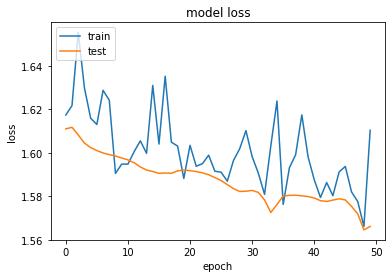

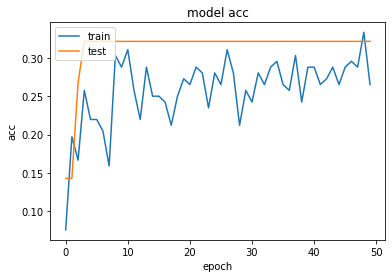

1/2 [==============>...............] - ETA: 0s - loss: 1.5622 - acc: 0.2812

2/2 [==============================] - ETA: 0s - loss: 1.5661 - acc: 0.3214

2/2 [==============================] - 0s 105ms/step - loss: 1.5661 - acc: 0.3214


[1.566084861755371, 0.3214285671710968]

In [88]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(512, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu", 
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_26 (LSTM)               (None, None, 256)         365568    
_________________________________________________________________
dropout_73 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, None, 512)         655872    
_________________________________________________________________
average_pooling1d_19 (Averag (None, None, 512)         0         
_________________________________________________________________
dropout_74 (Dropout)         (None, None, 512)         0  

2/2 - 3s - loss: 1.6087 - acc: 0.2197 - val_loss: 1.5575 - val_acc: 0.3214


Epoch 2/50


2/2 - 0s - loss: 1.5396 - acc: 0.2879 - val_loss: 1.5451 - val_acc: 0.3750


Epoch 3/50
2/2 - 0s - loss: 1.5386 - acc: 0.3333 - val_loss: 1.6543 - val_acc: 0.1250


Epoch 4/50
2/2 - 0s - loss: 1.7097 - acc: 0.1667 - val_loss: 1.6002 - val_acc: 0.1250


Epoch 5/50
2/2 - 0s - loss: 1.6211 - acc: 0.1667 - val_loss: 1.5049 - val_acc: 0.2679


Epoch 6/50
2/2 - 0s - loss: 1.4646 - acc: 0.2955 - val_loss: 1.4655 - val_acc: 0.4107


Epoch 7/50


2/2 - 0s - loss: 1.3915 - acc: 0.4697 - val_loss: 1.4425 - val_acc: 0.3929


Epoch 8/50


2/2 - 0s - loss: 1.3376 - acc: 0.4621 - val_loss: 1.3652 - val_acc: 0.3750


Epoch 9/50


2/2 - 0s - loss: 1.2196 - acc: 0.4621 - val_loss: 1.3339 - val_acc: 0.4464


Epoch 10/50


2/2 - 0s - loss: 1.2252 - acc: 0.4167 - val_loss: 1.4250 - val_acc: 0.3750


Epoch 11/50


2/2 - 0s - loss: 1.4416 - acc: 0.4015 - val_loss: 1.3233 - val_acc: 0.4464


Epoch 12/50


2/2 - 0s - loss: 1.2520 - acc: 0.5076 - val_loss: 1.2288 - val_acc: 0.4643


Epoch 13/50


2/2 - 0s - loss: 0.9488 - acc: 0.6970 - val_loss: 1.2793 - val_acc: 0.4821


Epoch 14/50


2/2 - 0s - loss: 0.9686 - acc: 0.6818 - val_loss: 1.2085 - val_acc: 0.5179


Epoch 15/50


2/2 - 0s - loss: 0.8736 - acc: 0.6970 - val_loss: 1.1393 - val_acc: 0.4821


Epoch 16/50

2/2 - 0s - loss: 0.7628 - acc: 0.7273 - val_loss: 1.3281 - val_acc: 0.4821


Epoch 17/50


2/2 - 0s - loss: 0.8856 - acc: 0.6970 - val_loss: 1.1152 - val_acc: 0.5357


Epoch 18/50


2/2 - 0s - loss: 0.5995 - acc: 0.7879 - val_loss: 1.2638 - val_acc: 0.4821


Epoch 19/50


2/2 - 0s - loss: 0.7453 - acc: 0.6742 - val_loss: 1.2381 - val_acc: 0.5714


Epoch 20/50


2/2 - 0s - loss: 0.8570 - acc: 0.7045 - val_loss: 1.2292 - val_acc: 0.5179


Epoch 21/50


2/2 - 0s - loss: 0.8971 - acc: 0.6742 - val_loss: 1.1323 - val_acc: 0.4286


Epoch 22/50


2/2 - 0s - loss: 0.7113 - acc: 0.7045 - val_loss: 1.0435 - val_acc: 0.5179


Epoch 23/50


2/2 - 0s - loss: 0.5678 - acc: 0.8258 - val_loss: 0.9859 - val_acc: 0.5536


Epoch 24/50
2/2 - 0s - loss: 0.5749 - acc: 0.7879 - val_loss: 0.9517 - val_acc: 0.5714


Epoch 25/50


2/2 - 0s - loss: 0.5996 - acc: 0.7727 - val_loss: 1.0412 - val_acc: 0.5536


Epoch 26/50


2/2 - 0s - loss: 0.6569 - acc: 0.7879 - val_loss: 1.0080 - val_acc: 0.5714


Epoch 27/50


2/2 - 0s - loss: 0.6107 - acc: 0.7879 - val_loss: 0.8727 - val_acc: 0.5714


Epoch 28/50


2/2 - 0s - loss: 0.4651 - acc: 0.8561 - val_loss: 0.9372 - val_acc: 0.6429


Epoch 29/50


2/2 - 0s - loss: 0.4672 - acc: 0.8409 - val_loss: 0.9723 - val_acc: 0.6429


Epoch 30/50
2/2 - 0s - loss: 0.4337 - acc: 0.8636 - val_loss: 0.9695 - val_acc: 0.6429


Epoch 31/50


2/2 - 0s - loss: 0.4006 - acc: 0.9015 - val_loss: 1.2062 - val_acc: 0.5893


Epoch 32/50


2/2 - 0s - loss: 0.5751 - acc: 0.8030 - val_loss: 1.4571 - val_acc: 0.5893


Epoch 33/50


2/2 - 0s - loss: 0.7756 - acc: 0.7500 - val_loss: 1.2026 - val_acc: 0.5536


Epoch 34/50


2/2 - 0s - loss: 0.6156 - acc: 0.8106 - val_loss: 1.0466 - val_acc: 0.5536


Epoch 35/50


2/2 - 0s - loss: 0.4411 - acc: 0.8485 - val_loss: 1.0792 - val_acc: 0.5893


Epoch 36/50


2/2 - 0s - loss: 0.4056 - acc: 0.8864 - val_loss: 1.2246 - val_acc: 0.6250


Epoch 37/50


2/2 - 0s - loss: 0.5365 - acc: 0.8030 - val_loss: 0.8778 - val_acc: 0.6964


Epoch 38/50


2/2 - 0s - loss: 0.3109 - acc: 0.9015 - val_loss: 0.8737 - val_acc: 0.6786


Epoch 39/50


2/2 - 0s - loss: 0.4230 - acc: 0.8409 - val_loss: 0.8510 - val_acc: 0.6071


Epoch 40/50


2/2 - 0s - loss: 0.3209 - acc: 0.9015 - val_loss: 1.1562 - val_acc: 0.6429


Epoch 41/50


2/2 - 0s - loss: 0.4894 - acc: 0.8030 - val_loss: 1.1708 - val_acc: 0.6429


Epoch 42/50
2/2 - 0s - loss: 0.5409 - acc: 0.7727 - val_loss: 1.0950 - val_acc: 0.6250


Epoch 43/50


2/2 - 0s - loss: 0.4681 - acc: 0.8409 - val_loss: 1.0432 - val_acc: 0.6250


Epoch 44/50


2/2 - 0s - loss: 0.4141 - acc: 0.8258 - val_loss: 0.9832 - val_acc: 0.6607


Epoch 45/50


2/2 - 0s - loss: 0.3289 - acc: 0.8636 - val_loss: 0.9316 - val_acc: 0.6607


Epoch 46/50


2/2 - 0s - loss: 0.2614 - acc: 0.8939 - val_loss: 0.9548 - val_acc: 0.6429


Epoch 47/50


2/2 - 0s - loss: 0.2872 - acc: 0.8864 - val_loss: 0.8838 - val_acc: 0.6964


Epoch 48/50


2/2 - 0s - loss: 0.3291 - acc: 0.8788 - val_loss: 0.9829 - val_acc: 0.6607


Epoch 49/50


2/2 - 0s - loss: 0.3716 - acc: 0.8636 - val_loss: 0.9500 - val_acc: 0.6786


Epoch 50/50


2/2 - 0s - loss: 0.2917 - acc: 0.8864 - val_loss: 1.0151 - val_acc: 0.7143


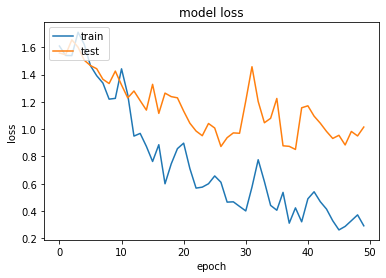

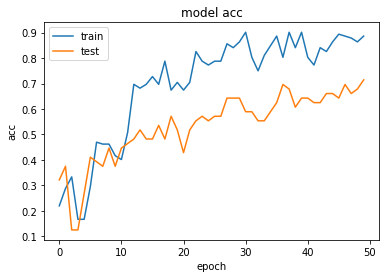

1/2 [==============>...............] - ETA: 0s - loss: 0.9610 - acc: 0.7500

2/2 [==============================] - 0s 36ms/step - loss: 1.0151 - acc: 0.7143


[1.0151382684707642, 0.7142857313156128]

In [89]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(512, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu", 
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_30 (LSTM)               (None, None, 256)         365568    
_________________________________________________________________
dropout_79 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, None, 256)         327936    
_________________________________________________________________
average_pooling1d_21 (Averag (None, None, 256)         0         
_________________________________________________________________
dropout_80 (Dropout)         (None, None, 256)         0  

2/2 - 3s - loss: 1.6087 - acc: 0.1288 - val_loss: 1.5576 - val_acc: 0.3036


Epoch 2/50


2/2 - 0s - loss: 1.5487 - acc: 0.2879 - val_loss: 1.5539 - val_acc: 0.2857


Epoch 3/50
2/2 - 0s - loss: 1.5396 - acc: 0.2879 - val_loss: 1.5517 - val_acc: 0.2857


Epoch 4/50
2/2 - 0s - loss: 1.5180 - acc: 0.2727 - val_loss: 1.5497 - val_acc: 0.2857


Epoch 5/50


2/2 - 0s - loss: 1.5056 - acc: 0.2879 - val_loss: 1.5441 - val_acc: 0.3036


Epoch 6/50


2/2 - 0s - loss: 1.5106 - acc: 0.3182 - val_loss: 1.4813 - val_acc: 0.2321


Epoch 7/50


2/2 - 0s - loss: 1.4224 - acc: 0.3030 - val_loss: 1.4349 - val_acc: 0.3214


Epoch 8/50


2/2 - 0s - loss: 1.3596 - acc: 0.3258 - val_loss: 1.4176 - val_acc: 0.3750


Epoch 9/50


2/2 - 0s - loss: 1.3964 - acc: 0.3485 - val_loss: 1.3171 - val_acc: 0.3929


Epoch 10/50


2/2 - 0s - loss: 1.2798 - acc: 0.3788 - val_loss: 1.2647 - val_acc: 0.4464


Epoch 11/50


2/2 - 0s - loss: 1.1922 - acc: 0.5076 - val_loss: 1.3478 - val_acc: 0.3929


Epoch 12/50


2/2 - 0s - loss: 1.2606 - acc: 0.4697 - val_loss: 1.4107 - val_acc: 0.4107


Epoch 13/50


2/2 - 0s - loss: 1.3531 - acc: 0.4394 - val_loss: 1.3326 - val_acc: 0.4286


Epoch 14/50


2/2 - 0s - loss: 1.2259 - acc: 0.4773 - val_loss: 1.2203 - val_acc: 0.4821


Epoch 15/50


2/2 - 0s - loss: 1.0593 - acc: 0.5682 - val_loss: 1.1720 - val_acc: 0.4821


Epoch 16/50


2/2 - 0s - loss: 0.9983 - acc: 0.5833 - val_loss: 1.1485 - val_acc: 0.4643


Epoch 17/50


2/2 - 0s - loss: 0.9225 - acc: 0.5606 - val_loss: 1.2095 - val_acc: 0.4643


Epoch 18/50


2/2 - 0s - loss: 0.9051 - acc: 0.5379 - val_loss: 1.2110 - val_acc: 0.5000


Epoch 19/50


2/2 - 0s - loss: 0.6780 - acc: 0.7424 - val_loss: 1.1858 - val_acc: 0.5357


Epoch 20/50


2/2 - 0s - loss: 0.6053 - acc: 0.7121 - val_loss: 1.4499 - val_acc: 0.5000


Epoch 21/50


2/2 - 0s - loss: 0.9692 - acc: 0.6970 - val_loss: 1.2832 - val_acc: 0.5179


Epoch 22/50


2/2 - 0s - loss: 0.6589 - acc: 0.7500 - val_loss: 1.4060 - val_acc: 0.5536


Epoch 23/50


2/2 - 0s - loss: 0.7295 - acc: 0.7273 - val_loss: 1.1843 - val_acc: 0.5357


Epoch 24/50


2/2 - 0s - loss: 0.5663 - acc: 0.7652 - val_loss: 1.1948 - val_acc: 0.5357


Epoch 25/50


2/2 - 0s - loss: 0.6679 - acc: 0.7652 - val_loss: 1.0397 - val_acc: 0.5714


Epoch 26/50


2/2 - 0s - loss: 0.4741 - acc: 0.8258 - val_loss: 1.2068 - val_acc: 0.5179


Epoch 27/50


2/2 - 0s - loss: 0.7080 - acc: 0.7500 - val_loss: 1.0727 - val_acc: 0.5357


Epoch 28/50


2/2 - 0s - loss: 0.6008 - acc: 0.7727 - val_loss: 0.9869 - val_acc: 0.5714


Epoch 29/50


2/2 - 0s - loss: 0.4931 - acc: 0.8106 - val_loss: 1.0849 - val_acc: 0.5714


Epoch 30/50


2/2 - 0s - loss: 0.5891 - acc: 0.7955 - val_loss: 0.9954 - val_acc: 0.6071


Epoch 31/50


2/2 - 0s - loss: 0.5573 - acc: 0.7803 - val_loss: 1.1980 - val_acc: 0.5179


Epoch 32/50


2/2 - 0s - loss: 0.7495 - acc: 0.7348 - val_loss: 1.4444 - val_acc: 0.5536


Epoch 33/50


2/2 - 0s - loss: 1.2022 - acc: 0.6439 - val_loss: 1.2953 - val_acc: 0.5357


Epoch 34/50


2/2 - 0s - loss: 0.8168 - acc: 0.6742 - val_loss: 1.1419 - val_acc: 0.6071


Epoch 35/50


2/2 - 0s - loss: 0.7229 - acc: 0.7273 - val_loss: 1.4918 - val_acc: 0.4821


Epoch 36/50


2/2 - 0s - loss: 1.1629 - acc: 0.5833 - val_loss: 1.2407 - val_acc: 0.5357


Epoch 37/50


2/2 - 0s - loss: 0.9163 - acc: 0.6818 - val_loss: 0.9900 - val_acc: 0.6071


Epoch 38/50


2/2 - 0s - loss: 0.6418 - acc: 0.7045 - val_loss: 0.9396 - val_acc: 0.6429


Epoch 39/50


2/2 - 0s - loss: 0.5849 - acc: 0.7879 - val_loss: 0.9574 - val_acc: 0.6071


Epoch 40/50


2/2 - 0s - loss: 0.5778 - acc: 0.8258 - val_loss: 0.9727 - val_acc: 0.5893


Epoch 41/50


2/2 - 0s - loss: 0.5359 - acc: 0.8409 - val_loss: 1.0055 - val_acc: 0.5714


Epoch 42/50


2/2 - 0s - loss: 0.5076 - acc: 0.8636 - val_loss: 0.9880 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.4986 - acc: 0.8258 - val_loss: 1.0077 - val_acc: 0.5536


Epoch 44/50


2/2 - 0s - loss: 0.5192 - acc: 0.7879 - val_loss: 1.0006 - val_acc: 0.5714


Epoch 45/50


2/2 - 0s - loss: 0.4375 - acc: 0.8258 - val_loss: 0.9548 - val_acc: 0.6786


Epoch 46/50


2/2 - 0s - loss: 0.3397 - acc: 0.8864 - val_loss: 1.2104 - val_acc: 0.5714


Epoch 47/50


2/2 - 0s - loss: 0.5424 - acc: 0.8182 - val_loss: 1.1923 - val_acc: 0.5893


Epoch 48/50


2/2 - 0s - loss: 0.5369 - acc: 0.8030 - val_loss: 1.0323 - val_acc: 0.6071


Epoch 49/50


2/2 - 0s - loss: 0.4459 - acc: 0.8636 - val_loss: 0.9424 - val_acc: 0.6250


Epoch 50/50


2/2 - 0s - loss: 0.3770 - acc: 0.8636 - val_loss: 0.9138 - val_acc: 0.6964


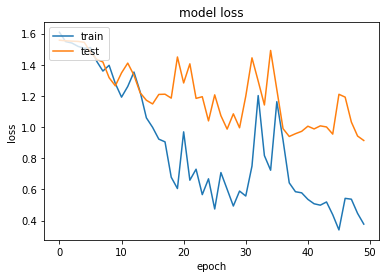

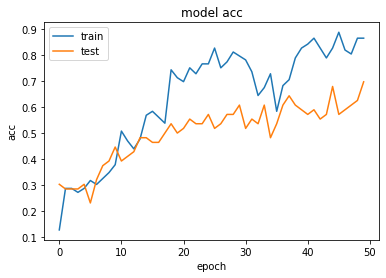

1/2 [==============>...............] - ETA: 0s - loss: 0.8728 - acc: 0.7188

2/2 [==============================] - 0s 42ms/step - loss: 0.9138 - acc: 0.6964


[0.913848876953125, 0.6964285969734192]

In [91]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu", 
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_37 (LSTM)               (None, None, 256)         365568    
_________________________________________________________________
dropout_91 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_38 (LSTM)               (None, None, 128)         197120    
_________________________________________________________________
dropout_92 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, None, 64)          410

2/2 - 4s - loss: 1.6109 - acc: 0.1515 - val_loss: 1.5947 - val_acc: 0.2857


Epoch 2/50
2/2 - 0s - loss: 1.5892 - acc: 0.3106 - val_loss: 1.5772 - val_acc: 0.3036


Epoch 3/50
2/2 - 0s - loss: 1.5686 - acc: 0.2879 - val_loss: 1.5786 - val_acc: 0.2857


Epoch 4/50


2/2 - 0s - loss: 1.5831 - acc: 0.2727 - val_loss: 1.5730 - val_acc: 0.3036


Epoch 5/50


2/2 - 0s - loss: 1.5574 - acc: 0.2727 - val_loss: 1.5685 - val_acc: 0.2857


Epoch 6/50


2/2 - 0s - loss: 1.5501 - acc: 0.2803 - val_loss: 1.5656 - val_acc: 0.3036


Epoch 7/50


2/2 - 0s - loss: 1.5335 - acc: 0.3485 - val_loss: 1.5556 - val_acc: 0.2857


Epoch 8/50


2/2 - 0s - loss: 1.5225 - acc: 0.3485 - val_loss: 1.5308 - val_acc: 0.3036


Epoch 9/50


2/2 - 0s - loss: 1.5034 - acc: 0.3636 - val_loss: 1.4940 - val_acc: 0.3750


Epoch 10/50


2/2 - 0s - loss: 1.4551 - acc: 0.3788 - val_loss: 1.4548 - val_acc: 0.3393


Epoch 11/50


2/2 - 0s - loss: 1.4063 - acc: 0.4167 - val_loss: 1.4193 - val_acc: 0.4107


Epoch 12/50


2/2 - 0s - loss: 1.3711 - acc: 0.4697 - val_loss: 1.3977 - val_acc: 0.4464


Epoch 13/50


2/2 - 0s - loss: 1.3305 - acc: 0.4697 - val_loss: 1.4335 - val_acc: 0.4107


Epoch 14/50


2/2 - 0s - loss: 1.3387 - acc: 0.4773 - val_loss: 1.4808 - val_acc: 0.3929


Epoch 15/50


2/2 - 0s - loss: 1.2968 - acc: 0.5152 - val_loss: 1.4000 - val_acc: 0.4643


Epoch 16/50


2/2 - 0s - loss: 1.3619 - acc: 0.4924 - val_loss: 1.4385 - val_acc: 0.4286


Epoch 17/50


2/2 - 0s - loss: 1.3370 - acc: 0.4621 - val_loss: 1.4032 - val_acc: 0.4286


Epoch 18/50


2/2 - 0s - loss: 1.1505 - acc: 0.5076 - val_loss: 1.3863 - val_acc: 0.4821


Epoch 19/50


2/2 - 0s - loss: 1.0865 - acc: 0.5682 - val_loss: 1.3949 - val_acc: 0.4821


Epoch 20/50


2/2 - 0s - loss: 1.2438 - acc: 0.4545 - val_loss: 1.4418 - val_acc: 0.4464


Epoch 21/50


2/2 - 0s - loss: 1.2238 - acc: 0.4545 - val_loss: 1.3190 - val_acc: 0.4107


Epoch 22/50


2/2 - 0s - loss: 1.1743 - acc: 0.4773 - val_loss: 2.0576 - val_acc: 0.2143


Epoch 23/50


2/2 - 0s - loss: 1.7424 - acc: 0.3333 - val_loss: 1.5963 - val_acc: 0.3214


Epoch 24/50


2/2 - 0s - loss: 1.3026 - acc: 0.4848 - val_loss: 1.4388 - val_acc: 0.3929


Epoch 25/50


2/2 - 0s - loss: 1.1435 - acc: 0.5455 - val_loss: 1.3580 - val_acc: 0.4286


Epoch 26/50


2/2 - 0s - loss: 1.1478 - acc: 0.5227 - val_loss: 1.3512 - val_acc: 0.4464


Epoch 27/50


2/2 - 0s - loss: 1.1837 - acc: 0.5076 - val_loss: 1.2536 - val_acc: 0.4821


Epoch 28/50


2/2 - 0s - loss: 1.1511 - acc: 0.5303 - val_loss: 1.1535 - val_acc: 0.4643


Epoch 29/50


2/2 - 0s - loss: 0.9902 - acc: 0.5833 - val_loss: 1.2758 - val_acc: 0.5000


Epoch 30/50


2/2 - 0s - loss: 1.0693 - acc: 0.5909 - val_loss: 1.4280 - val_acc: 0.4107


Epoch 31/50


2/2 - 0s - loss: 1.2190 - acc: 0.5379 - val_loss: 1.2416 - val_acc: 0.4286


Epoch 32/50


2/2 - 0s - loss: 1.0717 - acc: 0.6061 - val_loss: 1.2146 - val_acc: 0.4464


Epoch 33/50


2/2 - 0s - loss: 1.0435 - acc: 0.6364 - val_loss: 1.2234 - val_acc: 0.4821


Epoch 34/50


2/2 - 0s - loss: 1.0199 - acc: 0.6667 - val_loss: 1.2106 - val_acc: 0.5000


Epoch 35/50


2/2 - 0s - loss: 0.9879 - acc: 0.6136 - val_loss: 1.2005 - val_acc: 0.4821


Epoch 36/50


2/2 - 0s - loss: 0.9188 - acc: 0.6136 - val_loss: 1.1668 - val_acc: 0.5000


Epoch 37/50


2/2 - 0s - loss: 0.8269 - acc: 0.6212 - val_loss: 1.1301 - val_acc: 0.5000


Epoch 38/50


2/2 - 0s - loss: 0.8388 - acc: 0.6136 - val_loss: 1.1248 - val_acc: 0.5536


Epoch 39/50


2/2 - 0s - loss: 0.7800 - acc: 0.6591 - val_loss: 1.1407 - val_acc: 0.5714


Epoch 40/50


2/2 - 0s - loss: 0.7121 - acc: 0.7500 - val_loss: 1.1609 - val_acc: 0.4821


Epoch 41/50


2/2 - 0s - loss: 0.7142 - acc: 0.7348 - val_loss: 1.1729 - val_acc: 0.5000


Epoch 42/50


2/2 - 0s - loss: 0.6559 - acc: 0.7576 - val_loss: 1.1871 - val_acc: 0.5536


Epoch 43/50


2/2 - 0s - loss: 0.6134 - acc: 0.7348 - val_loss: 1.1350 - val_acc: 0.6250


Epoch 44/50


2/2 - 0s - loss: 0.5415 - acc: 0.7879 - val_loss: 1.3722 - val_acc: 0.4821


Epoch 45/50


2/2 - 0s - loss: 0.7398 - acc: 0.7121 - val_loss: 1.2513 - val_acc: 0.5714


Epoch 46/50


2/2 - 0s - loss: 0.6641 - acc: 0.7652 - val_loss: 1.1991 - val_acc: 0.5893


Epoch 47/50


2/2 - 0s - loss: 0.5696 - acc: 0.7727 - val_loss: 1.4576 - val_acc: 0.5179


Epoch 48/50


2/2 - 0s - loss: 0.7887 - acc: 0.6818 - val_loss: 1.6037 - val_acc: 0.3750


Epoch 49/50


2/2 - 0s - loss: 0.9593 - acc: 0.6212 - val_loss: 1.5093 - val_acc: 0.3393


Epoch 50/50


2/2 - 0s - loss: 0.9852 - acc: 0.5455 - val_loss: 1.4952 - val_acc: 0.3929


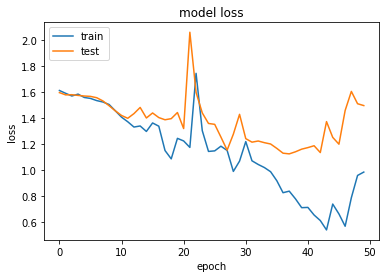

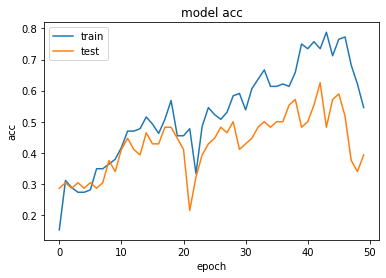

1/2 [==============>...............] - ETA: 0s - loss: 1.3441 - acc: 0.4062

2/2 [==============================] - ETA: 0s - loss: 1.4952 - acc: 0.3929

2/2 [==============================] - 0s 63ms/step - loss: 1.4952 - acc: 0.3929


[1.4951883554458618, 0.3928571343421936]

In [96]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(64, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(32, 5, activation="relu", 
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_36 (LSTM)               (None, None, 256)         365568    
_________________________________________________________________
dropout_89 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, None, 256)         327936    
_________________________________________________________________
average_pooling1d_24 (Averag (None, None, 256)         0         
_________________________________________________________________
dropout_90 (Dropout)         (None, None, 256)         0  

2/2 - 3s - loss: 1.6081 - acc: 0.2045 - val_loss: 1.5527 - val_acc: 0.3214


Epoch 2/50


2/2 - 0s - loss: 1.5627 - acc: 0.2879 - val_loss: 1.5562 - val_acc: 0.3214


Epoch 3/50
2/2 - 0s - loss: 1.6445 - acc: 0.2879 - val_loss: 1.5393 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.6228 - acc: 0.2879 - val_loss: 1.4999 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5029 - acc: 0.2879 - val_loss: 1.5131 - val_acc: 0.4107


Epoch 6/50


2/2 - 0s - loss: 1.4905 - acc: 0.4318 - val_loss: 1.5180 - val_acc: 0.5179


Epoch 7/50


2/2 - 0s - loss: 1.4836 - acc: 0.4621 - val_loss: 1.4994 - val_acc: 0.5893


Epoch 8/50


2/2 - 0s - loss: 1.4434 - acc: 0.5227 - val_loss: 1.4458 - val_acc: 0.4464


Epoch 9/50


2/2 - 0s - loss: 1.3784 - acc: 0.5076 - val_loss: 1.3719 - val_acc: 0.4286


Epoch 10/50


2/2 - 0s - loss: 1.2652 - acc: 0.5682 - val_loss: 1.2709 - val_acc: 0.4643


Epoch 11/50


2/2 - 0s - loss: 1.1170 - acc: 0.5606 - val_loss: 1.2174 - val_acc: 0.5179


Epoch 12/50


2/2 - 0s - loss: 1.0414 - acc: 0.5530 - val_loss: 1.1852 - val_acc: 0.4821


Epoch 13/50


2/2 - 0s - loss: 0.9760 - acc: 0.6061 - val_loss: 1.4013 - val_acc: 0.4107


Epoch 14/50


2/2 - 0s - loss: 1.0686 - acc: 0.5833 - val_loss: 1.2463 - val_acc: 0.4107


Epoch 15/50


2/2 - 0s - loss: 0.8259 - acc: 0.6970 - val_loss: 1.2815 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 0.9606 - acc: 0.6439 - val_loss: 1.3333 - val_acc: 0.4107


Epoch 17/50


2/2 - 0s - loss: 1.0744 - acc: 0.5833 - val_loss: 1.1915 - val_acc: 0.4821


Epoch 18/50


2/2 - 0s - loss: 0.9036 - acc: 0.6515 - val_loss: 1.0560 - val_acc: 0.5357


Epoch 19/50


2/2 - 0s - loss: 0.6596 - acc: 0.7652 - val_loss: 1.0612 - val_acc: 0.5893


Epoch 20/50


2/2 - 0s - loss: 0.6178 - acc: 0.7955 - val_loss: 1.1003 - val_acc: 0.6607


Epoch 21/50


2/2 - 0s - loss: 0.6135 - acc: 0.7500 - val_loss: 0.9951 - val_acc: 0.5893


Epoch 22/50


2/2 - 0s - loss: 0.5411 - acc: 0.7955 - val_loss: 1.0133 - val_acc: 0.5893


Epoch 23/50


2/2 - 0s - loss: 0.5463 - acc: 0.7500 - val_loss: 1.3000 - val_acc: 0.5536


Epoch 24/50


2/2 - 0s - loss: 0.6683 - acc: 0.7045 - val_loss: 0.9522 - val_acc: 0.6786


Epoch 25/50


2/2 - 0s - loss: 0.4925 - acc: 0.7955 - val_loss: 1.4811 - val_acc: 0.5357


Epoch 26/50


2/2 - 0s - loss: 1.1476 - acc: 0.6591 - val_loss: 1.0016 - val_acc: 0.6250


Epoch 27/50


2/2 - 0s - loss: 0.5415 - acc: 0.7955 - val_loss: 1.2546 - val_acc: 0.5179


Epoch 28/50


2/2 - 0s - loss: 0.5571 - acc: 0.7576 - val_loss: 1.5042 - val_acc: 0.5714


Epoch 29/50


2/2 - 0s - loss: 0.8163 - acc: 0.6591 - val_loss: 1.1999 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.5315 - acc: 0.7955 - val_loss: 1.0117 - val_acc: 0.6250


Epoch 31/50


2/2 - 0s - loss: 0.5018 - acc: 0.8561 - val_loss: 1.1999 - val_acc: 0.5536


Epoch 32/50


2/2 - 0s - loss: 0.7895 - acc: 0.7197 - val_loss: 1.0070 - val_acc: 0.5714


Epoch 33/50


2/2 - 0s - loss: 0.5550 - acc: 0.8182 - val_loss: 0.9998 - val_acc: 0.6250


Epoch 34/50


2/2 - 0s - loss: 0.4738 - acc: 0.8636 - val_loss: 1.0822 - val_acc: 0.5893


Epoch 35/50


2/2 - 0s - loss: 0.5135 - acc: 0.8409 - val_loss: 1.1380 - val_acc: 0.5714


Epoch 36/50


2/2 - 0s - loss: 0.5177 - acc: 0.8409 - val_loss: 1.1731 - val_acc: 0.5179


Epoch 37/50


2/2 - 0s - loss: 0.5043 - acc: 0.8636 - val_loss: 1.1726 - val_acc: 0.5714


Epoch 38/50


2/2 - 0s - loss: 0.5142 - acc: 0.8485 - val_loss: 1.0097 - val_acc: 0.6429


Epoch 39/50


2/2 - 0s - loss: 0.3600 - acc: 0.9015 - val_loss: 0.9978 - val_acc: 0.6429


Epoch 40/50


2/2 - 0s - loss: 0.3971 - acc: 0.8712 - val_loss: 1.0628 - val_acc: 0.5714


Epoch 41/50


2/2 - 0s - loss: 0.4383 - acc: 0.8258 - val_loss: 1.1119 - val_acc: 0.6071


Epoch 42/50


2/2 - 0s - loss: 0.3781 - acc: 0.8939 - val_loss: 1.1537 - val_acc: 0.5714


Epoch 43/50


2/2 - 0s - loss: 0.3480 - acc: 0.8939 - val_loss: 1.1513 - val_acc: 0.5893


Epoch 44/50


2/2 - 0s - loss: 0.3480 - acc: 0.8712 - val_loss: 1.1000 - val_acc: 0.6250


Epoch 45/50


2/2 - 0s - loss: 0.2911 - acc: 0.9015 - val_loss: 1.0549 - val_acc: 0.6250


Epoch 46/50


2/2 - 0s - loss: 0.2523 - acc: 0.8939 - val_loss: 1.0460 - val_acc: 0.6429


Epoch 47/50


2/2 - 0s - loss: 0.2418 - acc: 0.9167 - val_loss: 1.2008 - val_acc: 0.6607


Epoch 48/50


2/2 - 0s - loss: 0.2801 - acc: 0.8788 - val_loss: 1.2316 - val_acc: 0.5179


Epoch 49/50


2/2 - 0s - loss: 0.3331 - acc: 0.8712 - val_loss: 1.9441 - val_acc: 0.4464


Epoch 50/50


2/2 - 0s - loss: 1.0666 - acc: 0.6970 - val_loss: 1.4875 - val_acc: 0.5536


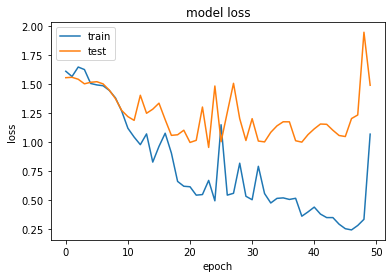

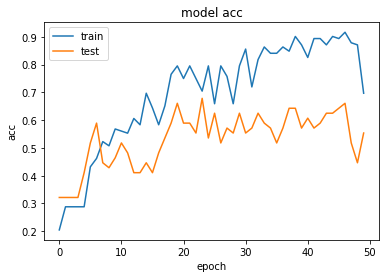

1/2 [==============>...............] - ETA: 0s - loss: 1.3846 - acc: 0.5312

2/2 [==============================] - 0s 32ms/step - loss: 1.4875 - acc: 0.5536


[1.487509846687317, 0.5535714030265808]

In [95]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(256, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(256, 5, activation="relu", 
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_39 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_94 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
global_average_pooling1d_23  (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 5)                 645

2/2 - 3s - loss: 1.6163 - acc: 0.1288 - val_loss: 1.5737 - val_acc: 0.3036


Epoch 2/50
2/2 - 0s - loss: 1.5560 - acc: 0.2879 - val_loss: 1.5607 - val_acc: 0.3036


Epoch 3/50


2/2 - 0s - loss: 1.5400 - acc: 0.2879 - val_loss: 1.5574 - val_acc: 0.3036


Epoch 4/50
2/2 - 0s - loss: 1.5344 - acc: 0.2879 - val_loss: 1.5447 - val_acc: 0.3036


Epoch 5/50


2/2 - 0s - loss: 1.5172 - acc: 0.3030 - val_loss: 1.5301 - val_acc: 0.3214


Epoch 6/50
2/2 - 0s - loss: 1.4920 - acc: 0.3333 - val_loss: 1.5127 - val_acc: 0.3036


Epoch 7/50


2/2 - 0s - loss: 1.4543 - acc: 0.4091 - val_loss: 1.4955 - val_acc: 0.3036


Epoch 8/50


2/2 - 0s - loss: 1.4238 - acc: 0.4697 - val_loss: 1.4800 - val_acc: 0.4107


Epoch 9/50


2/2 - 0s - loss: 1.3938 - acc: 0.5000 - val_loss: 1.4551 - val_acc: 0.4107


Epoch 10/50


2/2 - 0s - loss: 1.3592 - acc: 0.4318 - val_loss: 1.4636 - val_acc: 0.3929


Epoch 11/50
2/2 - 0s - loss: 1.3871 - acc: 0.3712 - val_loss: 1.4192 - val_acc: 0.4643


Epoch 12/50


2/2 - 0s - loss: 1.3205 - acc: 0.4394 - val_loss: 1.4081 - val_acc: 0.3929


Epoch 13/50
2/2 - 0s - loss: 1.2968 - acc: 0.4773 - val_loss: 1.4428 - val_acc: 0.3929


Epoch 14/50
2/2 - 0s - loss: 1.3213 - acc: 0.4545 - val_loss: 1.3759 - val_acc: 0.4643


Epoch 15/50
2/2 - 0s - loss: 1.2198 - acc: 0.5606 - val_loss: 1.3507 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.1710 - acc: 0.5985 - val_loss: 1.3354 - val_acc: 0.4464


Epoch 17/50
2/2 - 0s - loss: 1.1479 - acc: 0.5606 - val_loss: 1.3153 - val_acc: 0.4286


Epoch 18/50


2/2 - 0s - loss: 1.1098 - acc: 0.5682 - val_loss: 1.2867 - val_acc: 0.4464


Epoch 19/50


2/2 - 0s - loss: 1.0780 - acc: 0.5303 - val_loss: 1.2632 - val_acc: 0.4643


Epoch 20/50
2/2 - 0s - loss: 1.0461 - acc: 0.5530 - val_loss: 1.2676 - val_acc: 0.4464


Epoch 21/50


2/2 - 0s - loss: 1.0035 - acc: 0.5833 - val_loss: 1.2652 - val_acc: 0.5357


Epoch 22/50


2/2 - 0s - loss: 0.9848 - acc: 0.5985 - val_loss: 1.2473 - val_acc: 0.5179


Epoch 23/50


2/2 - 0s - loss: 1.0096 - acc: 0.5909 - val_loss: 1.2526 - val_acc: 0.5000


Epoch 24/50
2/2 - 0s - loss: 1.0223 - acc: 0.5833 - val_loss: 1.1730 - val_acc: 0.5000


Epoch 25/50


2/2 - 0s - loss: 0.8978 - acc: 0.6591 - val_loss: 1.1315 - val_acc: 0.4821


Epoch 26/50


2/2 - 0s - loss: 0.8274 - acc: 0.6970 - val_loss: 1.1097 - val_acc: 0.5357


Epoch 27/50


2/2 - 0s - loss: 0.7402 - acc: 0.7803 - val_loss: 1.1686 - val_acc: 0.5536


Epoch 28/50


2/2 - 0s - loss: 0.7080 - acc: 0.7879 - val_loss: 1.3461 - val_acc: 0.5536


Epoch 29/50
2/2 - 0s - loss: 0.7546 - acc: 0.7273 - val_loss: 1.2008 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.6356 - acc: 0.7879 - val_loss: 1.1811 - val_acc: 0.5000


Epoch 31/50
2/2 - 0s - loss: 0.6742 - acc: 0.7803 - val_loss: 1.0920 - val_acc: 0.5893


Epoch 32/50


2/2 - 0s - loss: 0.6106 - acc: 0.7879 - val_loss: 1.1939 - val_acc: 0.5357


Epoch 33/50
2/2 - 0s - loss: 0.6285 - acc: 0.7803 - val_loss: 1.2103 - val_acc: 0.6429


Epoch 34/50


2/2 - 0s - loss: 0.5917 - acc: 0.8030 - val_loss: 1.0762 - val_acc: 0.6429


Epoch 35/50
2/2 - 0s - loss: 0.5183 - acc: 0.8182 - val_loss: 1.1864 - val_acc: 0.6786


Epoch 36/50


2/2 - 0s - loss: 0.5312 - acc: 0.8030 - val_loss: 1.2572 - val_acc: 0.5714


Epoch 37/50
2/2 - 0s - loss: 0.6381 - acc: 0.7576 - val_loss: 1.2021 - val_acc: 0.6607


Epoch 38/50
2/2 - 0s - loss: 0.6329 - acc: 0.7803 - val_loss: 1.0155 - val_acc: 0.6607


Epoch 39/50


2/2 - 0s - loss: 0.4866 - acc: 0.8258 - val_loss: 0.9145 - val_acc: 0.6964


Epoch 40/50
2/2 - 0s - loss: 0.4435 - acc: 0.8636 - val_loss: 0.8947 - val_acc: 0.6250


Epoch 41/50


2/2 - 0s - loss: 0.4505 - acc: 0.8788 - val_loss: 0.8979 - val_acc: 0.6786


Epoch 42/50


2/2 - 0s - loss: 0.3904 - acc: 0.9015 - val_loss: 0.9542 - val_acc: 0.6786


Epoch 43/50


2/2 - 0s - loss: 0.3810 - acc: 0.8864 - val_loss: 0.9269 - val_acc: 0.6429


Epoch 44/50


2/2 - 0s - loss: 0.3088 - acc: 0.9091 - val_loss: 0.9701 - val_acc: 0.6429


Epoch 45/50


2/2 - 0s - loss: 0.3105 - acc: 0.8864 - val_loss: 1.0101 - val_acc: 0.6429


Epoch 46/50


2/2 - 0s - loss: 0.2592 - acc: 0.9091 - val_loss: 1.2544 - val_acc: 0.6786


Epoch 47/50


2/2 - 0s - loss: 0.3867 - acc: 0.8788 - val_loss: 1.1750 - val_acc: 0.6964


Epoch 48/50


2/2 - 0s - loss: 0.2782 - acc: 0.9015 - val_loss: 1.0827 - val_acc: 0.6071


Epoch 49/50


2/2 - 0s - loss: 0.2088 - acc: 0.9318 - val_loss: 1.3599 - val_acc: 0.5536


Epoch 50/50


2/2 - 0s - loss: 0.4627 - acc: 0.8561 - val_loss: 1.1812 - val_acc: 0.6786


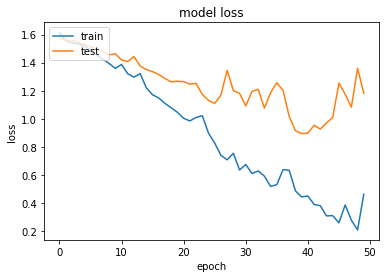

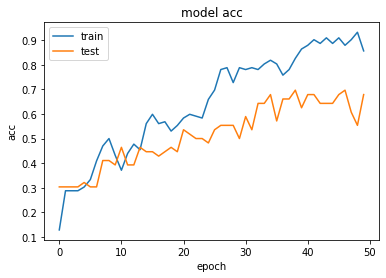

1/2 [==============>...............] - ETA: 0s - loss: 1.0445 - acc: 0.6875

2/2 [==============================] - 0s 15ms/step - loss: 1.1812 - acc: 0.6786


[1.1812487840652466, 0.6785714030265808]

In [97]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu",
                           padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(256, 5, activation="relu", 
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_43 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_100 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_28 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_101 (Dropout)        (None, None, 128)         0  

2/2 - 4s - loss: 1.6169 - acc: 0.1439 - val_loss: 1.5917 - val_acc: 0.2857


Epoch 2/50
2/2 - 0s - loss: 1.5828 - acc: 0.2803 - val_loss: 1.5773 - val_acc: 0.3036


Epoch 3/50


2/2 - 0s - loss: 1.5674 - acc: 0.3030 - val_loss: 1.5683 - val_acc: 0.2143


Epoch 4/50
2/2 - 0s - loss: 1.5661 - acc: 0.2273 - val_loss: 1.5589 - val_acc: 0.4286


Epoch 5/50


2/2 - 0s - loss: 1.5608 - acc: 0.3712 - val_loss: 1.5422 - val_acc: 0.4107


Epoch 6/50
2/2 - 0s - loss: 1.5354 - acc: 0.3788 - val_loss: 1.5356 - val_acc: 0.3750


Epoch 7/50
2/2 - 0s - loss: 1.5156 - acc: 0.3864 - val_loss: 1.5379 - val_acc: 0.3393


Epoch 8/50
2/2 - 0s - loss: 1.5195 - acc: 0.3939 - val_loss: 1.5381 - val_acc: 0.4107


Epoch 9/50
2/2 - 0s - loss: 1.5178 - acc: 0.3788 - val_loss: 1.5315 - val_acc: 0.4643


Epoch 10/50
2/2 - 0s - loss: 1.5020 - acc: 0.4242 - val_loss: 1.5121 - val_acc: 0.3929


Epoch 11/50
2/2 - 0s - loss: 1.4818 - acc: 0.4470 - val_loss: 1.4760 - val_acc: 0.4107


Epoch 12/50
2/2 - 0s - loss: 1.4392 - acc: 0.4167 - val_loss: 1.4422 - val_acc: 0.3929


Epoch 13/50


2/2 - 0s - loss: 1.3963 - acc: 0.4318 - val_loss: 1.4369 - val_acc: 0.4821


Epoch 14/50


2/2 - 0s - loss: 1.3716 - acc: 0.5076 - val_loss: 1.4491 - val_acc: 0.5179


Epoch 15/50


2/2 - 0s - loss: 1.3700 - acc: 0.5227 - val_loss: 1.3995 - val_acc: 0.4643


Epoch 16/50


2/2 - 0s - loss: 1.3103 - acc: 0.5227 - val_loss: 1.3369 - val_acc: 0.4821


Epoch 17/50
2/2 - 0s - loss: 1.2216 - acc: 0.5379 - val_loss: 1.2979 - val_acc: 0.4643


Epoch 18/50
2/2 - 0s - loss: 1.1620 - acc: 0.5606 - val_loss: 1.3261 - val_acc: 0.4643


Epoch 19/50
2/2 - 0s - loss: 1.2002 - acc: 0.5227 - val_loss: 1.3480 - val_acc: 0.4821


Epoch 20/50
2/2 - 0s - loss: 1.1857 - acc: 0.5379 - val_loss: 1.3122 - val_acc: 0.4643


Epoch 21/50
2/2 - 0s - loss: 1.0939 - acc: 0.5909 - val_loss: 1.2924 - val_acc: 0.4286


Epoch 22/50
2/2 - 0s - loss: 1.0338 - acc: 0.5909 - val_loss: 1.2466 - val_acc: 0.4107


Epoch 23/50
2/2 - 0s - loss: 0.9800 - acc: 0.6061 - val_loss: 1.1606 - val_acc: 0.4464


Epoch 24/50
2/2 - 0s - loss: 0.9331 - acc: 0.6136 - val_loss: 1.1196 - val_acc: 0.5179


Epoch 25/50
2/2 - 0s - loss: 0.8564 - acc: 0.6515 - val_loss: 1.1637 - val_acc: 0.4643


Epoch 26/50
2/2 - 0s - loss: 0.9189 - acc: 0.5909 - val_loss: 1.1359 - val_acc: 0.5179


Epoch 27/50
2/2 - 0s - loss: 0.8782 - acc: 0.6591 - val_loss: 1.1419 - val_acc: 0.5536


Epoch 28/50
2/2 - 0s - loss: 0.8888 - acc: 0.6136 - val_loss: 1.1282 - val_acc: 0.5714


Epoch 29/50


2/2 - 0s - loss: 0.8785 - acc: 0.6288 - val_loss: 1.0711 - val_acc: 0.5893


Epoch 30/50


2/2 - 0s - loss: 0.7824 - acc: 0.7727 - val_loss: 1.1489 - val_acc: 0.5000


Epoch 31/50


2/2 - 0s - loss: 0.8609 - acc: 0.6515 - val_loss: 1.2003 - val_acc: 0.4464


Epoch 32/50


2/2 - 0s - loss: 0.8959 - acc: 0.6439 - val_loss: 1.1399 - val_acc: 0.5000


Epoch 33/50


2/2 - 0s - loss: 0.7765 - acc: 0.6667 - val_loss: 1.0499 - val_acc: 0.5714


Epoch 34/50
2/2 - 0s - loss: 0.6219 - acc: 0.8030 - val_loss: 1.0581 - val_acc: 0.5536


Epoch 35/50


2/2 - 0s - loss: 0.6110 - acc: 0.7955 - val_loss: 1.0696 - val_acc: 0.5179


Epoch 36/50


2/2 - 0s - loss: 0.5968 - acc: 0.7803 - val_loss: 1.0734 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.6100 - acc: 0.7803 - val_loss: 1.1481 - val_acc: 0.5179


Epoch 38/50


2/2 - 0s - loss: 0.5872 - acc: 0.8182 - val_loss: 1.0898 - val_acc: 0.5714


Epoch 39/50
2/2 - 0s - loss: 0.5402 - acc: 0.8258 - val_loss: 1.0059 - val_acc: 0.5893


Epoch 40/50


2/2 - 0s - loss: 0.4602 - acc: 0.8485 - val_loss: 1.1708 - val_acc: 0.6071


Epoch 41/50


2/2 - 0s - loss: 0.5888 - acc: 0.7955 - val_loss: 0.9629 - val_acc: 0.6964


Epoch 42/50


2/2 - 0s - loss: 0.4687 - acc: 0.8106 - val_loss: 1.1376 - val_acc: 0.6429


Epoch 43/50


2/2 - 0s - loss: 0.6583 - acc: 0.7500 - val_loss: 1.1233 - val_acc: 0.6429


Epoch 44/50


2/2 - 0s - loss: 0.6628 - acc: 0.7879 - val_loss: 0.9709 - val_acc: 0.6964


Epoch 45/50


2/2 - 0s - loss: 0.5480 - acc: 0.8333 - val_loss: 0.7470 - val_acc: 0.7500


Epoch 46/50


2/2 - 0s - loss: 0.3603 - acc: 0.8788 - val_loss: 0.8588 - val_acc: 0.6429


Epoch 47/50
2/2 - 0s - loss: 0.5001 - acc: 0.8106 - val_loss: 0.8846 - val_acc: 0.6429


Epoch 48/50
2/2 - 0s - loss: 0.4620 - acc: 0.8258 - val_loss: 0.8074 - val_acc: 0.6964


Epoch 49/50


2/2 - 0s - loss: 0.3457 - acc: 0.9015 - val_loss: 0.8168 - val_acc: 0.6607


Epoch 50/50


2/2 - 0s - loss: 0.2940 - acc: 0.8788 - val_loss: 0.8275 - val_acc: 0.7500


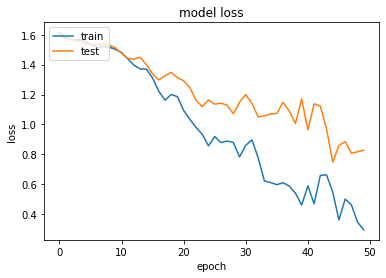

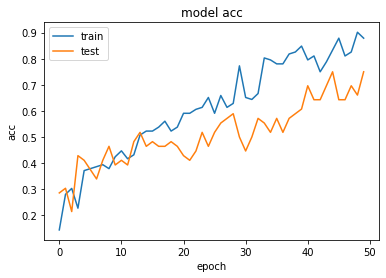

1/2 [==============>...............] - ETA: 0s - loss: 0.6917 - acc: 0.7812

2/2 [==============================] - 0s 18ms/step - loss: 0.8275 - acc: 0.7500


[0.8275436758995056, 0.75]

In [100]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_66 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_119 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_32 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_120 (Dropout)        (None, None, 128)         0  

2/2 - 4s - loss: 1.6089 - acc: 0.1894 - val_loss: 1.5849 - val_acc: 0.2857


Epoch 2/50
2/2 - 0s - loss: 1.5752 - acc: 0.2727 - val_loss: 1.5760 - val_acc: 0.2857


Epoch 3/50


2/2 - 0s - loss: 1.5632 - acc: 0.2727 - val_loss: 1.5712 - val_acc: 0.2857


Epoch 4/50


2/2 - 0s - loss: 1.5534 - acc: 0.2727 - val_loss: 1.5691 - val_acc: 0.2857


Epoch 5/50
2/2 - 0s - loss: 1.5441 - acc: 0.2727 - val_loss: 1.5687 - val_acc: 0.2857


Epoch 6/50
2/2 - 0s - loss: 1.5368 - acc: 0.2727 - val_loss: 1.5617 - val_acc: 0.2857


Epoch 7/50
2/2 - 0s - loss: 1.5212 - acc: 0.2879 - val_loss: 1.5534 - val_acc: 0.2857


Epoch 8/50
2/2 - 0s - loss: 1.5074 - acc: 0.2803 - val_loss: 1.5459 - val_acc: 0.2857


Epoch 9/50


2/2 - 0s - loss: 1.5006 - acc: 0.2727 - val_loss: 1.5469 - val_acc: 0.2857


Epoch 10/50
2/2 - 0s - loss: 1.5041 - acc: 0.2727 - val_loss: 1.5318 - val_acc: 0.3036


Epoch 11/50
2/2 - 0s - loss: 1.4705 - acc: 0.2803 - val_loss: 1.4857 - val_acc: 0.3036


Epoch 12/50


2/2 - 0s - loss: 1.3879 - acc: 0.2879 - val_loss: 1.4684 - val_acc: 0.3036


Epoch 13/50


2/2 - 0s - loss: 1.3572 - acc: 0.3561 - val_loss: 1.4526 - val_acc: 0.3571


Epoch 14/50


2/2 - 0s - loss: 1.3209 - acc: 0.4167 - val_loss: 1.4392 - val_acc: 0.4286


Epoch 15/50
2/2 - 0s - loss: 1.3011 - acc: 0.4848 - val_loss: 1.4117 - val_acc: 0.4107


Epoch 16/50
2/2 - 0s - loss: 1.2532 - acc: 0.5000 - val_loss: 1.3544 - val_acc: 0.3929


Epoch 17/50
2/2 - 0s - loss: 1.1880 - acc: 0.5758 - val_loss: 1.2857 - val_acc: 0.5357


Epoch 18/50
2/2 - 0s - loss: 1.0967 - acc: 0.5758 - val_loss: 1.2961 - val_acc: 0.5179


Epoch 19/50


2/2 - 0s - loss: 1.0954 - acc: 0.5682 - val_loss: 1.2987 - val_acc: 0.4464


Epoch 20/50


2/2 - 0s - loss: 1.0433 - acc: 0.5455 - val_loss: 1.2261 - val_acc: 0.4107


Epoch 21/50


2/2 - 0s - loss: 0.9925 - acc: 0.5758 - val_loss: 1.2286 - val_acc: 0.5000


Epoch 22/50
2/2 - 0s - loss: 1.0169 - acc: 0.5682 - val_loss: 1.2008 - val_acc: 0.5536


Epoch 23/50


2/2 - 0s - loss: 0.9676 - acc: 0.5833 - val_loss: 1.2225 - val_acc: 0.4821


Epoch 24/50


2/2 - 0s - loss: 0.9334 - acc: 0.6515 - val_loss: 1.2296 - val_acc: 0.5179


Epoch 25/50
2/2 - 0s - loss: 0.9271 - acc: 0.6212 - val_loss: 1.2350 - val_acc: 0.5000


Epoch 26/50


2/2 - 0s - loss: 0.8789 - acc: 0.6061 - val_loss: 1.2438 - val_acc: 0.4821


Epoch 27/50
2/2 - 0s - loss: 0.8227 - acc: 0.5985 - val_loss: 1.3104 - val_acc: 0.4286


Epoch 28/50
2/2 - 0s - loss: 0.8558 - acc: 0.5833 - val_loss: 1.1755 - val_acc: 0.5714


Epoch 29/50


2/2 - 0s - loss: 0.7878 - acc: 0.6667 - val_loss: 1.2556 - val_acc: 0.4643


Epoch 30/50


2/2 - 0s - loss: 0.9095 - acc: 0.6742 - val_loss: 1.1395 - val_acc: 0.5536


Epoch 31/50


2/2 - 0s - loss: 0.6925 - acc: 0.7045 - val_loss: 1.1281 - val_acc: 0.6071


Epoch 32/50
2/2 - 0s - loss: 0.6133 - acc: 0.7652 - val_loss: 1.1771 - val_acc: 0.5893


Epoch 33/50
2/2 - 0s - loss: 0.6373 - acc: 0.7576 - val_loss: 1.1638 - val_acc: 0.6250


Epoch 34/50
2/2 - 0s - loss: 0.6284 - acc: 0.7424 - val_loss: 1.0920 - val_acc: 0.6250


Epoch 35/50
2/2 - 0s - loss: 0.5991 - acc: 0.7879 - val_loss: 1.0410 - val_acc: 0.6429


Epoch 36/50


2/2 - 0s - loss: 0.5790 - acc: 0.7955 - val_loss: 1.0170 - val_acc: 0.6071


Epoch 37/50


2/2 - 0s - loss: 0.5652 - acc: 0.7879 - val_loss: 1.0337 - val_acc: 0.6071


Epoch 38/50


2/2 - 0s - loss: 0.5425 - acc: 0.8182 - val_loss: 1.0708 - val_acc: 0.5714


Epoch 39/50
2/2 - 0s - loss: 0.5913 - acc: 0.7955 - val_loss: 1.0448 - val_acc: 0.6250


Epoch 40/50
2/2 - 0s - loss: 0.5342 - acc: 0.7879 - val_loss: 1.1000 - val_acc: 0.6250


Epoch 41/50
2/2 - 0s - loss: 0.5511 - acc: 0.7879 - val_loss: 1.1145 - val_acc: 0.6071


Epoch 42/50
2/2 - 0s - loss: 0.5431 - acc: 0.7348 - val_loss: 1.0288 - val_acc: 0.6250


Epoch 43/50


2/2 - 0s - loss: 0.4178 - acc: 0.8561 - val_loss: 1.0831 - val_acc: 0.6071


Epoch 44/50


2/2 - 0s - loss: 0.4261 - acc: 0.8409 - val_loss: 1.1519 - val_acc: 0.6071


Epoch 45/50


2/2 - 0s - loss: 0.4211 - acc: 0.8712 - val_loss: 1.1765 - val_acc: 0.6071


Epoch 46/50
2/2 - 0s - loss: 0.3974 - acc: 0.8409 - val_loss: 1.1123 - val_acc: 0.6250


Epoch 47/50
2/2 - 0s - loss: 0.4197 - acc: 0.8333 - val_loss: 1.0432 - val_acc: 0.6429


Epoch 48/50
2/2 - 0s - loss: 0.3470 - acc: 0.8864 - val_loss: 1.0797 - val_acc: 0.5893


Epoch 49/50


2/2 - 0s - loss: 0.3163 - acc: 0.9015 - val_loss: 1.0964 - val_acc: 0.6429


Epoch 50/50
2/2 - 0s - loss: 0.3226 - acc: 0.8864 - val_loss: 0.9917 - val_acc: 0.6607


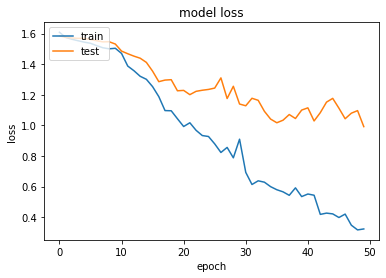

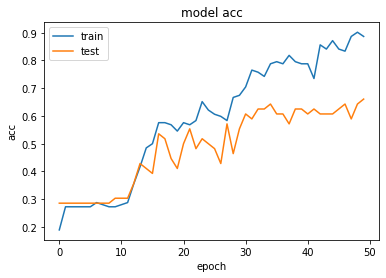

1/2 [==============>...............] - ETA: 0s - loss: 0.9374 - acc: 0.6562

2/2 [==============================] - 0s 19ms/step - loss: 0.9917 - acc: 0.6607


[0.9916957020759583, 0.6607142686843872]

In [109]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu",
                           padding="same")(x)
x = tf.keras.layers.AveragePooling1D(5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_68 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_121 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
lstm_69 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
dropout_122 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
lstm_70 (LSTM)               (None, None, 128)         131

2/2 - 5s - loss: 1.6083 - acc: 0.2273 - val_loss: 1.5725 - val_acc: 0.3393


Epoch 2/50


2/2 - 0s - loss: 1.5633 - acc: 0.3030 - val_loss: 1.5461 - val_acc: 0.3571


Epoch 3/50
2/2 - 0s - loss: 1.5352 - acc: 0.4242 - val_loss: 1.5331 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5257 - acc: 0.2879 - val_loss: 1.5246 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5072 - acc: 0.3030 - val_loss: 1.5119 - val_acc: 0.3214


Epoch 6/50


2/2 - 0s - loss: 1.4795 - acc: 0.3106 - val_loss: 1.5221 - val_acc: 0.3393


Epoch 7/50


2/2 - 0s - loss: 1.5101 - acc: 0.3333 - val_loss: 1.4585 - val_acc: 0.3750


Epoch 8/50


2/2 - 0s - loss: 1.4107 - acc: 0.4015 - val_loss: 1.4092 - val_acc: 0.5179


Epoch 9/50


2/2 - 0s - loss: 1.3379 - acc: 0.5152 - val_loss: 1.3944 - val_acc: 0.4464


Epoch 10/50


2/2 - 0s - loss: 1.3070 - acc: 0.4697 - val_loss: 1.3796 - val_acc: 0.4643


Epoch 11/50


2/2 - 0s - loss: 1.2985 - acc: 0.4621 - val_loss: 1.3484 - val_acc: 0.4464


Epoch 12/50


2/2 - 0s - loss: 1.2384 - acc: 0.5303 - val_loss: 1.3240 - val_acc: 0.4643


Epoch 13/50


2/2 - 0s - loss: 1.1755 - acc: 0.5909 - val_loss: 1.3433 - val_acc: 0.5000


Epoch 14/50


2/2 - 0s - loss: 1.2023 - acc: 0.5530 - val_loss: 1.3261 - val_acc: 0.4643


Epoch 15/50


2/2 - 0s - loss: 1.1692 - acc: 0.5530 - val_loss: 1.2212 - val_acc: 0.5357


Epoch 16/50


2/2 - 0s - loss: 1.0489 - acc: 0.6515 - val_loss: 1.1730 - val_acc: 0.5714


Epoch 17/50


2/2 - 0s - loss: 1.0562 - acc: 0.5606 - val_loss: 1.1518 - val_acc: 0.5357


Epoch 18/50


2/2 - 0s - loss: 1.0162 - acc: 0.5758 - val_loss: 1.3297 - val_acc: 0.4464


Epoch 19/50


2/2 - 0s - loss: 1.0871 - acc: 0.5606 - val_loss: 1.3748 - val_acc: 0.5179


Epoch 20/50


2/2 - 0s - loss: 1.0753 - acc: 0.5909 - val_loss: 1.2191 - val_acc: 0.5536


Epoch 21/50


2/2 - 0s - loss: 0.8931 - acc: 0.6970 - val_loss: 1.1909 - val_acc: 0.5000


Epoch 22/50


2/2 - 0s - loss: 0.8132 - acc: 0.7197 - val_loss: 1.1547 - val_acc: 0.5357


Epoch 23/50


2/2 - 0s - loss: 0.7779 - acc: 0.7424 - val_loss: 1.1765 - val_acc: 0.5536


Epoch 24/50


2/2 - 0s - loss: 0.8577 - acc: 0.6970 - val_loss: 1.1161 - val_acc: 0.5893


Epoch 25/50


2/2 - 0s - loss: 0.7278 - acc: 0.7197 - val_loss: 1.1254 - val_acc: 0.5536


Epoch 26/50


2/2 - 0s - loss: 0.6439 - acc: 0.8030 - val_loss: 1.1810 - val_acc: 0.5000


Epoch 27/50


2/2 - 0s - loss: 0.6420 - acc: 0.7727 - val_loss: 1.1372 - val_acc: 0.5714


Epoch 28/50


2/2 - 0s - loss: 0.6020 - acc: 0.7424 - val_loss: 1.1850 - val_acc: 0.5179


Epoch 29/50


2/2 - 0s - loss: 0.6502 - acc: 0.7424 - val_loss: 1.2509 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.7849 - acc: 0.7121 - val_loss: 1.2593 - val_acc: 0.5357


Epoch 31/50


2/2 - 0s - loss: 0.8134 - acc: 0.7045 - val_loss: 1.1449 - val_acc: 0.5179


Epoch 32/50


2/2 - 0s - loss: 0.5911 - acc: 0.7652 - val_loss: 1.1104 - val_acc: 0.5357


Epoch 33/50


2/2 - 0s - loss: 0.5083 - acc: 0.7652 - val_loss: 1.1468 - val_acc: 0.5893


Epoch 34/50


2/2 - 0s - loss: 0.5176 - acc: 0.8182 - val_loss: 1.1795 - val_acc: 0.5893


Epoch 35/50


2/2 - 0s - loss: 0.6594 - acc: 0.7348 - val_loss: 1.5297 - val_acc: 0.5357


Epoch 36/50


2/2 - 0s - loss: 1.0536 - acc: 0.5985 - val_loss: 1.2688 - val_acc: 0.5536


Epoch 37/50


2/2 - 0s - loss: 0.7423 - acc: 0.6667 - val_loss: 1.0140 - val_acc: 0.6250


Epoch 38/50


2/2 - 0s - loss: 0.5121 - acc: 0.8258 - val_loss: 1.0877 - val_acc: 0.5357


Epoch 39/50


2/2 - 0s - loss: 0.6218 - acc: 0.7273 - val_loss: 1.2716 - val_acc: 0.5536


Epoch 40/50


2/2 - 0s - loss: 0.8366 - acc: 0.6288 - val_loss: 1.4713 - val_acc: 0.4821


Epoch 41/50


2/2 - 0s - loss: 1.0158 - acc: 0.5909 - val_loss: 1.2342 - val_acc: 0.4643


Epoch 42/50


2/2 - 0s - loss: 0.6687 - acc: 0.6970 - val_loss: 1.0994 - val_acc: 0.5893


Epoch 43/50
2/2 - 0s - loss: 0.5372 - acc: 0.7879 - val_loss: 1.1754 - val_acc: 0.5357


Epoch 44/50


2/2 - 0s - loss: 0.6094 - acc: 0.7727 - val_loss: 1.4319 - val_acc: 0.5179


Epoch 45/50


2/2 - 0s - loss: 0.8751 - acc: 0.6667 - val_loss: 1.4346 - val_acc: 0.5179


Epoch 46/50


2/2 - 0s - loss: 0.8826 - acc: 0.6515 - val_loss: 1.2434 - val_acc: 0.5179


Epoch 47/50


2/2 - 0s - loss: 0.6671 - acc: 0.6894 - val_loss: 1.1104 - val_acc: 0.5893


Epoch 48/50


2/2 - 0s - loss: 0.5326 - acc: 0.8030 - val_loss: 1.0678 - val_acc: 0.5714


Epoch 49/50


2/2 - 0s - loss: 0.4984 - acc: 0.8333 - val_loss: 1.0814 - val_acc: 0.5893


Epoch 50/50


2/2 - 0s - loss: 0.5113 - acc: 0.8182 - val_loss: 1.1982 - val_acc: 0.6250


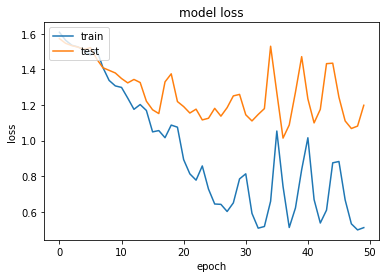

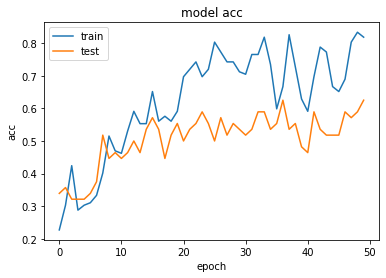

1/2 [==============>...............] - ETA: 0s - loss: 1.3041 - acc: 0.6250

2/2 [==============================] - 0s 28ms/step - loss: 1.1982 - acc: 0.6250


[1.1982362270355225, 0.625]

In [110]:
int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu",
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
#                            padding="same")(x)
# x = tf.keras.layers.AveragePooling1D(5)(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

model.compile("Adam", "categorical_crossentropy", metrics=["acc"])

hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                 validation_data=(test_x, test_y), verbose=2)

plot_hist(hist)

model.evaluate(test_x, test_y, verbose=1)

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_77 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_130 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_36 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_131 (Dropout)        (None, None, 128)         0  

2/2 - 4s - loss: 1.6050 - acc: 0.2348 - val_loss: 1.5830 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5749 - acc: 0.2879 - val_loss: 1.5692 - val_acc: 0.3393


Epoch 3/50


2/2 - 0s - loss: 1.5631 - acc: 0.2500 - val_loss: 1.5619 - val_acc: 0.3036


Epoch 4/50
2/2 - 0s - loss: 1.5479 - acc: 0.2879 - val_loss: 1.5558 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5367 - acc: 0.2879 - val_loss: 1.5499 - val_acc: 0.3036


Epoch 6/50
2/2 - 0s - loss: 1.5259 - acc: 0.2727 - val_loss: 1.5525 - val_acc: 0.2857


Epoch 7/50


2/2 - 0s - loss: 1.5230 - acc: 0.2955 - val_loss: 1.5623 - val_acc: 0.2857


Epoch 8/50
2/2 - 0s - loss: 1.5340 - acc: 0.2879 - val_loss: 1.5595 - val_acc: 0.2857


Epoch 9/50


2/2 - 0s - loss: 1.5136 - acc: 0.2727 - val_loss: 1.5381 - val_acc: 0.3036


Epoch 10/50


2/2 - 0s - loss: 1.4946 - acc: 0.2727 - val_loss: 1.5161 - val_acc: 0.3036


Epoch 11/50


2/2 - 0s - loss: 1.4640 - acc: 0.2727 - val_loss: 1.4489 - val_acc: 0.3214


Epoch 12/50


2/2 - 0s - loss: 1.3777 - acc: 0.3333 - val_loss: 1.4018 - val_acc: 0.3393


Epoch 13/50
2/2 - 0s - loss: 1.3173 - acc: 0.3561 - val_loss: 1.3852 - val_acc: 0.3571


Epoch 14/50


2/2 - 0s - loss: 1.3137 - acc: 0.3561 - val_loss: 1.3774 - val_acc: 0.4643


Epoch 15/50
2/2 - 0s - loss: 1.2751 - acc: 0.5227 - val_loss: 1.4176 - val_acc: 0.3929


Epoch 16/50


2/2 - 0s - loss: 1.3251 - acc: 0.5379 - val_loss: 1.4151 - val_acc: 0.3393


Epoch 17/50
2/2 - 0s - loss: 1.3163 - acc: 0.4545 - val_loss: 1.3269 - val_acc: 0.4107


Epoch 18/50


2/2 - 0s - loss: 1.2190 - acc: 0.5530 - val_loss: 1.2654 - val_acc: 0.4821


Epoch 19/50
2/2 - 0s - loss: 1.1630 - acc: 0.4848 - val_loss: 1.4817 - val_acc: 0.3750


Epoch 20/50
2/2 - 0s - loss: 1.3635 - acc: 0.3788 - val_loss: 1.6539 - val_acc: 0.3750


Epoch 21/50
2/2 - 0s - loss: 1.5371 - acc: 0.3106 - val_loss: 1.4416 - val_acc: 0.3929


Epoch 22/50


2/2 - 0s - loss: 1.3251 - acc: 0.3636 - val_loss: 1.2804 - val_acc: 0.4107


Epoch 23/50


2/2 - 0s - loss: 1.1292 - acc: 0.5152 - val_loss: 1.2392 - val_acc: 0.5536


Epoch 24/50


2/2 - 0s - loss: 1.0806 - acc: 0.6288 - val_loss: 1.2522 - val_acc: 0.4821


Epoch 25/50
2/2 - 0s - loss: 1.1023 - acc: 0.5833 - val_loss: 1.2667 - val_acc: 0.4107


Epoch 26/50


2/2 - 0s - loss: 1.1084 - acc: 0.4848 - val_loss: 1.2462 - val_acc: 0.4107


Epoch 27/50


2/2 - 0s - loss: 1.0656 - acc: 0.5152 - val_loss: 1.2023 - val_acc: 0.4464


Epoch 28/50


2/2 - 0s - loss: 0.9907 - acc: 0.5227 - val_loss: 1.1699 - val_acc: 0.4643


Epoch 29/50
2/2 - 0s - loss: 0.9203 - acc: 0.5455 - val_loss: 1.1683 - val_acc: 0.4286


Epoch 30/50
2/2 - 0s - loss: 0.9075 - acc: 0.5758 - val_loss: 1.1580 - val_acc: 0.4821


Epoch 31/50
2/2 - 0s - loss: 0.8893 - acc: 0.7045 - val_loss: 1.1160 - val_acc: 0.5179


Epoch 32/50
2/2 - 0s - loss: 0.8416 - acc: 0.6136 - val_loss: 1.0545 - val_acc: 0.5179


Epoch 33/50
2/2 - 0s - loss: 0.7602 - acc: 0.6136 - val_loss: 1.0715 - val_acc: 0.4821


Epoch 34/50
2/2 - 0s - loss: 0.7621 - acc: 0.6364 - val_loss: 1.1150 - val_acc: 0.4821


Epoch 35/50
2/2 - 0s - loss: 0.7723 - acc: 0.6515 - val_loss: 1.0585 - val_acc: 0.5536


Epoch 36/50
2/2 - 0s - loss: 0.6713 - acc: 0.6591 - val_loss: 1.0543 - val_acc: 0.6071


Epoch 37/50
2/2 - 0s - loss: 0.6259 - acc: 0.7727 - val_loss: 1.0825 - val_acc: 0.5357


Epoch 38/50
2/2 - 0s - loss: 0.6474 - acc: 0.7045 - val_loss: 1.1115 - val_acc: 0.5179


Epoch 39/50
2/2 - 0s - loss: 0.6564 - acc: 0.6439 - val_loss: 1.0524 - val_acc: 0.5357


Epoch 40/50


2/2 - 0s - loss: 0.6145 - acc: 0.6515 - val_loss: 1.0782 - val_acc: 0.5357


Epoch 41/50


2/2 - 0s - loss: 0.6308 - acc: 0.6742 - val_loss: 1.0162 - val_acc: 0.5893


Epoch 42/50


2/2 - 0s - loss: 0.5478 - acc: 0.7803 - val_loss: 1.0326 - val_acc: 0.5536


Epoch 43/50


2/2 - 0s - loss: 0.5413 - acc: 0.7652 - val_loss: 1.0490 - val_acc: 0.5357


Epoch 44/50
2/2 - 0s - loss: 0.5629 - acc: 0.7500 - val_loss: 1.0678 - val_acc: 0.5536


Epoch 45/50
2/2 - 0s - loss: 0.5954 - acc: 0.7500 - val_loss: 0.9851 - val_acc: 0.5536


Epoch 46/50
2/2 - 0s - loss: 0.5307 - acc: 0.7652 - val_loss: 1.2193 - val_acc: 0.5536


Epoch 47/50


2/2 - 0s - loss: 0.7835 - acc: 0.7500 - val_loss: 1.2708 - val_acc: 0.5714


Epoch 48/50


2/2 - 0s - loss: 0.8538 - acc: 0.7500 - val_loss: 1.1812 - val_acc: 0.5536


Epoch 49/50


2/2 - 0s - loss: 0.7039 - acc: 0.7500 - val_loss: 1.0070 - val_acc: 0.6429


Epoch 50/50


2/2 - 0s - loss: 0.4950 - acc: 0.8030 - val_loss: 0.8920 - val_acc: 0.5893


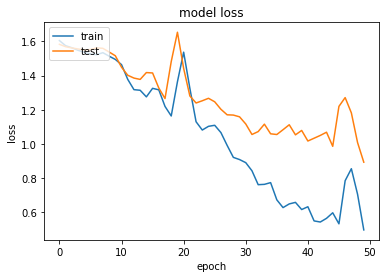

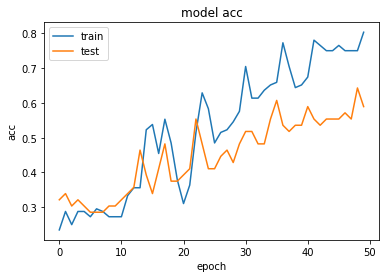

1/2 [==============>...............] - ETA: 0s - loss: 0.8700 - acc: 0.5938

2/2 [==============================] - 0s 19ms/step - loss: 0.8920 - acc: 0.5893


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_79 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_132 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_37 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_133 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6093 - acc: 0.2348 - val_loss: 1.5833 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5740 - acc: 0.4015 - val_loss: 1.5613 - val_acc: 0.3036


Epoch 3/50


2/2 - 0s - loss: 1.5507 - acc: 0.2879 - val_loss: 1.5531 - val_acc: 0.2857


Epoch 4/50


2/2 - 0s - loss: 1.5488 - acc: 0.2727 - val_loss: 1.5534 - val_acc: 0.2857


Epoch 5/50


2/2 - 0s - loss: 1.5468 - acc: 0.2727 - val_loss: 1.5471 - val_acc: 0.2857


Epoch 6/50
2/2 - 0s - loss: 1.5406 - acc: 0.2727 - val_loss: 1.5301 - val_acc: 0.3214


Epoch 7/50


2/2 - 0s - loss: 1.5297 - acc: 0.2955 - val_loss: 1.5236 - val_acc: 0.4107


Epoch 8/50
2/2 - 0s - loss: 1.5085 - acc: 0.3485 - val_loss: 1.5195 - val_acc: 0.3571


Epoch 9/50


2/2 - 0s - loss: 1.4957 - acc: 0.3561 - val_loss: 1.5154 - val_acc: 0.3214


Epoch 10/50
2/2 - 0s - loss: 1.4803 - acc: 0.3485 - val_loss: 1.5120 - val_acc: 0.3750


Epoch 11/50
2/2 - 0s - loss: 1.4730 - acc: 0.3864 - val_loss: 1.5054 - val_acc: 0.4286


Epoch 12/50
2/2 - 0s - loss: 1.4516 - acc: 0.4242 - val_loss: 1.4924 - val_acc: 0.5357


Epoch 13/50
2/2 - 0s - loss: 1.4222 - acc: 0.4394 - val_loss: 1.4684 - val_acc: 0.4464


Epoch 14/50


2/2 - 0s - loss: 1.3919 - acc: 0.4394 - val_loss: 1.4544 - val_acc: 0.3750


Epoch 15/50


2/2 - 0s - loss: 1.3939 - acc: 0.4015 - val_loss: 1.4533 - val_acc: 0.3750


Epoch 16/50


2/2 - 0s - loss: 1.3782 - acc: 0.4091 - val_loss: 1.4252 - val_acc: 0.4286


Epoch 17/50


2/2 - 0s - loss: 1.3302 - acc: 0.4394 - val_loss: 1.4225 - val_acc: 0.5179


Epoch 18/50
2/2 - 0s - loss: 1.2737 - acc: 0.5227 - val_loss: 1.4502 - val_acc: 0.4643


Epoch 19/50
2/2 - 0s - loss: 1.2879 - acc: 0.5985 - val_loss: 1.4486 - val_acc: 0.3393


Epoch 20/50
2/2 - 0s - loss: 1.2912 - acc: 0.5227 - val_loss: 1.3748 - val_acc: 0.5357


Epoch 21/50


2/2 - 0s - loss: 1.2266 - acc: 0.5606 - val_loss: 1.2869 - val_acc: 0.5179


Epoch 22/50


2/2 - 0s - loss: 1.1159 - acc: 0.5682 - val_loss: 1.2409 - val_acc: 0.5357


Epoch 23/50


2/2 - 0s - loss: 1.0277 - acc: 0.6591 - val_loss: 1.2319 - val_acc: 0.4643


Epoch 24/50


2/2 - 0s - loss: 1.0294 - acc: 0.5909 - val_loss: 1.2252 - val_acc: 0.4286


Epoch 25/50
2/2 - 0s - loss: 0.9993 - acc: 0.6136 - val_loss: 1.1908 - val_acc: 0.5000


Epoch 26/50


2/2 - 0s - loss: 0.9244 - acc: 0.6439 - val_loss: 1.2075 - val_acc: 0.4464


Epoch 27/50


2/2 - 0s - loss: 0.9140 - acc: 0.6364 - val_loss: 1.2539 - val_acc: 0.4107


Epoch 28/50


2/2 - 0s - loss: 0.9235 - acc: 0.6364 - val_loss: 1.2513 - val_acc: 0.5000


Epoch 29/50
2/2 - 0s - loss: 0.8976 - acc: 0.6364 - val_loss: 1.1251 - val_acc: 0.5000


Epoch 30/50
2/2 - 0s - loss: 0.7374 - acc: 0.7197 - val_loss: 1.0820 - val_acc: 0.5000


Epoch 31/50


2/2 - 0s - loss: 0.7392 - acc: 0.7045 - val_loss: 1.0906 - val_acc: 0.4643


Epoch 32/50


2/2 - 0s - loss: 0.7580 - acc: 0.7197 - val_loss: 1.0629 - val_acc: 0.5179


Epoch 33/50


2/2 - 0s - loss: 0.6902 - acc: 0.7045 - val_loss: 1.0677 - val_acc: 0.5893


Epoch 34/50


2/2 - 0s - loss: 0.6683 - acc: 0.7197 - val_loss: 1.2004 - val_acc: 0.5357


Epoch 35/50
2/2 - 0s - loss: 0.8197 - acc: 0.6439 - val_loss: 1.1774 - val_acc: 0.5357


Epoch 36/50


2/2 - 0s - loss: 0.8428 - acc: 0.6288 - val_loss: 0.9839 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.6218 - acc: 0.7803 - val_loss: 1.0011 - val_acc: 0.6071


Epoch 38/50


2/2 - 0s - loss: 0.6238 - acc: 0.7576 - val_loss: 0.9286 - val_acc: 0.6429


Epoch 39/50


2/2 - 0s - loss: 0.5552 - acc: 0.7576 - val_loss: 0.8447 - val_acc: 0.5893


Epoch 40/50


2/2 - 0s - loss: 0.5181 - acc: 0.7955 - val_loss: 0.9136 - val_acc: 0.5893


Epoch 41/50
2/2 - 0s - loss: 0.5869 - acc: 0.7879 - val_loss: 0.9222 - val_acc: 0.5714


Epoch 42/50
2/2 - 0s - loss: 0.6218 - acc: 0.7652 - val_loss: 0.8515 - val_acc: 0.6250


Epoch 43/50
2/2 - 0s - loss: 0.5485 - acc: 0.7727 - val_loss: 0.8237 - val_acc: 0.6786


Epoch 44/50
2/2 - 0s - loss: 0.5161 - acc: 0.7727 - val_loss: 0.8430 - val_acc: 0.6786


Epoch 45/50


2/2 - 0s - loss: 0.4912 - acc: 0.7879 - val_loss: 0.9010 - val_acc: 0.6429


Epoch 46/50


2/2 - 0s - loss: 0.4797 - acc: 0.7879 - val_loss: 0.8866 - val_acc: 0.5893


Epoch 47/50


2/2 - 0s - loss: 0.4470 - acc: 0.8409 - val_loss: 0.9038 - val_acc: 0.6250


Epoch 48/50


2/2 - 0s - loss: 0.3953 - acc: 0.8636 - val_loss: 0.8905 - val_acc: 0.5893


Epoch 49/50


2/2 - 0s - loss: 0.3584 - acc: 0.8561 - val_loss: 0.9462 - val_acc: 0.6607


Epoch 50/50


2/2 - 0s - loss: 0.3913 - acc: 0.8485 - val_loss: 1.2407 - val_acc: 0.6429


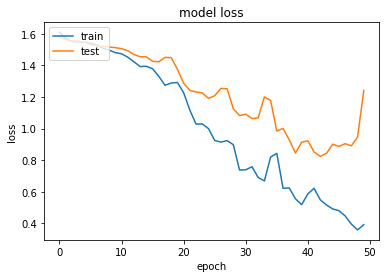

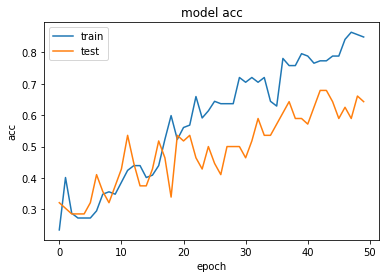

1/2 [==============>...............] - ETA: 0s - loss: 0.6926 - acc: 0.7500

2/2 [==============================] - 0s 18ms/step - loss: 1.2407 - acc: 0.6429


Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_81 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_134 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_38 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_135 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6092 - acc: 0.2121 - val_loss: 1.5824 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5762 - acc: 0.3485 - val_loss: 1.5583 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5519 - acc: 0.2955 - val_loss: 1.5430 - val_acc: 0.3214


Epoch 4/50


2/2 - 0s - loss: 1.5505 - acc: 0.2879 - val_loss: 1.5397 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5596 - acc: 0.2879 - val_loss: 1.5366 - val_acc: 0.3214


Epoch 6/50


2/2 - 0s - loss: 1.5418 - acc: 0.2955 - val_loss: 1.5422 - val_acc: 0.3571


Epoch 7/50
2/2 - 0s - loss: 1.5284 - acc: 0.3409 - val_loss: 1.5444 - val_acc: 0.3571


Epoch 8/50


2/2 - 0s - loss: 1.5232 - acc: 0.4242 - val_loss: 1.5346 - val_acc: 0.3393


Epoch 9/50
2/2 - 0s - loss: 1.5019 - acc: 0.4545 - val_loss: 1.5107 - val_acc: 0.3571


Epoch 10/50
2/2 - 0s - loss: 1.4671 - acc: 0.4621 - val_loss: 1.4786 - val_acc: 0.3571


Epoch 11/50


2/2 - 0s - loss: 1.4136 - acc: 0.4167 - val_loss: 1.4625 - val_acc: 0.3571


Epoch 12/50


2/2 - 0s - loss: 1.3843 - acc: 0.4242 - val_loss: 1.4536 - val_acc: 0.3750


Epoch 13/50


2/2 - 0s - loss: 1.3611 - acc: 0.4318 - val_loss: 1.4440 - val_acc: 0.3214


Epoch 14/50


2/2 - 0s - loss: 1.3404 - acc: 0.3864 - val_loss: 1.4314 - val_acc: 0.3036


Epoch 15/50


2/2 - 0s - loss: 1.3191 - acc: 0.3864 - val_loss: 1.4025 - val_acc: 0.3214


Epoch 16/50


2/2 - 0s - loss: 1.2258 - acc: 0.4697 - val_loss: 1.4036 - val_acc: 0.3571


Epoch 17/50


2/2 - 0s - loss: 1.2198 - acc: 0.5909 - val_loss: 1.3552 - val_acc: 0.4107


Epoch 18/50


2/2 - 0s - loss: 1.1745 - acc: 0.5530 - val_loss: 1.3382 - val_acc: 0.4286


Epoch 19/50


2/2 - 0s - loss: 1.1229 - acc: 0.5606 - val_loss: 1.3492 - val_acc: 0.4107


Epoch 20/50


2/2 - 0s - loss: 1.1038 - acc: 0.5758 - val_loss: 1.3765 - val_acc: 0.4286


Epoch 21/50


2/2 - 0s - loss: 1.0993 - acc: 0.5909 - val_loss: 1.2815 - val_acc: 0.4286


Epoch 22/50


2/2 - 0s - loss: 0.9978 - acc: 0.6515 - val_loss: 1.2983 - val_acc: 0.4286


Epoch 23/50


2/2 - 0s - loss: 0.9962 - acc: 0.5833 - val_loss: 1.3013 - val_acc: 0.4286


Epoch 24/50


2/2 - 0s - loss: 1.0155 - acc: 0.6136 - val_loss: 1.2105 - val_acc: 0.4821


Epoch 25/50


2/2 - 0s - loss: 0.9091 - acc: 0.6288 - val_loss: 1.2044 - val_acc: 0.4286


Epoch 26/50


2/2 - 0s - loss: 0.8840 - acc: 0.6364 - val_loss: 1.1950 - val_acc: 0.4821


Epoch 27/50
2/2 - 0s - loss: 0.8468 - acc: 0.6742 - val_loss: 1.2346 - val_acc: 0.4643


Epoch 28/50


2/2 - 0s - loss: 0.8428 - acc: 0.6364 - val_loss: 1.2531 - val_acc: 0.4464


Epoch 29/50
2/2 - 0s - loss: 0.8112 - acc: 0.7045 - val_loss: 1.2805 - val_acc: 0.5179


Epoch 30/50


2/2 - 0s - loss: 0.7616 - acc: 0.7348 - val_loss: 1.4498 - val_acc: 0.4821


Epoch 31/50


2/2 - 0s - loss: 0.8718 - acc: 0.6591 - val_loss: 1.3821 - val_acc: 0.5000


Epoch 32/50


2/2 - 0s - loss: 0.8752 - acc: 0.6515 - val_loss: 1.1131 - val_acc: 0.5536


Epoch 33/50


2/2 - 0s - loss: 0.7013 - acc: 0.7197 - val_loss: 1.1678 - val_acc: 0.4464


Epoch 34/50


2/2 - 0s - loss: 0.7533 - acc: 0.7045 - val_loss: 1.0528 - val_acc: 0.5536


Epoch 35/50


2/2 - 0s - loss: 0.5825 - acc: 0.7803 - val_loss: 1.1808 - val_acc: 0.5536


Epoch 36/50


2/2 - 0s - loss: 0.5952 - acc: 0.8030 - val_loss: 1.1945 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.6133 - acc: 0.7803 - val_loss: 1.2022 - val_acc: 0.5000


Epoch 38/50


2/2 - 0s - loss: 0.6130 - acc: 0.7500 - val_loss: 1.3460 - val_acc: 0.5000


Epoch 39/50


2/2 - 0s - loss: 0.7109 - acc: 0.7652 - val_loss: 1.1899 - val_acc: 0.5357


Epoch 40/50


2/2 - 0s - loss: 0.5913 - acc: 0.8182 - val_loss: 1.0536 - val_acc: 0.5714


Epoch 41/50

2/2 - 0s - loss: 0.4888 - acc: 0.8106 - val_loss: 1.0627 - val_acc: 0.5714


Epoch 42/50


2/2 - 0s - loss: 0.4941 - acc: 0.8030 - val_loss: 1.2029 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.5677 - acc: 0.8030 - val_loss: 1.1998 - val_acc: 0.5893


Epoch 44/50


2/2 - 0s - loss: 0.5077 - acc: 0.8030 - val_loss: 1.1175 - val_acc: 0.5893


Epoch 45/50


2/2 - 0s - loss: 0.4834 - acc: 0.8182 - val_loss: 1.1636 - val_acc: 0.5357


Epoch 46/50


2/2 - 0s - loss: 0.6064 - acc: 0.7424 - val_loss: 1.1830 - val_acc: 0.5893


Epoch 47/50


2/2 - 0s - loss: 0.6584 - acc: 0.7500 - val_loss: 1.0302 - val_acc: 0.5893


Epoch 48/50
2/2 - 0s - loss: 0.4490 - acc: 0.8258 - val_loss: 1.1439 - val_acc: 0.5893


Epoch 49/50


2/2 - 0s - loss: 0.4729 - acc: 0.8409 - val_loss: 1.2021 - val_acc: 0.5714


Epoch 50/50


2/2 - 0s - loss: 0.5316 - acc: 0.8182 - val_loss: 1.1473 - val_acc: 0.6071


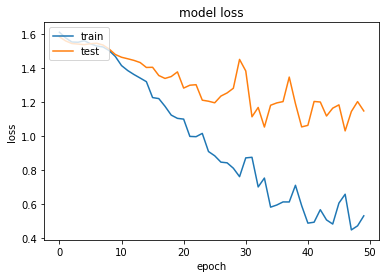

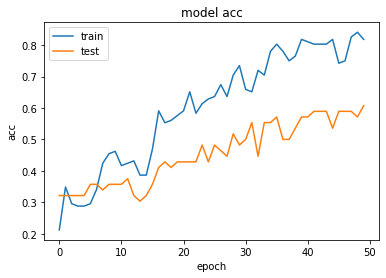

1/2 [==============>...............] - ETA: 0s - loss: 0.9198 - acc: 0.5938

2/2 [==============================] - 0s 18ms/step - loss: 1.1473 - acc: 0.6071


Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_83 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_136 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_39 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_137 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6007 - acc: 0.2576 - val_loss: 1.5721 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5621 - acc: 0.3182 - val_loss: 1.5415 - val_acc: 0.2857


Epoch 3/50


2/2 - 0s - loss: 1.5363 - acc: 0.3712 - val_loss: 1.5305 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5353 - acc: 0.2879 - val_loss: 1.5324 - val_acc: 0.3393


Epoch 5/50


2/2 - 0s - loss: 1.5219 - acc: 0.3636 - val_loss: 1.5328 - val_acc: 0.3036


Epoch 6/50
2/2 - 0s - loss: 1.5215 - acc: 0.2879 - val_loss: 1.5319 - val_acc: 0.3036


Epoch 7/50


2/2 - 0s - loss: 1.5111 - acc: 0.2727 - val_loss: 1.5303 - val_acc: 0.3036


Epoch 8/50
2/2 - 0s - loss: 1.5023 - acc: 0.2803 - val_loss: 1.5148 - val_acc: 0.3214


Epoch 9/50


2/2 - 0s - loss: 1.4765 - acc: 0.3030 - val_loss: 1.4828 - val_acc: 0.3214


Epoch 10/50


2/2 - 0s - loss: 1.4506 - acc: 0.3182 - val_loss: 1.4631 - val_acc: 0.3036


Epoch 11/50


2/2 - 0s - loss: 1.4408 - acc: 0.3106 - val_loss: 1.4364 - val_acc: 0.3571


Epoch 12/50
2/2 - 0s - loss: 1.4033 - acc: 0.3409 - val_loss: 1.3828 - val_acc: 0.4107


Epoch 13/50
2/2 - 0s - loss: 1.3171 - acc: 0.5076 - val_loss: 1.3756 - val_acc: 0.4643


Epoch 14/50


2/2 - 0s - loss: 1.3218 - acc: 0.4848 - val_loss: 1.3438 - val_acc: 0.4464


Epoch 15/50


2/2 - 0s - loss: 1.2898 - acc: 0.4470 - val_loss: 1.3029 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.2414 - acc: 0.4470 - val_loss: 1.2651 - val_acc: 0.4464


Epoch 17/50
2/2 - 0s - loss: 1.2057 - acc: 0.4394 - val_loss: 1.2263 - val_acc: 0.4286


Epoch 18/50


2/2 - 0s - loss: 1.1686 - acc: 0.4318 - val_loss: 1.1998 - val_acc: 0.4286


Epoch 19/50


2/2 - 0s - loss: 1.1158 - acc: 0.4545 - val_loss: 1.1680 - val_acc: 0.5000


Epoch 20/50


2/2 - 0s - loss: 1.0653 - acc: 0.5833 - val_loss: 1.1530 - val_acc: 0.5000


Epoch 21/50


2/2 - 0s - loss: 1.0175 - acc: 0.6212 - val_loss: 1.2739 - val_acc: 0.4286


Epoch 22/50


2/2 - 0s - loss: 1.1412 - acc: 0.4924 - val_loss: 1.2375 - val_acc: 0.3929


Epoch 23/50


2/2 - 0s - loss: 1.0767 - acc: 0.4773 - val_loss: 1.0972 - val_acc: 0.4107


Epoch 24/50


2/2 - 0s - loss: 0.8988 - acc: 0.6515 - val_loss: 1.1143 - val_acc: 0.4821


Epoch 25/50
2/2 - 0s - loss: 0.9392 - acc: 0.6212 - val_loss: 1.0946 - val_acc: 0.5536


Epoch 26/50
2/2 - 0s - loss: 0.9212 - acc: 0.6818 - val_loss: 1.1126 - val_acc: 0.5000


Epoch 27/50
2/2 - 0s - loss: 0.9150 - acc: 0.7197 - val_loss: 1.0790 - val_acc: 0.5536


Epoch 28/50
2/2 - 0s - loss: 0.8716 - acc: 0.7424 - val_loss: 1.0892 - val_acc: 0.5893


Epoch 29/50
2/2 - 0s - loss: 0.8544 - acc: 0.7121 - val_loss: 1.0457 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.7887 - acc: 0.7652 - val_loss: 1.0731 - val_acc: 0.5536


Epoch 31/50


2/2 - 0s - loss: 0.8070 - acc: 0.7500 - val_loss: 1.0995 - val_acc: 0.5893


Epoch 32/50


2/2 - 0s - loss: 0.8320 - acc: 0.7273 - val_loss: 1.1081 - val_acc: 0.5536


Epoch 33/50


2/2 - 0s - loss: 0.7819 - acc: 0.7424 - val_loss: 1.0654 - val_acc: 0.5179


Epoch 34/50


2/2 - 0s - loss: 0.7266 - acc: 0.7348 - val_loss: 1.0223 - val_acc: 0.5714


Epoch 35/50


2/2 - 0s - loss: 0.6565 - acc: 0.7500 - val_loss: 1.0118 - val_acc: 0.5536


Epoch 36/50


2/2 - 0s - loss: 0.6437 - acc: 0.7727 - val_loss: 1.0165 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.6297 - acc: 0.8106 - val_loss: 1.1472 - val_acc: 0.5179


Epoch 38/50


2/2 - 0s - loss: 0.7611 - acc: 0.7045 - val_loss: 0.9588 - val_acc: 0.5893


Epoch 39/50


2/2 - 0s - loss: 0.6338 - acc: 0.7424 - val_loss: 0.9148 - val_acc: 0.6429


Epoch 40/50


2/2 - 0s - loss: 0.5989 - acc: 0.7803 - val_loss: 0.9609 - val_acc: 0.5714


Epoch 41/50


2/2 - 0s - loss: 0.5833 - acc: 0.8030 - val_loss: 1.0691 - val_acc: 0.6429


Epoch 42/50

2/2 - 0s - loss: 0.6977 - acc: 0.7576 - val_loss: 0.9859 - val_acc: 0.6250


Epoch 43/50


2/2 - 0s - loss: 0.6200 - acc: 0.8333 - val_loss: 0.8909 - val_acc: 0.6071


Epoch 44/50


2/2 - 0s - loss: 0.5316 - acc: 0.8333 - val_loss: 0.8716 - val_acc: 0.6250


Epoch 45/50


2/2 - 0s - loss: 0.5645 - acc: 0.8712 - val_loss: 0.8678 - val_acc: 0.6964


Epoch 46/50


2/2 - 0s - loss: 0.5250 - acc: 0.8636 - val_loss: 0.8700 - val_acc: 0.6250


Epoch 47/50


2/2 - 0s - loss: 0.5388 - acc: 0.8030 - val_loss: 0.8682 - val_acc: 0.6071


Epoch 48/50


2/2 - 0s - loss: 0.5352 - acc: 0.7955 - val_loss: 0.8207 - val_acc: 0.6429


Epoch 49/50


2/2 - 0s - loss: 0.4747 - acc: 0.8258 - val_loss: 0.7831 - val_acc: 0.6786


Epoch 50/50


2/2 - 0s - loss: 0.4425 - acc: 0.8485 - val_loss: 0.8720 - val_acc: 0.6071


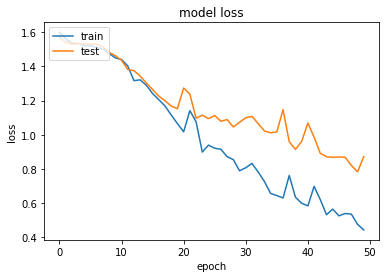

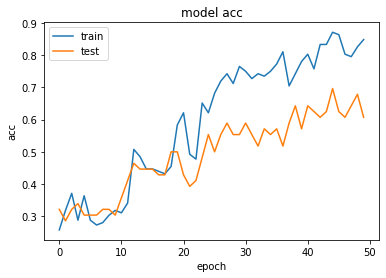

1/2 [==============>...............] - ETA: 0s - loss: 0.6896 - acc: 0.6875

2/2 [==============================] - 0s 19ms/step - loss: 0.8720 - acc: 0.6071


Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_85 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_138 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_40 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_139 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6093 - acc: 0.2121 - val_loss: 1.5883 - val_acc: 0.3036


Epoch 2/50
2/2 - 0s - loss: 1.5777 - acc: 0.2803 - val_loss: 1.5682 - val_acc: 0.2857


Epoch 3/50


2/2 - 0s - loss: 1.5572 - acc: 0.2727 - val_loss: 1.5495 - val_acc: 0.2857


Epoch 4/50
2/2 - 0s - loss: 1.5413 - acc: 0.2727 - val_loss: 1.5377 - val_acc: 0.4107


Epoch 5/50


2/2 - 0s - loss: 1.5293 - acc: 0.3485 - val_loss: 1.5293 - val_acc: 0.3393


Epoch 6/50
2/2 - 0s - loss: 1.5225 - acc: 0.3258 - val_loss: 1.5273 - val_acc: 0.3214


Epoch 7/50
2/2 - 0s - loss: 1.5128 - acc: 0.3182 - val_loss: 1.5289 - val_acc: 0.3214


Epoch 8/50
2/2 - 0s - loss: 1.5029 - acc: 0.3182 - val_loss: 1.5262 - val_acc: 0.4464


Epoch 9/50


2/2 - 0s - loss: 1.5025 - acc: 0.3636 - val_loss: 1.5170 - val_acc: 0.3571


Epoch 10/50
2/2 - 0s - loss: 1.4903 - acc: 0.3485 - val_loss: 1.5048 - val_acc: 0.3571


Epoch 11/50


2/2 - 0s - loss: 1.4705 - acc: 0.3561 - val_loss: 1.4890 - val_acc: 0.3214


Epoch 12/50


2/2 - 0s - loss: 1.4478 - acc: 0.3258 - val_loss: 1.4642 - val_acc: 0.3214


Epoch 13/50


2/2 - 0s - loss: 1.4045 - acc: 0.3561 - val_loss: 1.4122 - val_acc: 0.3929


Epoch 14/50


2/2 - 0s - loss: 1.3503 - acc: 0.3939 - val_loss: 1.3754 - val_acc: 0.4107


Epoch 15/50
2/2 - 0s - loss: 1.3162 - acc: 0.4167 - val_loss: 1.3670 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.2928 - acc: 0.4394 - val_loss: 1.3758 - val_acc: 0.4286


Epoch 17/50


2/2 - 0s - loss: 1.3008 - acc: 0.3939 - val_loss: 1.3592 - val_acc: 0.4286


Epoch 18/50


2/2 - 0s - loss: 1.2505 - acc: 0.4470 - val_loss: 1.3163 - val_acc: 0.5536


Epoch 19/50
2/2 - 0s - loss: 1.1908 - acc: 0.5303 - val_loss: 1.2864 - val_acc: 0.4464


Epoch 20/50


2/2 - 0s - loss: 1.1493 - acc: 0.5000 - val_loss: 1.2960 - val_acc: 0.4107


Epoch 21/50


2/2 - 0s - loss: 1.1564 - acc: 0.4470 - val_loss: 1.3033 - val_acc: 0.3214


Epoch 22/50


2/2 - 0s - loss: 1.1285 - acc: 0.4621 - val_loss: 1.2434 - val_acc: 0.3393


Epoch 23/50
2/2 - 0s - loss: 1.0428 - acc: 0.5152 - val_loss: 1.1703 - val_acc: 0.4286


Epoch 24/50


2/2 - 0s - loss: 0.9574 - acc: 0.5833 - val_loss: 1.1325 - val_acc: 0.5179


Epoch 25/50


2/2 - 0s - loss: 0.8959 - acc: 0.6591 - val_loss: 1.1366 - val_acc: 0.5357


Epoch 26/50


2/2 - 0s - loss: 0.8990 - acc: 0.5833 - val_loss: 1.1639 - val_acc: 0.5179


Epoch 27/50


2/2 - 0s - loss: 0.9241 - acc: 0.5530 - val_loss: 1.1329 - val_acc: 0.4821


Epoch 28/50


2/2 - 0s - loss: 0.8459 - acc: 0.6515 - val_loss: 1.1247 - val_acc: 0.4107


Epoch 29/50


2/2 - 0s - loss: 0.8080 - acc: 0.6364 - val_loss: 1.1339 - val_acc: 0.5357


Epoch 30/50


2/2 - 0s - loss: 0.8193 - acc: 0.6439 - val_loss: 1.1693 - val_acc: 0.5357


Epoch 31/50


2/2 - 0s - loss: 0.8146 - acc: 0.6439 - val_loss: 1.2299 - val_acc: 0.4821


Epoch 32/50


2/2 - 0s - loss: 0.8517 - acc: 0.5530 - val_loss: 1.2026 - val_acc: 0.5357


Epoch 33/50


2/2 - 0s - loss: 0.8292 - acc: 0.6061 - val_loss: 1.2197 - val_acc: 0.4643


Epoch 34/50


2/2 - 0s - loss: 0.8611 - acc: 0.6364 - val_loss: 1.1733 - val_acc: 0.5357


Epoch 35/50


2/2 - 0s - loss: 0.7697 - acc: 0.6136 - val_loss: 1.1325 - val_acc: 0.5536


Epoch 36/50


2/2 - 0s - loss: 0.8030 - acc: 0.6288 - val_loss: 1.1212 - val_acc: 0.4643


Epoch 37/50


2/2 - 0s - loss: 0.7654 - acc: 0.6894 - val_loss: 1.0235 - val_acc: 0.5893


Epoch 38/50


2/2 - 0s - loss: 0.6320 - acc: 0.7803 - val_loss: 0.9903 - val_acc: 0.6071


Epoch 39/50


2/2 - 0s - loss: 0.6012 - acc: 0.7803 - val_loss: 1.0246 - val_acc: 0.5893


Epoch 40/50


2/2 - 0s - loss: 0.6201 - acc: 0.7803 - val_loss: 1.0347 - val_acc: 0.5893


Epoch 41/50


2/2 - 0s - loss: 0.6075 - acc: 0.7803 - val_loss: 1.0459 - val_acc: 0.6429


Epoch 42/50


2/2 - 0s - loss: 0.6271 - acc: 0.7652 - val_loss: 1.0065 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.6178 - acc: 0.7424 - val_loss: 0.9874 - val_acc: 0.5893


Epoch 44/50


2/2 - 0s - loss: 0.5918 - acc: 0.7803 - val_loss: 0.9265 - val_acc: 0.6429


Epoch 45/50


2/2 - 0s - loss: 0.5136 - acc: 0.7879 - val_loss: 0.9067 - val_acc: 0.6250


Epoch 46/50


2/2 - 0s - loss: 0.4474 - acc: 0.8182 - val_loss: 0.9212 - val_acc: 0.6429


Epoch 47/50


2/2 - 0s - loss: 0.4268 - acc: 0.8333 - val_loss: 0.9771 - val_acc: 0.6429


Epoch 48/50


2/2 - 0s - loss: 0.4618 - acc: 0.8333 - val_loss: 1.0727 - val_acc: 0.6071


Epoch 49/50


2/2 - 0s - loss: 0.5144 - acc: 0.8182 - val_loss: 1.0960 - val_acc: 0.5893


Epoch 50/50


2/2 - 0s - loss: 0.4659 - acc: 0.8561 - val_loss: 1.1293 - val_acc: 0.6071


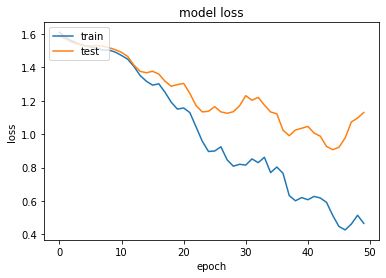

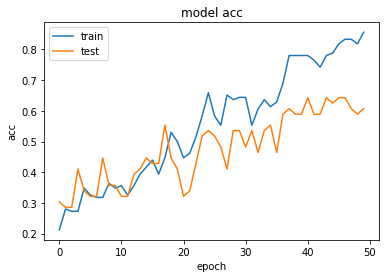

1/2 [==============>...............] - ETA: 0s - loss: 0.9507 - acc: 0.6562

2/2 [==============================] - 0s 18ms/step - loss: 1.1293 - acc: 0.6071


Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_87 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_140 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_41 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_141 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6067 - acc: 0.2652 - val_loss: 1.5826 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5762 - acc: 0.3106 - val_loss: 1.5544 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5517 - acc: 0.2879 - val_loss: 1.5323 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5338 - acc: 0.3258 - val_loss: 1.5373 - val_acc: 0.3393


Epoch 5/50
2/2 - 0s - loss: 1.5491 - acc: 0.3485 - val_loss: 1.5544 - val_acc: 0.3393


Epoch 6/50
2/2 - 0s - loss: 1.5655 - acc: 0.2955 - val_loss: 1.5559 - val_acc: 0.3036


Epoch 7/50


2/2 - 0s - loss: 1.5569 - acc: 0.3258 - val_loss: 1.5318 - val_acc: 0.3393


Epoch 8/50
2/2 - 0s - loss: 1.5324 - acc: 0.4091 - val_loss: 1.5074 - val_acc: 0.3393


Epoch 9/50
2/2 - 0s - loss: 1.4977 - acc: 0.3106 - val_loss: 1.4872 - val_acc: 0.3393


Epoch 10/50
2/2 - 0s - loss: 1.4556 - acc: 0.3409 - val_loss: 1.4695 - val_acc: 0.3571


Epoch 11/50


2/2 - 0s - loss: 1.4219 - acc: 0.3712 - val_loss: 1.4521 - val_acc: 0.3571


Epoch 12/50


2/2 - 0s - loss: 1.3854 - acc: 0.3939 - val_loss: 1.4360 - val_acc: 0.3750


Epoch 13/50


2/2 - 0s - loss: 1.3401 - acc: 0.5076 - val_loss: 1.4243 - val_acc: 0.4286


Epoch 14/50
2/2 - 0s - loss: 1.3115 - acc: 0.5303 - val_loss: 1.4060 - val_acc: 0.4107


Epoch 15/50
2/2 - 0s - loss: 1.2844 - acc: 0.5152 - val_loss: 1.3532 - val_acc: 0.4286


Epoch 16/50
2/2 - 0s - loss: 1.2248 - acc: 0.5303 - val_loss: 1.3581 - val_acc: 0.4643


Epoch 17/50
2/2 - 0s - loss: 1.2245 - acc: 0.4470 - val_loss: 1.3220 - val_acc: 0.4464


Epoch 18/50


2/2 - 0s - loss: 1.1759 - acc: 0.5076 - val_loss: 1.2587 - val_acc: 0.3929


Epoch 19/50
2/2 - 0s - loss: 1.1011 - acc: 0.5909 - val_loss: 1.2942 - val_acc: 0.4821


Epoch 20/50
2/2 - 0s - loss: 1.1097 - acc: 0.5379 - val_loss: 1.3998 - val_acc: 0.4286


Epoch 21/50


2/2 - 0s - loss: 1.1376 - acc: 0.5000 - val_loss: 1.5049 - val_acc: 0.3929


Epoch 22/50


2/2 - 0s - loss: 1.2137 - acc: 0.4621 - val_loss: 1.4442 - val_acc: 0.4464


Epoch 23/50


2/2 - 0s - loss: 1.0286 - acc: 0.5682 - val_loss: 1.2647 - val_acc: 0.4821


Epoch 24/50


2/2 - 0s - loss: 0.8748 - acc: 0.6439 - val_loss: 1.3696 - val_acc: 0.4821


Epoch 25/50
2/2 - 0s - loss: 0.9216 - acc: 0.5985 - val_loss: 1.2603 - val_acc: 0.5000


Epoch 26/50


2/2 - 0s - loss: 0.7980 - acc: 0.6667 - val_loss: 1.3160 - val_acc: 0.4464


Epoch 27/50
2/2 - 0s - loss: 0.8661 - acc: 0.6212 - val_loss: 1.2371 - val_acc: 0.4643


Epoch 28/50
2/2 - 0s - loss: 0.7777 - acc: 0.6742 - val_loss: 1.1439 - val_acc: 0.5179


Epoch 29/50


2/2 - 0s - loss: 0.6261 - acc: 0.7348 - val_loss: 1.2271 - val_acc: 0.5357


Epoch 30/50


2/2 - 0s - loss: 0.7140 - acc: 0.6970 - val_loss: 1.3916 - val_acc: 0.5714


Epoch 31/50


2/2 - 0s - loss: 0.8069 - acc: 0.6818 - val_loss: 1.3975 - val_acc: 0.4821


Epoch 32/50


2/2 - 0s - loss: 0.8522 - acc: 0.6515 - val_loss: 1.1565 - val_acc: 0.4464


Epoch 33/50
2/2 - 0s - loss: 0.7040 - acc: 0.7576 - val_loss: 1.1614 - val_acc: 0.4464


Epoch 34/50


2/2 - 0s - loss: 0.6858 - acc: 0.7500 - val_loss: 1.1410 - val_acc: 0.4643


Epoch 35/50


2/2 - 0s - loss: 0.6908 - acc: 0.7197 - val_loss: 1.0921 - val_acc: 0.4821


Epoch 36/50


2/2 - 0s - loss: 0.6745 - acc: 0.7500 - val_loss: 1.1342 - val_acc: 0.4643


Epoch 37/50


2/2 - 0s - loss: 0.7087 - acc: 0.7348 - val_loss: 1.1221 - val_acc: 0.4821


Epoch 38/50

2/2 - 0s - loss: 0.6764 - acc: 0.7273 - val_loss: 1.0725 - val_acc: 0.5536


Epoch 39/50


2/2 - 0s - loss: 0.5695 - acc: 0.8333 - val_loss: 1.0412 - val_acc: 0.6250


Epoch 40/50


2/2 - 0s - loss: 0.5203 - acc: 0.8333 - val_loss: 1.0766 - val_acc: 0.6429


Epoch 41/50


2/2 - 0s - loss: 0.5510 - acc: 0.8030 - val_loss: 1.0852 - val_acc: 0.6250


Epoch 42/50


2/2 - 0s - loss: 0.5180 - acc: 0.8333 - val_loss: 1.0673 - val_acc: 0.6607


Epoch 43/50


2/2 - 0s - loss: 0.5095 - acc: 0.8333 - val_loss: 1.0562 - val_acc: 0.6786


Epoch 44/50


2/2 - 0s - loss: 0.4835 - acc: 0.8561 - val_loss: 0.9992 - val_acc: 0.6964


Epoch 45/50


2/2 - 0s - loss: 0.4310 - acc: 0.8636 - val_loss: 0.9557 - val_acc: 0.6071


Epoch 46/50
2/2 - 0s - loss: 0.4043 - acc: 0.8333 - val_loss: 0.9817 - val_acc: 0.6250


Epoch 47/50


2/2 - 0s - loss: 0.4146 - acc: 0.8333 - val_loss: 0.9947 - val_acc: 0.6964


Epoch 48/50


2/2 - 0s - loss: 0.4012 - acc: 0.8561 - val_loss: 1.0422 - val_acc: 0.6250


Epoch 49/50


2/2 - 0s - loss: 0.4027 - acc: 0.8409 - val_loss: 1.1569 - val_acc: 0.6429


Epoch 50/50


2/2 - 0s - loss: 0.4990 - acc: 0.8182 - val_loss: 1.1125 - val_acc: 0.5714


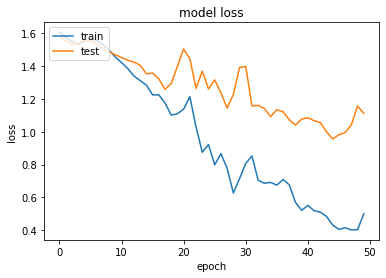

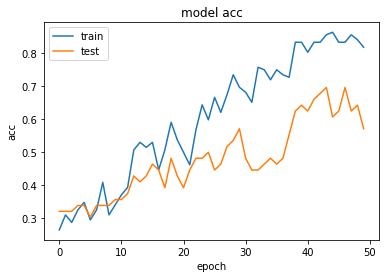

1/2 [==============>...............] - ETA: 0s - loss: 0.8733 - acc: 0.6562

2/2 [==============================] - 0s 19ms/step - loss: 1.1125 - acc: 0.5714


Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_89 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_142 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_42 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_143 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6045 - acc: 0.2727 - val_loss: 1.5766 - val_acc: 0.2679


Epoch 2/50
2/2 - 0s - loss: 1.5660 - acc: 0.3788 - val_loss: 1.5461 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5489 - acc: 0.3030 - val_loss: 1.5324 - val_acc: 0.3214


Epoch 4/50


2/2 - 0s - loss: 1.5530 - acc: 0.2879 - val_loss: 1.5262 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5490 - acc: 0.2879 - val_loss: 1.5164 - val_acc: 0.3214


Epoch 6/50
2/2 - 0s - loss: 1.5198 - acc: 0.3182 - val_loss: 1.5096 - val_acc: 0.3214


Epoch 7/50


2/2 - 0s - loss: 1.5037 - acc: 0.3939 - val_loss: 1.5029 - val_acc: 0.3571


Epoch 8/50
2/2 - 0s - loss: 1.4819 - acc: 0.4091 - val_loss: 1.4950 - val_acc: 0.4464


Epoch 9/50
2/2 - 0s - loss: 1.4576 - acc: 0.4545 - val_loss: 1.4908 - val_acc: 0.4464


Epoch 10/50
2/2 - 0s - loss: 1.4360 - acc: 0.5000 - val_loss: 1.4892 - val_acc: 0.4464


Epoch 11/50


2/2 - 0s - loss: 1.4275 - acc: 0.5227 - val_loss: 1.4717 - val_acc: 0.4464


Epoch 12/50


2/2 - 0s - loss: 1.4007 - acc: 0.5379 - val_loss: 1.4381 - val_acc: 0.4286


Epoch 13/50


2/2 - 0s - loss: 1.3652 - acc: 0.4924 - val_loss: 1.4131 - val_acc: 0.4107


Epoch 14/50


2/2 - 0s - loss: 1.3341 - acc: 0.5152 - val_loss: 1.3769 - val_acc: 0.4107


Epoch 15/50


2/2 - 0s - loss: 1.2700 - acc: 0.5455 - val_loss: 1.3341 - val_acc: 0.4464


Epoch 16/50
2/2 - 0s - loss: 1.2030 - acc: 0.5530 - val_loss: 1.2853 - val_acc: 0.4464


Epoch 17/50


2/2 - 0s - loss: 1.1426 - acc: 0.5606 - val_loss: 1.2413 - val_acc: 0.4821


Epoch 18/50
2/2 - 0s - loss: 1.0920 - acc: 0.5606 - val_loss: 1.2111 - val_acc: 0.4821


Epoch 19/50


2/2 - 0s - loss: 1.0341 - acc: 0.6439 - val_loss: 1.1843 - val_acc: 0.4643


Epoch 20/50


2/2 - 0s - loss: 0.9812 - acc: 0.6061 - val_loss: 1.2094 - val_acc: 0.4286


Epoch 21/50


2/2 - 0s - loss: 1.0424 - acc: 0.5530 - val_loss: 1.2326 - val_acc: 0.4286


Epoch 22/50


2/2 - 0s - loss: 1.0052 - acc: 0.5606 - val_loss: 1.2011 - val_acc: 0.4821


Epoch 23/50


2/2 - 0s - loss: 0.8742 - acc: 0.6667 - val_loss: 1.1884 - val_acc: 0.4821


Epoch 24/50


2/2 - 0s - loss: 0.7818 - acc: 0.7273 - val_loss: 1.1864 - val_acc: 0.5357


Epoch 25/50
2/2 - 0s - loss: 0.7582 - acc: 0.7500 - val_loss: 1.2151 - val_acc: 0.5714


Epoch 26/50
2/2 - 0s - loss: 0.7591 - acc: 0.7424 - val_loss: 1.3200 - val_acc: 0.5714


Epoch 27/50
2/2 - 0s - loss: 0.8320 - acc: 0.7121 - val_loss: 1.4930 - val_acc: 0.5536


Epoch 28/50


2/2 - 0s - loss: 0.8311 - acc: 0.7348 - val_loss: 1.5302 - val_acc: 0.4643


Epoch 29/50


2/2 - 0s - loss: 0.7666 - acc: 0.7273 - val_loss: 1.3810 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.6932 - acc: 0.7955 - val_loss: 1.3136 - val_acc: 0.5714


Epoch 31/50


2/2 - 0s - loss: 0.7865 - acc: 0.7348 - val_loss: 1.2481 - val_acc: 0.5357


Epoch 32/50


2/2 - 0s - loss: 0.7236 - acc: 0.7576 - val_loss: 1.2981 - val_acc: 0.4643


Epoch 33/50


2/2 - 0s - loss: 0.7586 - acc: 0.6818 - val_loss: 1.3411 - val_acc: 0.4821


Epoch 34/50


2/2 - 0s - loss: 0.8846 - acc: 0.6364 - val_loss: 1.2656 - val_acc: 0.4821


Epoch 35/50


2/2 - 0s - loss: 0.7679 - acc: 0.7500 - val_loss: 1.1795 - val_acc: 0.5357


Epoch 36/50


2/2 - 0s - loss: 0.6634 - acc: 0.8030 - val_loss: 1.1039 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.6195 - acc: 0.8182 - val_loss: 1.0722 - val_acc: 0.5893


Epoch 38/50
2/2 - 0s - loss: 0.6006 - acc: 0.8409 - val_loss: 1.0698 - val_acc: 0.5357


Epoch 39/50


2/2 - 0s - loss: 0.6125 - acc: 0.8182 - val_loss: 1.0603 - val_acc: 0.5714


Epoch 40/50


2/2 - 0s - loss: 0.5789 - acc: 0.8030 - val_loss: 1.1159 - val_acc: 0.5893


Epoch 41/50


2/2 - 0s - loss: 0.6257 - acc: 0.7955 - val_loss: 1.1318 - val_acc: 0.5714


Epoch 42/50


2/2 - 0s - loss: 0.5882 - acc: 0.7879 - val_loss: 1.0848 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.5463 - acc: 0.8258 - val_loss: 1.4031 - val_acc: 0.4643


Epoch 44/50
2/2 - 0s - loss: 0.8416 - acc: 0.6818 - val_loss: 1.1468 - val_acc: 0.5714


Epoch 45/50


2/2 - 0s - loss: 0.6184 - acc: 0.7424 - val_loss: 1.0082 - val_acc: 0.6250


Epoch 46/50


2/2 - 0s - loss: 0.4904 - acc: 0.8561 - val_loss: 1.0839 - val_acc: 0.5714


Epoch 47/50


2/2 - 0s - loss: 0.5518 - acc: 0.8258 - val_loss: 1.1413 - val_acc: 0.5357


Epoch 48/50


2/2 - 0s - loss: 0.6366 - acc: 0.7652 - val_loss: 1.1573 - val_acc: 0.5714


Epoch 49/50


2/2 - 0s - loss: 0.6383 - acc: 0.7424 - val_loss: 1.1179 - val_acc: 0.5714


Epoch 50/50


2/2 - 0s - loss: 0.6089 - acc: 0.7727 - val_loss: 1.0500 - val_acc: 0.5536


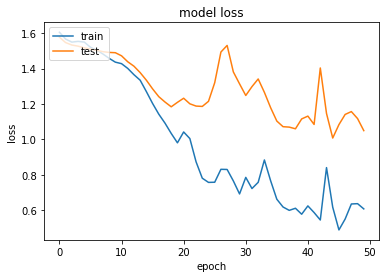

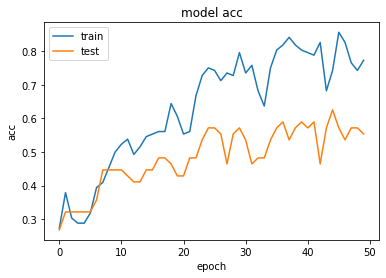

1/2 [==============>...............] - ETA: 0s - loss: 0.9265 - acc: 0.6250

2/2 [==============================] - 0s 17ms/step - loss: 1.0500 - acc: 0.5536


Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_91 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_144 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_43 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_145 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6181 - acc: 0.0758 - val_loss: 1.5910 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5883 - acc: 0.2879 - val_loss: 1.5793 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5714 - acc: 0.2879 - val_loss: 1.5649 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5571 - acc: 0.2879 - val_loss: 1.5435 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5437 - acc: 0.2879 - val_loss: 1.5314 - val_acc: 0.3214


Epoch 6/50
2/2 - 0s - loss: 1.5536 - acc: 0.2879 - val_loss: 1.5206 - val_acc: 0.3214


Epoch 7/50


2/2 - 0s - loss: 1.5350 - acc: 0.2879 - val_loss: 1.4995 - val_acc: 0.3214


Epoch 8/50


2/2 - 0s - loss: 1.4811 - acc: 0.2955 - val_loss: 1.4992 - val_acc: 0.3750


Epoch 9/50


2/2 - 0s - loss: 1.4705 - acc: 0.3106 - val_loss: 1.5085 - val_acc: 0.3036


Epoch 10/50


2/2 - 0s - loss: 1.4454 - acc: 0.3106 - val_loss: 1.5109 - val_acc: 0.3036


Epoch 11/50


2/2 - 0s - loss: 1.4575 - acc: 0.3106 - val_loss: 1.4804 - val_acc: 0.3571


Epoch 12/50


2/2 - 0s - loss: 1.4149 - acc: 0.3485 - val_loss: 1.4426 - val_acc: 0.3929


Epoch 13/50


2/2 - 0s - loss: 1.3718 - acc: 0.3864 - val_loss: 1.4233 - val_acc: 0.3393


Epoch 14/50


2/2 - 0s - loss: 1.3457 - acc: 0.3864 - val_loss: 1.3966 - val_acc: 0.3393


Epoch 15/50


2/2 - 0s - loss: 1.3095 - acc: 0.4318 - val_loss: 1.3665 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.2481 - acc: 0.5000 - val_loss: 1.3614 - val_acc: 0.4286


Epoch 17/50


2/2 - 0s - loss: 1.2188 - acc: 0.4470 - val_loss: 1.3468 - val_acc: 0.4643


Epoch 18/50


2/2 - 0s - loss: 1.1733 - acc: 0.5152 - val_loss: 1.3019 - val_acc: 0.5536


Epoch 19/50
2/2 - 0s - loss: 1.1179 - acc: 0.6288 - val_loss: 1.2570 - val_acc: 0.5357


Epoch 20/50


2/2 - 0s - loss: 1.0566 - acc: 0.6212 - val_loss: 1.3225 - val_acc: 0.4643


Epoch 21/50


2/2 - 0s - loss: 1.1016 - acc: 0.5530 - val_loss: 1.3408 - val_acc: 0.4464


Epoch 22/50


2/2 - 0s - loss: 1.1003 - acc: 0.5455 - val_loss: 1.2744 - val_acc: 0.4821


Epoch 23/50
2/2 - 0s - loss: 1.1231 - acc: 0.5455 - val_loss: 1.2576 - val_acc: 0.4821


Epoch 24/50


2/2 - 0s - loss: 1.0810 - acc: 0.5909 - val_loss: 1.1759 - val_acc: 0.5893


Epoch 25/50


2/2 - 0s - loss: 0.9256 - acc: 0.5985 - val_loss: 1.1988 - val_acc: 0.5714


Epoch 26/50


2/2 - 0s - loss: 0.9357 - acc: 0.5833 - val_loss: 1.1113 - val_acc: 0.5714


Epoch 27/50


2/2 - 0s - loss: 0.8801 - acc: 0.6136 - val_loss: 1.1115 - val_acc: 0.6071


Epoch 28/50
2/2 - 0s - loss: 0.8795 - acc: 0.6970 - val_loss: 1.1538 - val_acc: 0.5357


Epoch 29/50
2/2 - 0s - loss: 0.9278 - acc: 0.6742 - val_loss: 1.1770 - val_acc: 0.4821


Epoch 30/50


2/2 - 0s - loss: 0.9488 - acc: 0.5682 - val_loss: 1.1582 - val_acc: 0.4643


Epoch 31/50


2/2 - 0s - loss: 0.9145 - acc: 0.5909 - val_loss: 1.1482 - val_acc: 0.5536


Epoch 32/50


2/2 - 0s - loss: 0.8840 - acc: 0.6894 - val_loss: 1.1257 - val_acc: 0.5357


Epoch 33/50


2/2 - 0s - loss: 0.8801 - acc: 0.5833 - val_loss: 1.0411 - val_acc: 0.5357


Epoch 34/50


2/2 - 0s - loss: 0.7899 - acc: 0.7197 - val_loss: 1.0479 - val_acc: 0.5714


Epoch 35/50


2/2 - 0s - loss: 0.8428 - acc: 0.6667 - val_loss: 1.0419 - val_acc: 0.5357


Epoch 36/50
2/2 - 0s - loss: 0.8222 - acc: 0.6439 - val_loss: 0.9806 - val_acc: 0.6071


Epoch 37/50


2/2 - 0s - loss: 0.7261 - acc: 0.6970 - val_loss: 0.9689 - val_acc: 0.5893


Epoch 38/50


2/2 - 0s - loss: 0.6558 - acc: 0.7652 - val_loss: 0.9923 - val_acc: 0.6250


Epoch 39/50


2/2 - 0s - loss: 0.6355 - acc: 0.7803 - val_loss: 1.0235 - val_acc: 0.5714


Epoch 40/50


2/2 - 0s - loss: 0.6329 - acc: 0.7576 - val_loss: 1.0338 - val_acc: 0.5714


Epoch 41/50


2/2 - 0s - loss: 0.6067 - acc: 0.7879 - val_loss: 1.0218 - val_acc: 0.6071


Epoch 42/50


2/2 - 0s - loss: 0.5970 - acc: 0.7576 - val_loss: 1.0147 - val_acc: 0.6250


Epoch 43/50


2/2 - 0s - loss: 0.5309 - acc: 0.7727 - val_loss: 0.9985 - val_acc: 0.6429


Epoch 44/50


2/2 - 0s - loss: 0.4797 - acc: 0.7879 - val_loss: 1.0015 - val_acc: 0.6429


Epoch 45/50


2/2 - 0s - loss: 0.4486 - acc: 0.8258 - val_loss: 0.9925 - val_acc: 0.6250


Epoch 46/50


2/2 - 0s - loss: 0.4024 - acc: 0.8485 - val_loss: 0.9870 - val_acc: 0.6607


Epoch 47/50


2/2 - 0s - loss: 0.3495 - acc: 0.8712 - val_loss: 1.0696 - val_acc: 0.6071


Epoch 48/50
2/2 - 0s - loss: 0.4186 - acc: 0.8333 - val_loss: 1.1956 - val_acc: 0.6071


Epoch 49/50


2/2 - 0s - loss: 0.5092 - acc: 0.8106 - val_loss: 1.2244 - val_acc: 0.5714


Epoch 50/50
2/2 - 0s - loss: 0.5320 - acc: 0.8258 - val_loss: 1.1978 - val_acc: 0.5893


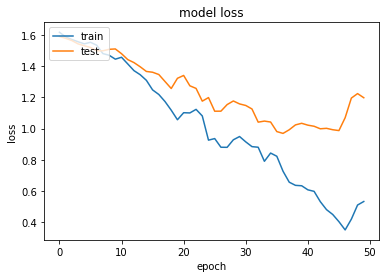

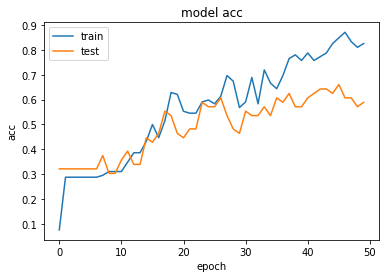

1/2 [==============>...............] - ETA: 0s - loss: 1.0975 - acc: 0.5938

2/2 [==============================] - 0s 17ms/step - loss: 1.1978 - acc: 0.5893


Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_93 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_146 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_44 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_147 (Dropout)        (None, None, 128)         0  

2/2 - 4s - loss: 1.6065 - acc: 0.1894 - val_loss: 1.5825 - val_acc: 0.3036


Epoch 2/50
2/2 - 0s - loss: 1.5777 - acc: 0.3030 - val_loss: 1.5703 - val_acc: 0.3036


Epoch 3/50


2/2 - 0s - loss: 1.5560 - acc: 0.2879 - val_loss: 1.5634 - val_acc: 0.3036


Epoch 4/50
2/2 - 0s - loss: 1.5438 - acc: 0.2955 - val_loss: 1.5586 - val_acc: 0.3036


Epoch 5/50
2/2 - 0s - loss: 1.5395 - acc: 0.3030 - val_loss: 1.5524 - val_acc: 0.3750


Epoch 6/50
2/2 - 0s - loss: 1.5232 - acc: 0.3864 - val_loss: 1.5387 - val_acc: 0.3750


Epoch 7/50
2/2 - 0s - loss: 1.5011 - acc: 0.3712 - val_loss: 1.5318 - val_acc: 0.3929


Epoch 8/50
2/2 - 0s - loss: 1.4887 - acc: 0.4545 - val_loss: 1.5277 - val_acc: 0.3214


Epoch 9/50
2/2 - 0s - loss: 1.4889 - acc: 0.3636 - val_loss: 1.5016 - val_acc: 0.3571


Epoch 10/50
2/2 - 0s - loss: 1.4522 - acc: 0.3258 - val_loss: 1.4536 - val_acc: 0.3571


Epoch 11/50
2/2 - 0s - loss: 1.3773 - acc: 0.4621 - val_loss: 1.4534 - val_acc: 0.3750


Epoch 12/50


2/2 - 0s - loss: 1.3578 - acc: 0.4545 - val_loss: 1.4736 - val_acc: 0.3750


Epoch 13/50


2/2 - 0s - loss: 1.3461 - acc: 0.4924 - val_loss: 1.3764 - val_acc: 0.4821


Epoch 14/50


2/2 - 0s - loss: 1.2606 - acc: 0.4773 - val_loss: 1.3755 - val_acc: 0.4107


Epoch 15/50
2/2 - 0s - loss: 1.2462 - acc: 0.4394 - val_loss: 1.3200 - val_acc: 0.4643


Epoch 16/50
2/2 - 0s - loss: 1.1733 - acc: 0.5379 - val_loss: 1.3120 - val_acc: 0.4286


Epoch 17/50


2/2 - 0s - loss: 1.1943 - acc: 0.5530 - val_loss: 1.3029 - val_acc: 0.4286


Epoch 18/50


2/2 - 0s - loss: 1.1525 - acc: 0.6364 - val_loss: 1.2458 - val_acc: 0.5536


Epoch 19/50


2/2 - 0s - loss: 1.0765 - acc: 0.6515 - val_loss: 1.2303 - val_acc: 0.5000


Epoch 20/50


2/2 - 0s - loss: 1.0316 - acc: 0.5909 - val_loss: 1.2740 - val_acc: 0.4643


Epoch 21/50


2/2 - 0s - loss: 1.0377 - acc: 0.5530 - val_loss: 1.2421 - val_acc: 0.5000


Epoch 22/50


2/2 - 0s - loss: 0.9542 - acc: 0.5985 - val_loss: 1.2531 - val_acc: 0.4286


Epoch 23/50


2/2 - 0s - loss: 0.9722 - acc: 0.6212 - val_loss: 1.2631 - val_acc: 0.4107


Epoch 24/50


2/2 - 0s - loss: 1.0146 - acc: 0.6061 - val_loss: 1.2681 - val_acc: 0.4643


Epoch 25/50


2/2 - 0s - loss: 1.0426 - acc: 0.5833 - val_loss: 1.2629 - val_acc: 0.5000


Epoch 26/50


2/2 - 0s - loss: 1.0440 - acc: 0.5985 - val_loss: 1.2116 - val_acc: 0.4643


Epoch 27/50


2/2 - 0s - loss: 0.9385 - acc: 0.6667 - val_loss: 1.1840 - val_acc: 0.5357


Epoch 28/50


2/2 - 0s - loss: 0.8687 - acc: 0.6742 - val_loss: 1.1590 - val_acc: 0.5179


Epoch 29/50


2/2 - 0s - loss: 0.8042 - acc: 0.7121 - val_loss: 1.1858 - val_acc: 0.4464


Epoch 30/50


2/2 - 0s - loss: 0.8151 - acc: 0.6667 - val_loss: 1.2784 - val_acc: 0.5357


Epoch 31/50


2/2 - 0s - loss: 0.8695 - acc: 0.6818 - val_loss: 1.3621 - val_acc: 0.5179


Epoch 32/50


2/2 - 0s - loss: 0.8997 - acc: 0.6591 - val_loss: 1.3269 - val_acc: 0.4821


Epoch 33/50


2/2 - 0s - loss: 0.8557 - acc: 0.6288 - val_loss: 1.1258 - val_acc: 0.5893


Epoch 34/50


2/2 - 0s - loss: 0.6495 - acc: 0.7424 - val_loss: 1.3013 - val_acc: 0.5000


Epoch 35/50
2/2 - 0s - loss: 0.8864 - acc: 0.6970 - val_loss: 1.3616 - val_acc: 0.4643


Epoch 36/50


2/2 - 0s - loss: 0.9545 - acc: 0.6288 - val_loss: 1.2909 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.8516 - acc: 0.6894 - val_loss: 1.1454 - val_acc: 0.5536


Epoch 38/50


2/2 - 0s - loss: 0.6649 - acc: 0.8106 - val_loss: 1.0836 - val_acc: 0.5893


Epoch 39/50


2/2 - 0s - loss: 0.6155 - acc: 0.8106 - val_loss: 1.2305 - val_acc: 0.5357


Epoch 40/50


2/2 - 0s - loss: 0.7764 - acc: 0.7197 - val_loss: 1.3324 - val_acc: 0.5179


Epoch 41/50


2/2 - 0s - loss: 0.8306 - acc: 0.7424 - val_loss: 1.4153 - val_acc: 0.5179


Epoch 42/50


2/2 - 0s - loss: 0.9370 - acc: 0.6288 - val_loss: 1.4685 - val_acc: 0.4643


Epoch 43/50


2/2 - 0s - loss: 0.9950 - acc: 0.6136 - val_loss: 1.2111 - val_acc: 0.5179


Epoch 44/50


2/2 - 0s - loss: 0.7918 - acc: 0.6818 - val_loss: 1.0097 - val_acc: 0.6250


Epoch 45/50

2/2 - 0s - loss: 0.5861 - acc: 0.7955 - val_loss: 0.9408 - val_acc: 0.6429


Epoch 46/50


2/2 - 0s - loss: 0.5397 - acc: 0.8182 - val_loss: 0.9348 - val_acc: 0.6964


Epoch 47/50


2/2 - 0s - loss: 0.4982 - acc: 0.8788 - val_loss: 0.9439 - val_acc: 0.6429


Epoch 48/50


2/2 - 0s - loss: 0.5003 - acc: 0.8712 - val_loss: 0.9304 - val_acc: 0.6429


Epoch 49/50


2/2 - 0s - loss: 0.4642 - acc: 0.8788 - val_loss: 0.8979 - val_acc: 0.6250


Epoch 50/50


2/2 - 0s - loss: 0.4306 - acc: 0.8561 - val_loss: 0.8884 - val_acc: 0.6250


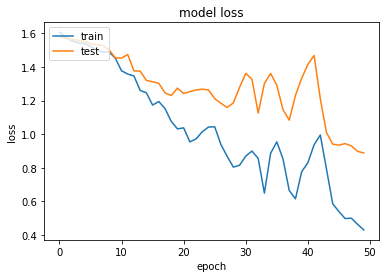

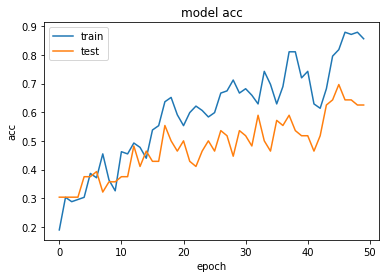

1/2 [==============>...............] - ETA: 0s - loss: 0.8487 - acc: 0.6250

2/2 [==============================] - 0s 18ms/step - loss: 0.8884 - acc: 0.6250


Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_95 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_148 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_90 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_45 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_149 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6176 - acc: 0.1061 - val_loss: 1.5909 - val_acc: 0.3036


Epoch 2/50
2/2 - 0s - loss: 1.5849 - acc: 0.2727 - val_loss: 1.5725 - val_acc: 0.2857


Epoch 3/50


2/2 - 0s - loss: 1.5665 - acc: 0.2727 - val_loss: 1.5574 - val_acc: 0.2857


Epoch 4/50
2/2 - 0s - loss: 1.5447 - acc: 0.2727 - val_loss: 1.5517 - val_acc: 0.2857


Epoch 5/50


2/2 - 0s - loss: 1.5274 - acc: 0.2727 - val_loss: 1.5515 - val_acc: 0.2857


Epoch 6/50
2/2 - 0s - loss: 1.5211 - acc: 0.2727 - val_loss: 1.5570 - val_acc: 0.2857


Epoch 7/50


2/2 - 0s - loss: 1.5273 - acc: 0.2803 - val_loss: 1.5643 - val_acc: 0.3393


Epoch 8/50


2/2 - 0s - loss: 1.5226 - acc: 0.3409 - val_loss: 1.5576 - val_acc: 0.3571


Epoch 9/50


2/2 - 0s - loss: 1.5030 - acc: 0.3939 - val_loss: 1.5349 - val_acc: 0.3571


Epoch 10/50


2/2 - 0s - loss: 1.4758 - acc: 0.3636 - val_loss: 1.5040 - val_acc: 0.3750


Epoch 11/50
2/2 - 0s - loss: 1.4387 - acc: 0.5379 - val_loss: 1.4762 - val_acc: 0.3929


Epoch 12/50


2/2 - 0s - loss: 1.3988 - acc: 0.5152 - val_loss: 1.4551 - val_acc: 0.3393


Epoch 13/50


2/2 - 0s - loss: 1.3576 - acc: 0.5455 - val_loss: 1.4257 - val_acc: 0.3571


Epoch 14/50


2/2 - 0s - loss: 1.3077 - acc: 0.5455 - val_loss: 1.3670 - val_acc: 0.4286


Epoch 15/50
2/2 - 0s - loss: 1.2027 - acc: 0.5833 - val_loss: 1.3155 - val_acc: 0.4286


Epoch 16/50


2/2 - 0s - loss: 1.1178 - acc: 0.5530 - val_loss: 1.2869 - val_acc: 0.4643


Epoch 17/50


2/2 - 0s - loss: 1.0715 - acc: 0.5303 - val_loss: 1.2979 - val_acc: 0.4643


Epoch 18/50


2/2 - 0s - loss: 1.0331 - acc: 0.4848 - val_loss: 1.4189 - val_acc: 0.4464


Epoch 19/50
2/2 - 0s - loss: 1.0968 - acc: 0.5000 - val_loss: 1.3654 - val_acc: 0.4286


Epoch 20/50


2/2 - 0s - loss: 1.0329 - acc: 0.5303 - val_loss: 1.2297 - val_acc: 0.4643


Epoch 21/50


2/2 - 0s - loss: 1.0089 - acc: 0.4848 - val_loss: 1.5669 - val_acc: 0.4643


Epoch 22/50


2/2 - 0s - loss: 1.2948 - acc: 0.4394 - val_loss: 1.4986 - val_acc: 0.4107


Epoch 23/50
2/2 - 0s - loss: 1.1631 - acc: 0.4697 - val_loss: 1.1860 - val_acc: 0.4643


Epoch 24/50


2/2 - 0s - loss: 0.8990 - acc: 0.5530 - val_loss: 1.1799 - val_acc: 0.5000


Epoch 25/50


2/2 - 0s - loss: 0.8826 - acc: 0.5606 - val_loss: 1.2018 - val_acc: 0.5000


Epoch 26/50


2/2 - 0s - loss: 0.9491 - acc: 0.5455 - val_loss: 1.1957 - val_acc: 0.4643


Epoch 27/50


2/2 - 0s - loss: 0.9676 - acc: 0.6364 - val_loss: 1.2026 - val_acc: 0.5714


Epoch 28/50


2/2 - 0s - loss: 0.9613 - acc: 0.5909 - val_loss: 1.2338 - val_acc: 0.5357


Epoch 29/50


2/2 - 0s - loss: 0.9625 - acc: 0.5606 - val_loss: 1.1597 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.8765 - acc: 0.6894 - val_loss: 1.0538 - val_acc: 0.4643


Epoch 31/50


2/2 - 0s - loss: 0.7787 - acc: 0.7727 - val_loss: 1.0461 - val_acc: 0.5893


Epoch 32/50


2/2 - 0s - loss: 0.7862 - acc: 0.6970 - val_loss: 1.0987 - val_acc: 0.5714


Epoch 33/50


2/2 - 0s - loss: 0.8732 - acc: 0.5985 - val_loss: 1.0959 - val_acc: 0.5714


Epoch 34/50
2/2 - 0s - loss: 0.8351 - acc: 0.6061 - val_loss: 1.0466 - val_acc: 0.5000


Epoch 35/50
2/2 - 0s - loss: 0.7536 - acc: 0.7045 - val_loss: 1.0214 - val_acc: 0.5357


Epoch 36/50


2/2 - 0s - loss: 0.6677 - acc: 0.7424 - val_loss: 1.0774 - val_acc: 0.5357


Epoch 37/50


2/2 - 0s - loss: 0.6657 - acc: 0.7348 - val_loss: 1.1018 - val_acc: 0.5536


Epoch 38/50


2/2 - 0s - loss: 0.6157 - acc: 0.7652 - val_loss: 1.0727 - val_acc: 0.5714


Epoch 39/50


2/2 - 0s - loss: 0.5466 - acc: 0.7955 - val_loss: 1.0616 - val_acc: 0.5714


Epoch 40/50


2/2 - 0s - loss: 0.5307 - acc: 0.7727 - val_loss: 1.0753 - val_acc: 0.5893


Epoch 41/50


2/2 - 0s - loss: 0.5138 - acc: 0.7803 - val_loss: 1.0738 - val_acc: 0.5536


Epoch 42/50

2/2 - 0s - loss: 0.5777 - acc: 0.7576 - val_loss: 1.1957 - val_acc: 0.5536


Epoch 43/50


2/2 - 0s - loss: 0.6543 - acc: 0.7273 - val_loss: 0.9795 - val_acc: 0.6429


Epoch 44/50


2/2 - 0s - loss: 0.4647 - acc: 0.7955 - val_loss: 1.1482 - val_acc: 0.6429


Epoch 45/50


2/2 - 0s - loss: 0.6308 - acc: 0.7576 - val_loss: 0.9722 - val_acc: 0.6250


Epoch 46/50


2/2 - 0s - loss: 0.4690 - acc: 0.8106 - val_loss: 1.0517 - val_acc: 0.5179


Epoch 47/50


2/2 - 0s - loss: 0.5360 - acc: 0.7500 - val_loss: 1.2025 - val_acc: 0.4643


Epoch 48/50


2/2 - 0s - loss: 0.6618 - acc: 0.6515 - val_loss: 1.0330 - val_acc: 0.5714


Epoch 49/50


2/2 - 0s - loss: 0.5127 - acc: 0.7576 - val_loss: 0.9839 - val_acc: 0.6071


Epoch 50/50


2/2 - 0s - loss: 0.4866 - acc: 0.7879 - val_loss: 1.1382 - val_acc: 0.6071


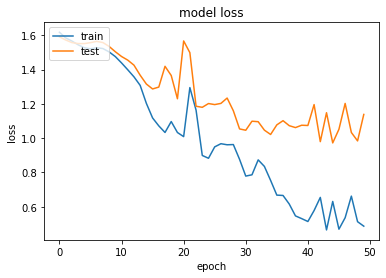

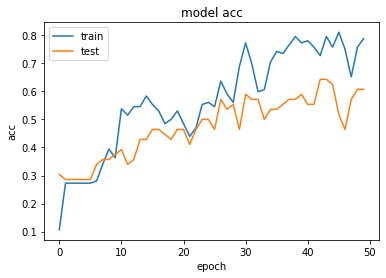

1/2 [==============>...............] - ETA: 0s - loss: 0.8825 - acc: 0.7188

2/2 [==============================] - 0s 17ms/step - loss: 1.1382 - acc: 0.6071


Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_97 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_150 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_46 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_151 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6105 - acc: 0.1970 - val_loss: 1.5828 - val_acc: 0.3393


Epoch 2/50
2/2 - 0s - loss: 1.5745 - acc: 0.3409 - val_loss: 1.5589 - val_acc: 0.3750


Epoch 3/50


2/2 - 0s - loss: 1.5496 - acc: 0.3561 - val_loss: 1.5358 - val_acc: 0.3214


Epoch 4/50


2/2 - 0s - loss: 1.5358 - acc: 0.2879 - val_loss: 1.5210 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5221 - acc: 0.3106 - val_loss: 1.5144 - val_acc: 0.3393


Epoch 6/50


2/2 - 0s - loss: 1.5142 - acc: 0.3864 - val_loss: 1.5086 - val_acc: 0.2679


Epoch 7/50
2/2 - 0s - loss: 1.4910 - acc: 0.2955 - val_loss: 1.5091 - val_acc: 0.2857


Epoch 8/50


2/2 - 0s - loss: 1.4790 - acc: 0.2879 - val_loss: 1.5194 - val_acc: 0.2857


Epoch 9/50
2/2 - 0s - loss: 1.4777 - acc: 0.2803 - val_loss: 1.5200 - val_acc: 0.2857


Epoch 10/50


2/2 - 0s - loss: 1.4705 - acc: 0.2803 - val_loss: 1.5053 - val_acc: 0.2857


Epoch 11/50


2/2 - 0s - loss: 1.4531 - acc: 0.2879 - val_loss: 1.4728 - val_acc: 0.3036


Epoch 12/50
2/2 - 0s - loss: 1.3964 - acc: 0.3333 - val_loss: 1.4435 - val_acc: 0.3036


Epoch 13/50
2/2 - 0s - loss: 1.3432 - acc: 0.3712 - val_loss: 1.4340 - val_acc: 0.3750


Epoch 14/50


2/2 - 0s - loss: 1.3134 - acc: 0.4773 - val_loss: 1.4012 - val_acc: 0.4107


Epoch 15/50


2/2 - 0s - loss: 1.2535 - acc: 0.4621 - val_loss: 1.3539 - val_acc: 0.4821


Epoch 16/50


2/2 - 0s - loss: 1.1626 - acc: 0.5606 - val_loss: 1.3505 - val_acc: 0.3929


Epoch 17/50


2/2 - 0s - loss: 1.1177 - acc: 0.5455 - val_loss: 1.3588 - val_acc: 0.4464


Epoch 18/50


2/2 - 0s - loss: 1.1230 - acc: 0.5076 - val_loss: 1.1987 - val_acc: 0.4464


Epoch 19/50


2/2 - 0s - loss: 0.9497 - acc: 0.5985 - val_loss: 1.2221 - val_acc: 0.5000


Epoch 20/50


2/2 - 0s - loss: 0.9797 - acc: 0.5909 - val_loss: 1.2638 - val_acc: 0.5179


Epoch 21/50


2/2 - 0s - loss: 0.9749 - acc: 0.5758 - val_loss: 1.2592 - val_acc: 0.5000


Epoch 22/50


2/2 - 0s - loss: 0.9337 - acc: 0.5379 - val_loss: 1.1384 - val_acc: 0.5893


Epoch 23/50


2/2 - 0s - loss: 0.8596 - acc: 0.7348 - val_loss: 1.1303 - val_acc: 0.4286


Epoch 24/50


2/2 - 0s - loss: 0.8516 - acc: 0.6439 - val_loss: 1.1477 - val_acc: 0.4464


Epoch 25/50


2/2 - 0s - loss: 0.8281 - acc: 0.6288 - val_loss: 1.1990 - val_acc: 0.4464


Epoch 26/50


2/2 - 0s - loss: 0.9265 - acc: 0.5606 - val_loss: 1.2330 - val_acc: 0.4821


Epoch 27/50


2/2 - 0s - loss: 0.8610 - acc: 0.6667 - val_loss: 1.2761 - val_acc: 0.5179


Epoch 28/50
2/2 - 0s - loss: 0.8088 - acc: 0.7576 - val_loss: 1.2271 - val_acc: 0.5357


Epoch 29/50


2/2 - 0s - loss: 0.8706 - acc: 0.6591 - val_loss: 1.1497 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.8343 - acc: 0.6894 - val_loss: 1.0247 - val_acc: 0.5893


Epoch 31/50


2/2 - 0s - loss: 0.6574 - acc: 0.7955 - val_loss: 1.0570 - val_acc: 0.5714


Epoch 32/50


2/2 - 0s - loss: 0.6824 - acc: 0.7652 - val_loss: 1.0863 - val_acc: 0.5179


Epoch 33/50


2/2 - 0s - loss: 0.7427 - acc: 0.7197 - val_loss: 1.1556 - val_acc: 0.5000


Epoch 34/50


2/2 - 0s - loss: 0.8233 - acc: 0.6742 - val_loss: 1.1238 - val_acc: 0.5179


Epoch 35/50


2/2 - 0s - loss: 0.7683 - acc: 0.7045 - val_loss: 1.0421 - val_acc: 0.5357


Epoch 36/50


2/2 - 0s - loss: 0.6559 - acc: 0.8182 - val_loss: 1.0684 - val_acc: 0.5536


Epoch 37/50


2/2 - 0s - loss: 0.6073 - acc: 0.8030 - val_loss: 1.0389 - val_acc: 0.5357


Epoch 38/50


2/2 - 0s - loss: 0.5762 - acc: 0.8030 - val_loss: 1.0080 - val_acc: 0.5536


Epoch 39/50


2/2 - 0s - loss: 0.5794 - acc: 0.7955 - val_loss: 0.9890 - val_acc: 0.5357


Epoch 40/50


2/2 - 0s - loss: 0.5464 - acc: 0.8106 - val_loss: 1.0635 - val_acc: 0.5714


Epoch 41/50
2/2 - 0s - loss: 0.4982 - acc: 0.8106 - val_loss: 1.1999 - val_acc: 0.5714


Epoch 42/50


2/2 - 0s - loss: 0.4990 - acc: 0.7955 - val_loss: 1.1333 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.4398 - acc: 0.8333 - val_loss: 1.0469 - val_acc: 0.6250


Epoch 44/50


2/2 - 0s - loss: 0.3796 - acc: 0.8636 - val_loss: 1.0203 - val_acc: 0.6071


Epoch 45/50


2/2 - 0s - loss: 0.3742 - acc: 0.8939 - val_loss: 1.0360 - val_acc: 0.6250


Epoch 46/50


2/2 - 0s - loss: 0.3883 - acc: 0.8864 - val_loss: 1.0802 - val_acc: 0.6071


Epoch 47/50


2/2 - 0s - loss: 0.3865 - acc: 0.8788 - val_loss: 1.2088 - val_acc: 0.6429


Epoch 48/50


2/2 - 0s - loss: 0.3385 - acc: 0.8939 - val_loss: 1.5875 - val_acc: 0.5536


Epoch 49/50


2/2 - 0s - loss: 0.5399 - acc: 0.7955 - val_loss: 1.2033 - val_acc: 0.6250


Epoch 50/50


2/2 - 0s - loss: 0.3578 - acc: 0.8485 - val_loss: 0.9302 - val_acc: 0.5893


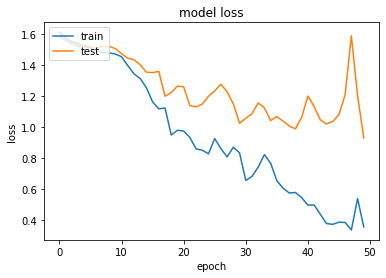

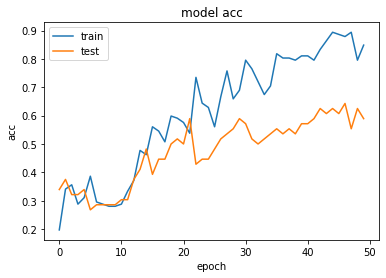

1/2 [==============>...............] - ETA: 0s - loss: 0.8706 - acc: 0.6250

2/2 [==============================] - 0s 19ms/step - loss: 0.9302 - acc: 0.5893


Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_99 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
dropout_152 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_47 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_153 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6062 - acc: 0.2955 - val_loss: 1.5863 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5830 - acc: 0.2879 - val_loss: 1.5768 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5715 - acc: 0.2879 - val_loss: 1.5574 - val_acc: 0.3214


Epoch 4/50


2/2 - 0s - loss: 1.5603 - acc: 0.2879 - val_loss: 1.5363 - val_acc: 0.3214


Epoch 5/50


2/2 - 0s - loss: 1.5461 - acc: 0.2879 - val_loss: 1.5263 - val_acc: 0.3214


Epoch 6/50


2/2 - 0s - loss: 1.5487 - acc: 0.2879 - val_loss: 1.5085 - val_acc: 0.3214


Epoch 7/50
2/2 - 0s - loss: 1.5104 - acc: 0.3182 - val_loss: 1.4978 - val_acc: 0.3036


Epoch 8/50


2/2 - 0s - loss: 1.4782 - acc: 0.3712 - val_loss: 1.4821 - val_acc: 0.3036


Epoch 9/50
2/2 - 0s - loss: 1.4416 - acc: 0.4167 - val_loss: 1.4543 - val_acc: 0.4107


Epoch 10/50
2/2 - 0s - loss: 1.4137 - acc: 0.3636 - val_loss: 1.4378 - val_acc: 0.4107


Epoch 11/50
2/2 - 0s - loss: 1.3708 - acc: 0.3939 - val_loss: 1.4480 - val_acc: 0.4107


Epoch 12/50
2/2 - 0s - loss: 1.3425 - acc: 0.4242 - val_loss: 1.4745 - val_acc: 0.3393


Epoch 13/50


2/2 - 0s - loss: 1.3348 - acc: 0.4318 - val_loss: 1.4588 - val_acc: 0.4107


Epoch 14/50


2/2 - 0s - loss: 1.3449 - acc: 0.4167 - val_loss: 1.4131 - val_acc: 0.3929


Epoch 15/50


2/2 - 0s - loss: 1.2629 - acc: 0.4470 - val_loss: 1.4008 - val_acc: 0.4643


Epoch 16/50


2/2 - 0s - loss: 1.2340 - acc: 0.4924 - val_loss: 1.4095 - val_acc: 0.4107


Epoch 17/50
2/2 - 0s - loss: 1.2504 - acc: 0.4773 - val_loss: 1.3949 - val_acc: 0.3750


Epoch 18/50


2/2 - 0s - loss: 1.2488 - acc: 0.4470 - val_loss: 1.3996 - val_acc: 0.3393


Epoch 19/50
2/2 - 0s - loss: 1.2584 - acc: 0.4015 - val_loss: 1.3774 - val_acc: 0.3750


Epoch 20/50
2/2 - 0s - loss: 1.2033 - acc: 0.4545 - val_loss: 1.3093 - val_acc: 0.4107


Epoch 21/50
2/2 - 0s - loss: 1.0961 - acc: 0.5303 - val_loss: 1.2322 - val_acc: 0.4107


Epoch 22/50
2/2 - 0s - loss: 1.0131 - acc: 0.5909 - val_loss: 1.2618 - val_acc: 0.4107


Epoch 23/50


2/2 - 0s - loss: 1.0455 - acc: 0.5833 - val_loss: 1.2092 - val_acc: 0.4464


Epoch 24/50


2/2 - 0s - loss: 1.0334 - acc: 0.5379 - val_loss: 1.2748 - val_acc: 0.5000


Epoch 25/50


2/2 - 0s - loss: 1.1353 - acc: 0.4924 - val_loss: 1.1873 - val_acc: 0.5179


Epoch 26/50


2/2 - 0s - loss: 1.0049 - acc: 0.6061 - val_loss: 1.2059 - val_acc: 0.4643


Epoch 27/50


2/2 - 0s - loss: 0.9851 - acc: 0.6818 - val_loss: 1.2690 - val_acc: 0.4464


Epoch 28/50

2/2 - 0s - loss: 1.0086 - acc: 0.6742 - val_loss: 1.2487 - val_acc: 0.4464


Epoch 29/50


2/2 - 0s - loss: 0.9704 - acc: 0.6894 - val_loss: 1.1973 - val_acc: 0.4643


Epoch 30/50


2/2 - 0s - loss: 0.8973 - acc: 0.6742 - val_loss: 1.1541 - val_acc: 0.5000


Epoch 31/50


2/2 - 0s - loss: 0.8259 - acc: 0.7500 - val_loss: 1.1511 - val_acc: 0.5179


Epoch 32/50


2/2 - 0s - loss: 0.8413 - acc: 0.7045 - val_loss: 1.1137 - val_acc: 0.5536


Epoch 33/50


2/2 - 0s - loss: 0.7916 - acc: 0.7576 - val_loss: 1.1292 - val_acc: 0.5000


Epoch 34/50


2/2 - 0s - loss: 0.7782 - acc: 0.7121 - val_loss: 1.2742 - val_acc: 0.4643


Epoch 35/50


2/2 - 0s - loss: 0.8932 - acc: 0.7045 - val_loss: 1.3093 - val_acc: 0.4464


Epoch 36/50


2/2 - 0s - loss: 0.9242 - acc: 0.6591 - val_loss: 1.1684 - val_acc: 0.4643


Epoch 37/50


2/2 - 0s - loss: 0.7745 - acc: 0.7348 - val_loss: 1.0799 - val_acc: 0.5000


Epoch 38/50


2/2 - 0s - loss: 0.7015 - acc: 0.7803 - val_loss: 1.0730 - val_acc: 0.5000


Epoch 39/50


2/2 - 0s - loss: 0.6708 - acc: 0.7348 - val_loss: 1.1325 - val_acc: 0.5179


Epoch 40/50
2/2 - 0s - loss: 0.6528 - acc: 0.7727 - val_loss: 1.1949 - val_acc: 0.5357


Epoch 41/50


2/2 - 0s - loss: 0.6572 - acc: 0.7500 - val_loss: 1.1944 - val_acc: 0.5000


Epoch 42/50


2/2 - 0s - loss: 0.6112 - acc: 0.7500 - val_loss: 1.1776 - val_acc: 0.5000


Epoch 43/50


2/2 - 0s - loss: 0.5996 - acc: 0.7500 - val_loss: 1.1331 - val_acc: 0.5179


Epoch 44/50


2/2 - 0s - loss: 0.5245 - acc: 0.8106 - val_loss: 1.0518 - val_acc: 0.5357


Epoch 45/50


2/2 - 0s - loss: 0.5124 - acc: 0.8485 - val_loss: 1.0286 - val_acc: 0.5893


Epoch 46/50


2/2 - 0s - loss: 0.5993 - acc: 0.7727 - val_loss: 0.9923 - val_acc: 0.5893


Epoch 47/50

2/2 - 0s - loss: 0.5005 - acc: 0.8106 - val_loss: 1.1851 - val_acc: 0.5536


Epoch 48/50


2/2 - 0s - loss: 0.4605 - acc: 0.8712 - val_loss: 1.4020 - val_acc: 0.5714


Epoch 49/50


2/2 - 0s - loss: 0.6427 - acc: 0.7576 - val_loss: 1.3258 - val_acc: 0.6429


Epoch 50/50


2/2 - 0s - loss: 0.5126 - acc: 0.8258 - val_loss: 0.9774 - val_acc: 0.5536


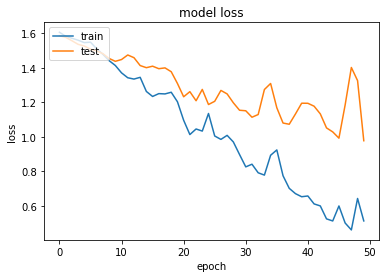

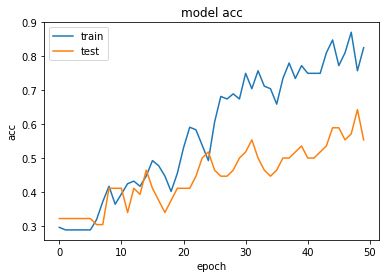

1/2 [==============>...............] - ETA: 0s - loss: 0.8610 - acc: 0.6250

2/2 [==============================] - 0s 19ms/step - loss: 0.9774 - acc: 0.5536


Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_101 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_154 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_48 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_155 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6099 - acc: 0.1894 - val_loss: 1.5825 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5832 - acc: 0.2803 - val_loss: 1.5668 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5587 - acc: 0.2955 - val_loss: 1.5599 - val_acc: 0.3571


Epoch 4/50
2/2 - 0s - loss: 1.5471 - acc: 0.3485 - val_loss: 1.5488 - val_acc: 0.3929


Epoch 5/50


2/2 - 0s - loss: 1.5355 - acc: 0.3636 - val_loss: 1.5365 - val_acc: 0.3036


Epoch 6/50
2/2 - 0s - loss: 1.5245 - acc: 0.3636 - val_loss: 1.5303 - val_acc: 0.3214


Epoch 7/50
2/2 - 0s - loss: 1.5107 - acc: 0.2955 - val_loss: 1.5227 - val_acc: 0.3036


Epoch 8/50
2/2 - 0s - loss: 1.4931 - acc: 0.2727 - val_loss: 1.5177 - val_acc: 0.3036


Epoch 9/50


2/2 - 0s - loss: 1.4827 - acc: 0.2727 - val_loss: 1.5184 - val_acc: 0.2857


Epoch 10/50
2/2 - 0s - loss: 1.4840 - acc: 0.2727 - val_loss: 1.5171 - val_acc: 0.2857


Epoch 11/50
2/2 - 0s - loss: 1.4701 - acc: 0.2727 - val_loss: 1.4936 - val_acc: 0.3036


Epoch 12/50
2/2 - 0s - loss: 1.4342 - acc: 0.3106 - val_loss: 1.4626 - val_acc: 0.3750


Epoch 13/50


2/2 - 0s - loss: 1.3847 - acc: 0.4015 - val_loss: 1.4370 - val_acc: 0.4107


Epoch 14/50


2/2 - 0s - loss: 1.3468 - acc: 0.5303 - val_loss: 1.4128 - val_acc: 0.4107


Epoch 15/50


2/2 - 0s - loss: 1.3109 - acc: 0.5379 - val_loss: 1.3792 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.2616 - acc: 0.5455 - val_loss: 1.3548 - val_acc: 0.4821


Epoch 17/50


2/2 - 0s - loss: 1.2061 - acc: 0.5379 - val_loss: 1.3176 - val_acc: 0.4464


Epoch 18/50
2/2 - 0s - loss: 1.1312 - acc: 0.5758 - val_loss: 1.3042 - val_acc: 0.3750


Epoch 19/50


2/2 - 0s - loss: 1.1085 - acc: 0.5909 - val_loss: 1.2898 - val_acc: 0.4286


Epoch 20/50


2/2 - 0s - loss: 1.0825 - acc: 0.5682 - val_loss: 1.3328 - val_acc: 0.3929


Epoch 21/50


2/2 - 0s - loss: 1.0838 - acc: 0.5682 - val_loss: 1.3111 - val_acc: 0.3929


Epoch 22/50


2/2 - 0s - loss: 1.0190 - acc: 0.6136 - val_loss: 1.2545 - val_acc: 0.4286


Epoch 23/50


2/2 - 0s - loss: 1.0297 - acc: 0.5455 - val_loss: 1.4276 - val_acc: 0.3929


Epoch 24/50


2/2 - 0s - loss: 1.2520 - acc: 0.4091 - val_loss: 1.3957 - val_acc: 0.4464


Epoch 25/50
2/2 - 0s - loss: 1.1217 - acc: 0.5455 - val_loss: 1.5446 - val_acc: 0.4643


Epoch 26/50


2/2 - 0s - loss: 1.1299 - acc: 0.5227 - val_loss: 1.4956 - val_acc: 0.5000


Epoch 27/50


2/2 - 0s - loss: 1.0892 - acc: 0.6212 - val_loss: 1.3064 - val_acc: 0.4643


Epoch 28/50


2/2 - 0s - loss: 0.8982 - acc: 0.6364 - val_loss: 1.1582 - val_acc: 0.4821


Epoch 29/50
2/2 - 0s - loss: 0.7685 - acc: 0.6515 - val_loss: 1.2226 - val_acc: 0.4643


Epoch 30/50
2/2 - 0s - loss: 0.8627 - acc: 0.6591 - val_loss: 1.2542 - val_acc: 0.4286


Epoch 31/50


2/2 - 0s - loss: 0.8892 - acc: 0.6591 - val_loss: 1.1875 - val_acc: 0.4464


Epoch 32/50


2/2 - 0s - loss: 0.7318 - acc: 0.7576 - val_loss: 1.2420 - val_acc: 0.4821


Epoch 33/50


2/2 - 0s - loss: 0.7610 - acc: 0.7045 - val_loss: 1.2290 - val_acc: 0.5179


Epoch 34/50
2/2 - 0s - loss: 0.6971 - acc: 0.7576 - val_loss: 1.1399 - val_acc: 0.4821


Epoch 35/50


2/2 - 0s - loss: 0.6435 - acc: 0.7652 - val_loss: 1.1150 - val_acc: 0.4643


Epoch 36/50


2/2 - 0s - loss: 0.6306 - acc: 0.8182 - val_loss: 1.0952 - val_acc: 0.5000


Epoch 37/50


2/2 - 0s - loss: 0.6187 - acc: 0.8106 - val_loss: 1.0305 - val_acc: 0.5179


Epoch 38/50


2/2 - 0s - loss: 0.5370 - acc: 0.8258 - val_loss: 1.0426 - val_acc: 0.5357


Epoch 39/50


2/2 - 0s - loss: 0.4745 - acc: 0.8485 - val_loss: 1.1315 - val_acc: 0.5536


Epoch 40/50


2/2 - 0s - loss: 0.5285 - acc: 0.8182 - val_loss: 1.1391 - val_acc: 0.5536


Epoch 41/50


2/2 - 0s - loss: 0.5121 - acc: 0.8106 - val_loss: 1.0734 - val_acc: 0.6071


Epoch 42/50


2/2 - 0s - loss: 0.4450 - acc: 0.8333 - val_loss: 1.0297 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.3822 - acc: 0.8636 - val_loss: 0.9998 - val_acc: 0.5357


Epoch 44/50


2/2 - 0s - loss: 0.3872 - acc: 0.8636 - val_loss: 0.9232 - val_acc: 0.5714


Epoch 45/50


2/2 - 0s - loss: 0.3136 - acc: 0.8788 - val_loss: 0.8577 - val_acc: 0.6786


Epoch 46/50


2/2 - 0s - loss: 0.2972 - acc: 0.8712 - val_loss: 0.8337 - val_acc: 0.6607


Epoch 47/50


2/2 - 0s - loss: 0.2671 - acc: 0.8939 - val_loss: 1.2658 - val_acc: 0.5179


Epoch 48/50


2/2 - 0s - loss: 0.7095 - acc: 0.7727 - val_loss: 1.1365 - val_acc: 0.5000


Epoch 49/50
2/2 - 0s - loss: 0.5375 - acc: 0.8106 - val_loss: 1.0723 - val_acc: 0.5714


Epoch 50/50
2/2 - 0s - loss: 0.2645 - acc: 0.9091 - val_loss: 1.2569 - val_acc: 0.5714


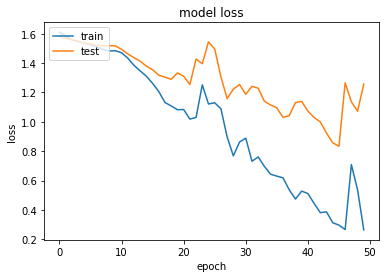

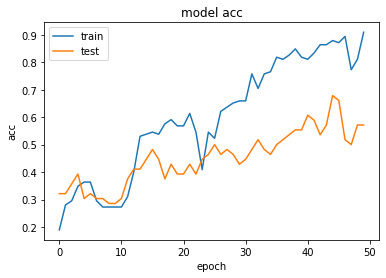

1/2 [==============>...............] - ETA: 0s - loss: 1.1207 - acc: 0.6250

2/2 [==============================] - 0s 20ms/step - loss: 1.2569 - acc: 0.5714


Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_103 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_156 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_49 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_157 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6177 - acc: 0.1364 - val_loss: 1.5870 - val_acc: 0.3036


Epoch 2/50
2/2 - 0s - loss: 1.5830 - acc: 0.3561 - val_loss: 1.5730 - val_acc: 0.2857


Epoch 3/50


2/2 - 0s - loss: 1.5619 - acc: 0.3106 - val_loss: 1.5654 - val_acc: 0.2857


Epoch 4/50
2/2 - 0s - loss: 1.5510 - acc: 0.3333 - val_loss: 1.5523 - val_acc: 0.2679


Epoch 5/50


2/2 - 0s - loss: 1.5391 - acc: 0.3712 - val_loss: 1.5442 - val_acc: 0.2679


Epoch 6/50
2/2 - 0s - loss: 1.5253 - acc: 0.3561 - val_loss: 1.5407 - val_acc: 0.2500


Epoch 7/50


2/2 - 0s - loss: 1.5200 - acc: 0.3636 - val_loss: 1.5390 - val_acc: 0.3214


Epoch 8/50


2/2 - 0s - loss: 1.5048 - acc: 0.3106 - val_loss: 1.5360 - val_acc: 0.3036


Epoch 9/50


2/2 - 0s - loss: 1.4959 - acc: 0.2803 - val_loss: 1.5273 - val_acc: 0.3036


Epoch 10/50


2/2 - 0s - loss: 1.4847 - acc: 0.2803 - val_loss: 1.5191 - val_acc: 0.3036


Epoch 11/50


2/2 - 0s - loss: 1.4573 - acc: 0.2803 - val_loss: 1.5042 - val_acc: 0.3214


Epoch 12/50


2/2 - 0s - loss: 1.4368 - acc: 0.3182 - val_loss: 1.4750 - val_acc: 0.2857


Epoch 13/50
2/2 - 0s - loss: 1.3966 - acc: 0.4773 - val_loss: 1.4536 - val_acc: 0.3750


Epoch 14/50


2/2 - 0s - loss: 1.3518 - acc: 0.5000 - val_loss: 1.4426 - val_acc: 0.3929


Epoch 15/50


2/2 - 0s - loss: 1.3145 - acc: 0.5000 - val_loss: 1.4185 - val_acc: 0.3571


Epoch 16/50


2/2 - 0s - loss: 1.2466 - acc: 0.5530 - val_loss: 1.3942 - val_acc: 0.3571


Epoch 17/50


2/2 - 0s - loss: 1.1760 - acc: 0.5606 - val_loss: 1.3653 - val_acc: 0.4286


Epoch 18/50


2/2 - 0s - loss: 1.1115 - acc: 0.5909 - val_loss: 1.3791 - val_acc: 0.4643


Epoch 19/50


2/2 - 0s - loss: 1.0621 - acc: 0.6364 - val_loss: 1.3700 - val_acc: 0.5357


Epoch 20/50


2/2 - 0s - loss: 1.0645 - acc: 0.6591 - val_loss: 1.3847 - val_acc: 0.4821


Epoch 21/50


2/2 - 0s - loss: 1.0730 - acc: 0.5985 - val_loss: 1.3678 - val_acc: 0.4643


Epoch 22/50


2/2 - 0s - loss: 1.0228 - acc: 0.5758 - val_loss: 1.2677 - val_acc: 0.5357


Epoch 23/50


2/2 - 0s - loss: 0.8468 - acc: 0.7348 - val_loss: 1.3280 - val_acc: 0.4464


Epoch 24/50


2/2 - 0s - loss: 0.8577 - acc: 0.6515 - val_loss: 1.3944 - val_acc: 0.4643


Epoch 25/50


2/2 - 0s - loss: 0.8326 - acc: 0.6364 - val_loss: 1.2152 - val_acc: 0.5536


Epoch 26/50


2/2 - 0s - loss: 0.7711 - acc: 0.6894 - val_loss: 1.1677 - val_acc: 0.5357


Epoch 27/50


2/2 - 0s - loss: 0.7561 - acc: 0.7197 - val_loss: 1.2687 - val_acc: 0.5536


Epoch 28/50


2/2 - 0s - loss: 0.8404 - acc: 0.6288 - val_loss: 1.2702 - val_acc: 0.5714


Epoch 29/50


2/2 - 0s - loss: 0.8634 - acc: 0.6439 - val_loss: 1.1235 - val_acc: 0.5714


Epoch 30/50


2/2 - 0s - loss: 0.6699 - acc: 0.7273 - val_loss: 1.1080 - val_acc: 0.6250


Epoch 31/50


2/2 - 0s - loss: 0.6358 - acc: 0.7576 - val_loss: 1.1061 - val_acc: 0.6250


Epoch 32/50


2/2 - 0s - loss: 0.5439 - acc: 0.8106 - val_loss: 1.1061 - val_acc: 0.6250


Epoch 33/50


2/2 - 0s - loss: 0.5180 - acc: 0.8030 - val_loss: 1.1274 - val_acc: 0.6071


Epoch 34/50


2/2 - 0s - loss: 0.4946 - acc: 0.7955 - val_loss: 1.1805 - val_acc: 0.5536


Epoch 35/50


2/2 - 0s - loss: 0.5182 - acc: 0.8030 - val_loss: 1.2285 - val_acc: 0.5536


Epoch 36/50


2/2 - 0s - loss: 0.5713 - acc: 0.7879 - val_loss: 1.1805 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.5472 - acc: 0.8030 - val_loss: 1.1410 - val_acc: 0.5179


Epoch 38/50


2/2 - 0s - loss: 0.4953 - acc: 0.8182 - val_loss: 1.0491 - val_acc: 0.5357


Epoch 39/50


2/2 - 0s - loss: 0.4674 - acc: 0.8409 - val_loss: 1.0336 - val_acc: 0.5893


Epoch 40/50


2/2 - 0s - loss: 0.4999 - acc: 0.7955 - val_loss: 1.1090 - val_acc: 0.5893


Epoch 41/50


2/2 - 0s - loss: 0.5989 - acc: 0.7576 - val_loss: 1.0945 - val_acc: 0.6429


Epoch 42/50


2/2 - 0s - loss: 0.4845 - acc: 0.8182 - val_loss: 1.0729 - val_acc: 0.6250


Epoch 43/50


2/2 - 0s - loss: 0.4136 - acc: 0.8636 - val_loss: 1.0676 - val_acc: 0.6429


Epoch 44/50


2/2 - 0s - loss: 0.3781 - acc: 0.8788 - val_loss: 1.1120 - val_acc: 0.5714


Epoch 45/50


2/2 - 0s - loss: 0.4300 - acc: 0.8333 - val_loss: 1.1991 - val_acc: 0.5000


Epoch 46/50


2/2 - 0s - loss: 0.4588 - acc: 0.8106 - val_loss: 1.1814 - val_acc: 0.6071


Epoch 47/50


2/2 - 0s - loss: 0.4154 - acc: 0.8409 - val_loss: 1.3205 - val_acc: 0.5536


Epoch 48/50


2/2 - 0s - loss: 0.6223 - acc: 0.7652 - val_loss: 1.8244 - val_acc: 0.5179


Epoch 49/50


2/2 - 0s - loss: 1.0858 - acc: 0.6742 - val_loss: 1.7202 - val_acc: 0.5179


Epoch 50/50


2/2 - 0s - loss: 0.9818 - acc: 0.6970 - val_loss: 1.2070 - val_acc: 0.6429


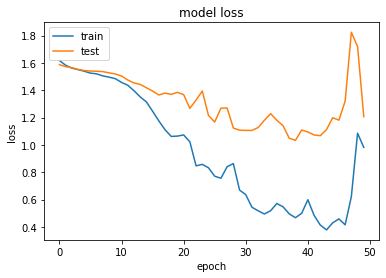

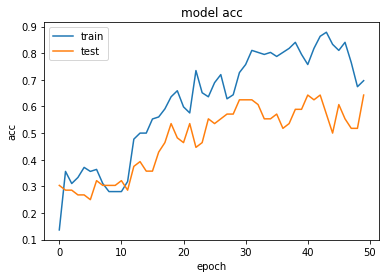

1/2 [==============>...............] - ETA: 0s - loss: 1.1017 - acc: 0.5938

2/2 [==============================] - 0s 20ms/step - loss: 1.2070 - acc: 0.6429


Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_105 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_158 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_50 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_159 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6143 - acc: 0.1439 - val_loss: 1.5845 - val_acc: 0.3393


Epoch 2/50
2/2 - 0s - loss: 1.5809 - acc: 0.3409 - val_loss: 1.5605 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5665 - acc: 0.2955 - val_loss: 1.5498 - val_acc: 0.3214


Epoch 4/50


2/2 - 0s - loss: 1.5589 - acc: 0.2879 - val_loss: 1.5452 - val_acc: 0.3393


Epoch 5/50


2/2 - 0s - loss: 1.5459 - acc: 0.3636 - val_loss: 1.5435 - val_acc: 0.3036


Epoch 6/50
2/2 - 0s - loss: 1.5380 - acc: 0.2803 - val_loss: 1.5481 - val_acc: 0.2857


Epoch 7/50


2/2 - 0s - loss: 1.5334 - acc: 0.2727 - val_loss: 1.5502 - val_acc: 0.2857


Epoch 8/50
2/2 - 0s - loss: 1.5378 - acc: 0.2727 - val_loss: 1.5480 - val_acc: 0.3036


Epoch 9/50
2/2 - 0s - loss: 1.5307 - acc: 0.2727 - val_loss: 1.5380 - val_acc: 0.3036


Epoch 10/50
2/2 - 0s - loss: 1.5016 - acc: 0.2803 - val_loss: 1.5188 - val_acc: 0.3036


Epoch 11/50
2/2 - 0s - loss: 1.4694 - acc: 0.2879 - val_loss: 1.5166 - val_acc: 0.3214


Epoch 12/50
2/2 - 0s - loss: 1.4651 - acc: 0.3864 - val_loss: 1.5226 - val_acc: 0.4107


Epoch 13/50
2/2 - 0s - loss: 1.4791 - acc: 0.4470 - val_loss: 1.5237 - val_acc: 0.3929


Epoch 14/50


2/2 - 0s - loss: 1.4657 - acc: 0.4773 - val_loss: 1.5087 - val_acc: 0.3750


Epoch 15/50
2/2 - 0s - loss: 1.4565 - acc: 0.4091 - val_loss: 1.4897 - val_acc: 0.3393


Epoch 16/50


2/2 - 0s - loss: 1.4243 - acc: 0.3712 - val_loss: 1.4717 - val_acc: 0.3393


Epoch 17/50


2/2 - 0s - loss: 1.4003 - acc: 0.3636 - val_loss: 1.4485 - val_acc: 0.3750


Epoch 18/50


2/2 - 0s - loss: 1.3424 - acc: 0.4773 - val_loss: 1.4210 - val_acc: 0.3929


Epoch 19/50


2/2 - 0s - loss: 1.2884 - acc: 0.4848 - val_loss: 1.3953 - val_acc: 0.3929


Epoch 20/50


2/2 - 0s - loss: 1.2542 - acc: 0.4621 - val_loss: 1.3907 - val_acc: 0.3214


Epoch 21/50


2/2 - 0s - loss: 1.2167 - acc: 0.4848 - val_loss: 1.3666 - val_acc: 0.3750


Epoch 22/50

2/2 - 0s - loss: 1.1434 - acc: 0.5303 - val_loss: 1.3594 - val_acc: 0.4464


Epoch 23/50


2/2 - 0s - loss: 1.1076 - acc: 0.5758 - val_loss: 1.3711 - val_acc: 0.4821


Epoch 24/50


2/2 - 0s - loss: 1.0991 - acc: 0.5758 - val_loss: 1.3850 - val_acc: 0.4464


Epoch 25/50


2/2 - 0s - loss: 1.0909 - acc: 0.5379 - val_loss: 1.2599 - val_acc: 0.5357


Epoch 26/50


2/2 - 0s - loss: 0.8985 - acc: 0.6061 - val_loss: 1.3681 - val_acc: 0.5179


Epoch 27/50


2/2 - 0s - loss: 1.0854 - acc: 0.5379 - val_loss: 1.3564 - val_acc: 0.5893


Epoch 28/50


2/2 - 0s - loss: 1.0392 - acc: 0.6288 - val_loss: 1.1385 - val_acc: 0.5893


Epoch 29/50
2/2 - 0s - loss: 0.8624 - acc: 0.7500 - val_loss: 1.0778 - val_acc: 0.5536


Epoch 30/50
2/2 - 0s - loss: 0.8425 - acc: 0.7121 - val_loss: 1.0889 - val_acc: 0.5893


Epoch 31/50
2/2 - 0s - loss: 0.8168 - acc: 0.7121 - val_loss: 1.0676 - val_acc: 0.5714


Epoch 32/50


2/2 - 0s - loss: 0.7682 - acc: 0.7424 - val_loss: 1.0658 - val_acc: 0.6250


Epoch 33/50
2/2 - 0s - loss: 0.7415 - acc: 0.7273 - val_loss: 1.0633 - val_acc: 0.6250


Epoch 34/50


2/2 - 0s - loss: 0.7010 - acc: 0.7500 - val_loss: 1.1651 - val_acc: 0.5536


Epoch 35/50
2/2 - 0s - loss: 0.7316 - acc: 0.6970 - val_loss: 1.3497 - val_acc: 0.4464


Epoch 36/50


2/2 - 0s - loss: 0.8383 - acc: 0.6742 - val_loss: 1.1206 - val_acc: 0.6429


Epoch 37/50


2/2 - 0s - loss: 0.6297 - acc: 0.7500 - val_loss: 0.9682 - val_acc: 0.6250


Epoch 38/50


2/2 - 0s - loss: 0.6466 - acc: 0.7727 - val_loss: 1.0803 - val_acc: 0.5536


Epoch 39/50


2/2 - 0s - loss: 0.8146 - acc: 0.6439 - val_loss: 1.0413 - val_acc: 0.5893


Epoch 40/50


2/2 - 0s - loss: 0.7535 - acc: 0.6818 - val_loss: 0.9730 - val_acc: 0.6607


Epoch 41/50


2/2 - 0s - loss: 0.6134 - acc: 0.7652 - val_loss: 0.8897 - val_acc: 0.6429


Epoch 42/50


2/2 - 0s - loss: 0.4874 - acc: 0.8409 - val_loss: 0.9446 - val_acc: 0.6429


Epoch 43/50


2/2 - 0s - loss: 0.5097 - acc: 0.8409 - val_loss: 1.0080 - val_acc: 0.6250


Epoch 44/50


2/2 - 0s - loss: 0.5457 - acc: 0.7803 - val_loss: 0.9841 - val_acc: 0.6786


Epoch 45/50


2/2 - 0s - loss: 0.4935 - acc: 0.8333 - val_loss: 0.9079 - val_acc: 0.6429


Epoch 46/50


2/2 - 0s - loss: 0.4914 - acc: 0.8258 - val_loss: 0.9492 - val_acc: 0.6250


Epoch 47/50


2/2 - 0s - loss: 0.5257 - acc: 0.8182 - val_loss: 0.9642 - val_acc: 0.6429


Epoch 48/50


2/2 - 0s - loss: 0.5592 - acc: 0.8182 - val_loss: 0.9547 - val_acc: 0.6964


Epoch 49/50


2/2 - 0s - loss: 0.4795 - acc: 0.8409 - val_loss: 0.9806 - val_acc: 0.6607


Epoch 50/50


2/2 - 0s - loss: 0.4139 - acc: 0.8636 - val_loss: 1.0736 - val_acc: 0.5714


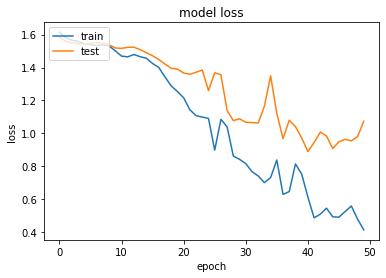

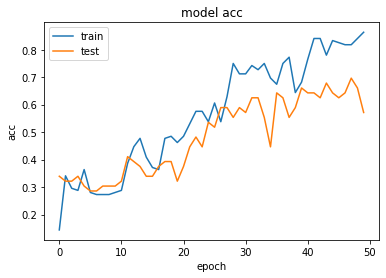

1/2 [==============>...............] - ETA: 0s - loss: 0.8263 - acc: 0.6250

2/2 [==============================] - 0s 19ms/step - loss: 1.0736 - acc: 0.5714


Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_107 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_160 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_51 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_161 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6127 - acc: 0.1591 - val_loss: 1.5823 - val_acc: 0.3571


Epoch 2/50
2/2 - 0s - loss: 1.5777 - acc: 0.3258 - val_loss: 1.5556 - val_acc: 0.3393


Epoch 3/50


2/2 - 0s - loss: 1.5505 - acc: 0.3409 - val_loss: 1.5282 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5301 - acc: 0.2879 - val_loss: 1.5234 - val_acc: 0.3929


Epoch 5/50
2/2 - 0s - loss: 1.5457 - acc: 0.3485 - val_loss: 1.5346 - val_acc: 0.3214


Epoch 6/50
2/2 - 0s - loss: 1.5574 - acc: 0.3030 - val_loss: 1.5323 - val_acc: 0.3036


Epoch 7/50
2/2 - 0s - loss: 1.5458 - acc: 0.2727 - val_loss: 1.5252 - val_acc: 0.3036


Epoch 8/50


2/2 - 0s - loss: 1.5191 - acc: 0.2727 - val_loss: 1.5062 - val_acc: 0.3036


Epoch 9/50


2/2 - 0s - loss: 1.4810 - acc: 0.2727 - val_loss: 1.4964 - val_acc: 0.3393


Epoch 10/50


2/2 - 0s - loss: 1.4672 - acc: 0.3258 - val_loss: 1.4866 - val_acc: 0.4107


Epoch 11/50


2/2 - 0s - loss: 1.4440 - acc: 0.4773 - val_loss: 1.4630 - val_acc: 0.4464


Epoch 12/50


2/2 - 0s - loss: 1.4151 - acc: 0.5000 - val_loss: 1.4256 - val_acc: 0.4821


Epoch 13/50
2/2 - 0s - loss: 1.3608 - acc: 0.4470 - val_loss: 1.4054 - val_acc: 0.4464


Epoch 14/50


2/2 - 0s - loss: 1.3336 - acc: 0.4167 - val_loss: 1.3945 - val_acc: 0.4464


Epoch 15/50
2/2 - 0s - loss: 1.2993 - acc: 0.4545 - val_loss: 1.3385 - val_acc: 0.4286


Epoch 16/50
2/2 - 0s - loss: 1.2125 - acc: 0.5606 - val_loss: 1.3129 - val_acc: 0.5000


Epoch 17/50


2/2 - 0s - loss: 1.1797 - acc: 0.5000 - val_loss: 1.2799 - val_acc: 0.4643


Epoch 18/50


2/2 - 0s - loss: 1.1180 - acc: 0.4848 - val_loss: 1.3506 - val_acc: 0.4107


Epoch 19/50


2/2 - 0s - loss: 1.1735 - acc: 0.4091 - val_loss: 1.3553 - val_acc: 0.4286


Epoch 20/50


2/2 - 0s - loss: 1.1375 - acc: 0.4242 - val_loss: 1.2182 - val_acc: 0.5179


Epoch 21/50


2/2 - 0s - loss: 0.9906 - acc: 0.6515 - val_loss: 1.1584 - val_acc: 0.4643


Epoch 22/50


2/2 - 0s - loss: 0.9316 - acc: 0.6515 - val_loss: 1.1556 - val_acc: 0.4643


Epoch 23/50


2/2 - 0s - loss: 0.9104 - acc: 0.6591 - val_loss: 1.1507 - val_acc: 0.4643


Epoch 24/50


2/2 - 0s - loss: 0.8578 - acc: 0.6591 - val_loss: 1.1181 - val_acc: 0.5357


Epoch 25/50


2/2 - 0s - loss: 0.8018 - acc: 0.7045 - val_loss: 1.1519 - val_acc: 0.5536


Epoch 26/50


2/2 - 0s - loss: 0.7884 - acc: 0.6970 - val_loss: 1.1533 - val_acc: 0.5536


Epoch 27/50


2/2 - 0s - loss: 0.7909 - acc: 0.6818 - val_loss: 1.0813 - val_acc: 0.5357


Epoch 28/50


2/2 - 0s - loss: 0.7001 - acc: 0.7727 - val_loss: 1.0754 - val_acc: 0.5536


Epoch 29/50
2/2 - 0s - loss: 0.6861 - acc: 0.7576 - val_loss: 1.0911 - val_acc: 0.5536


Epoch 30/50
2/2 - 0s - loss: 0.6836 - acc: 0.7348 - val_loss: 1.1247 - val_acc: 0.5893


Epoch 31/50
2/2 - 0s - loss: 0.6571 - acc: 0.7197 - val_loss: 1.2235 - val_acc: 0.5536


Epoch 32/50
2/2 - 0s - loss: 0.6355 - acc: 0.7879 - val_loss: 1.5269 - val_acc: 0.5179


Epoch 33/50
2/2 - 0s - loss: 0.7829 - acc: 0.6970 - val_loss: 1.4293 - val_acc: 0.5179


Epoch 34/50


2/2 - 0s - loss: 0.7364 - acc: 0.7121 - val_loss: 1.1184 - val_acc: 0.5893


Epoch 35/50


2/2 - 0s - loss: 0.5528 - acc: 0.8106 - val_loss: 1.1760 - val_acc: 0.6250


Epoch 36/50


2/2 - 0s - loss: 0.6819 - acc: 0.7652 - val_loss: 1.1977 - val_acc: 0.6429


Epoch 37/50


2/2 - 0s - loss: 0.6651 - acc: 0.7652 - val_loss: 1.1084 - val_acc: 0.6250


Epoch 38/50


2/2 - 0s - loss: 0.5199 - acc: 0.8409 - val_loss: 1.0952 - val_acc: 0.5536


Epoch 39/50


2/2 - 0s - loss: 0.4432 - acc: 0.8409 - val_loss: 1.2253 - val_acc: 0.5179


Epoch 40/50


2/2 - 0s - loss: 0.5028 - acc: 0.8030 - val_loss: 1.3056 - val_acc: 0.5357


Epoch 41/50


2/2 - 0s - loss: 0.5315 - acc: 0.8106 - val_loss: 1.2529 - val_acc: 0.5357


Epoch 42/50


2/2 - 0s - loss: 0.5044 - acc: 0.8258 - val_loss: 1.1189 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.4228 - acc: 0.8561 - val_loss: 1.0243 - val_acc: 0.6071


Epoch 44/50

2/2 - 0s - loss: 0.3799 - acc: 0.8485 - val_loss: 0.9939 - val_acc: 0.6607


Epoch 45/50


2/2 - 0s - loss: 0.3820 - acc: 0.8409 - val_loss: 1.1050 - val_acc: 0.5893


Epoch 46/50


2/2 - 0s - loss: 0.4470 - acc: 0.8182 - val_loss: 1.0606 - val_acc: 0.5893


Epoch 47/50


2/2 - 0s - loss: 0.3735 - acc: 0.8409 - val_loss: 1.0226 - val_acc: 0.6250


Epoch 48/50


2/2 - 0s - loss: 0.3229 - acc: 0.8788 - val_loss: 1.2240 - val_acc: 0.5893


Epoch 49/50


2/2 - 0s - loss: 0.4646 - acc: 0.8258 - val_loss: 1.2498 - val_acc: 0.5893


Epoch 50/50


2/2 - 0s - loss: 0.4838 - acc: 0.8333 - val_loss: 1.0091 - val_acc: 0.6250


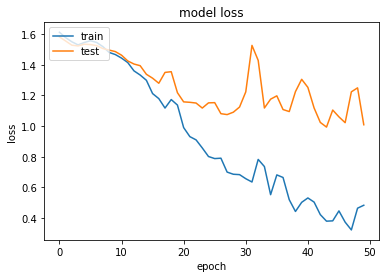

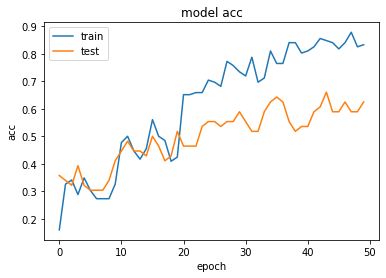

1/2 [==============>...............] - ETA: 0s - loss: 0.7767 - acc: 0.7500

2/2 [==============================] - 0s 18ms/step - loss: 1.0091 - acc: 0.6250


Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_109 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_162 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_52 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_163 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6053 - acc: 0.1970 - val_loss: 1.5794 - val_acc: 0.2857


Epoch 2/50
2/2 - 0s - loss: 1.5703 - acc: 0.2879 - val_loss: 1.5668 - val_acc: 0.2857


Epoch 3/50


2/2 - 0s - loss: 1.5564 - acc: 0.2727 - val_loss: 1.5601 - val_acc: 0.2857


Epoch 4/50
2/2 - 0s - loss: 1.5475 - acc: 0.2727 - val_loss: 1.5506 - val_acc: 0.2857


Epoch 5/50


2/2 - 0s - loss: 1.5354 - acc: 0.2727 - val_loss: 1.5439 - val_acc: 0.2857


Epoch 6/50
2/2 - 0s - loss: 1.5290 - acc: 0.2727 - val_loss: 1.5372 - val_acc: 0.3036


Epoch 7/50
2/2 - 0s - loss: 1.5135 - acc: 0.2727 - val_loss: 1.5350 - val_acc: 0.3036


Epoch 8/50
2/2 - 0s - loss: 1.5133 - acc: 0.2727 - val_loss: 1.5301 - val_acc: 0.3036


Epoch 9/50


2/2 - 0s - loss: 1.5034 - acc: 0.2727 - val_loss: 1.5225 - val_acc: 0.3036


Epoch 10/50
2/2 - 0s - loss: 1.4883 - acc: 0.2879 - val_loss: 1.5185 - val_acc: 0.3214


Epoch 11/50


2/2 - 0s - loss: 1.4773 - acc: 0.3258 - val_loss: 1.5165 - val_acc: 0.3393


Epoch 12/50
2/2 - 0s - loss: 1.4640 - acc: 0.3485 - val_loss: 1.5063 - val_acc: 0.3750


Epoch 13/50


2/2 - 0s - loss: 1.4415 - acc: 0.3788 - val_loss: 1.4855 - val_acc: 0.3750


Epoch 14/50


2/2 - 0s - loss: 1.4147 - acc: 0.3485 - val_loss: 1.4549 - val_acc: 0.3929


Epoch 15/50


2/2 - 0s - loss: 1.3711 - acc: 0.4015 - val_loss: 1.4202 - val_acc: 0.3571


Epoch 16/50


2/2 - 0s - loss: 1.3263 - acc: 0.4621 - val_loss: 1.3959 - val_acc: 0.4464


Epoch 17/50


2/2 - 0s - loss: 1.2817 - acc: 0.5227 - val_loss: 1.3505 - val_acc: 0.3929


Epoch 18/50


2/2 - 0s - loss: 1.2102 - acc: 0.5833 - val_loss: 1.3417 - val_acc: 0.4107


Epoch 19/50


2/2 - 0s - loss: 1.1765 - acc: 0.5076 - val_loss: 1.3884 - val_acc: 0.4286


Epoch 20/50
2/2 - 0s - loss: 1.1978 - acc: 0.4924 - val_loss: 1.2218 - val_acc: 0.4464


Epoch 21/50


2/2 - 0s - loss: 1.0281 - acc: 0.5606 - val_loss: 1.3767 - val_acc: 0.4107


Epoch 22/50


2/2 - 0s - loss: 1.1734 - acc: 0.5606 - val_loss: 1.2707 - val_acc: 0.4643


Epoch 23/50


2/2 - 0s - loss: 1.0222 - acc: 0.6061 - val_loss: 1.2118 - val_acc: 0.5179


Epoch 24/50
2/2 - 0s - loss: 0.9450 - acc: 0.6364 - val_loss: 1.2182 - val_acc: 0.5536


Epoch 25/50
2/2 - 0s - loss: 0.9022 - acc: 0.6364 - val_loss: 1.2198 - val_acc: 0.5536


Epoch 26/50


2/2 - 0s - loss: 0.8785 - acc: 0.6667 - val_loss: 1.2294 - val_acc: 0.5179


Epoch 27/50


2/2 - 0s - loss: 0.8926 - acc: 0.6591 - val_loss: 1.1840 - val_acc: 0.5000


Epoch 28/50


2/2 - 0s - loss: 0.8459 - acc: 0.7348 - val_loss: 1.1327 - val_acc: 0.5179


Epoch 29/50


2/2 - 0s - loss: 0.8087 - acc: 0.7045 - val_loss: 1.1292 - val_acc: 0.4821


Epoch 30/50


2/2 - 0s - loss: 0.7817 - acc: 0.7197 - val_loss: 1.1985 - val_acc: 0.5000


Epoch 31/50


2/2 - 0s - loss: 0.8681 - acc: 0.6288 - val_loss: 1.1453 - val_acc: 0.5893


Epoch 32/50


2/2 - 0s - loss: 0.7257 - acc: 0.7424 - val_loss: 1.1857 - val_acc: 0.5000


Epoch 33/50
2/2 - 0s - loss: 0.7751 - acc: 0.6364 - val_loss: 1.1245 - val_acc: 0.4643


Epoch 34/50


2/2 - 0s - loss: 0.7579 - acc: 0.6515 - val_loss: 1.0483 - val_acc: 0.5536


Epoch 35/50


2/2 - 0s - loss: 0.6632 - acc: 0.7803 - val_loss: 1.0025 - val_acc: 0.6071


Epoch 36/50


2/2 - 0s - loss: 0.6132 - acc: 0.7955 - val_loss: 1.0574 - val_acc: 0.6429


Epoch 37/50


2/2 - 0s - loss: 0.6789 - acc: 0.7273 - val_loss: 1.1301 - val_acc: 0.5893


Epoch 38/50


2/2 - 0s - loss: 0.7336 - acc: 0.7045 - val_loss: 1.1059 - val_acc: 0.5536


Epoch 39/50


2/2 - 0s - loss: 0.6542 - acc: 0.7424 - val_loss: 1.0047 - val_acc: 0.6071


Epoch 40/50


2/2 - 0s - loss: 0.5900 - acc: 0.7652 - val_loss: 0.9663 - val_acc: 0.6071


Epoch 41/50
2/2 - 0s - loss: 0.5238 - acc: 0.8182 - val_loss: 1.0305 - val_acc: 0.6250


Epoch 42/50
2/2 - 0s - loss: 0.5134 - acc: 0.8182 - val_loss: 1.1352 - val_acc: 0.5536


Epoch 43/50


2/2 - 0s - loss: 0.6473 - acc: 0.7348 - val_loss: 1.2793 - val_acc: 0.4643


Epoch 44/50


2/2 - 0s - loss: 0.7926 - acc: 0.6591 - val_loss: 1.2133 - val_acc: 0.5179


Epoch 45/50


2/2 - 0s - loss: 0.6868 - acc: 0.7273 - val_loss: 0.9380 - val_acc: 0.5893


Epoch 46/50


2/2 - 0s - loss: 0.4189 - acc: 0.8561 - val_loss: 0.9064 - val_acc: 0.7143


Epoch 47/50


2/2 - 0s - loss: 0.4882 - acc: 0.8030 - val_loss: 0.9406 - val_acc: 0.6964


Epoch 48/50


2/2 - 0s - loss: 0.5713 - acc: 0.7803 - val_loss: 0.8386 - val_acc: 0.6786


Epoch 49/50


2/2 - 0s - loss: 0.4231 - acc: 0.8258 - val_loss: 0.9080 - val_acc: 0.5714


Epoch 50/50


2/2 - 0s - loss: 0.4502 - acc: 0.8258 - val_loss: 0.9081 - val_acc: 0.6071


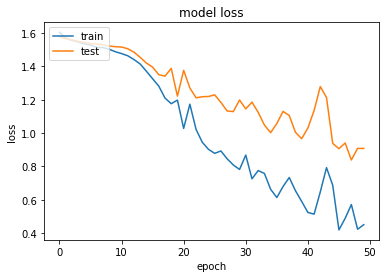

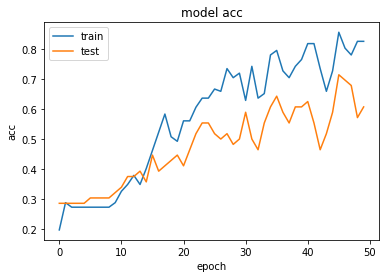

1/2 [==============>...............] - ETA: 0s - loss: 0.9057 - acc: 0.5938

2/2 [==============================] - 0s 18ms/step - loss: 0.9081 - acc: 0.6071


Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_111 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_164 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_98 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_53 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_165 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6055 - acc: 0.2500 - val_loss: 1.5770 - val_acc: 0.3214


Epoch 2/50
2/2 - 0s - loss: 1.5733 - acc: 0.2955 - val_loss: 1.5582 - val_acc: 0.3214


Epoch 3/50


2/2 - 0s - loss: 1.5566 - acc: 0.2955 - val_loss: 1.5568 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5524 - acc: 0.2879 - val_loss: 1.5613 - val_acc: 0.3214


Epoch 5/50
2/2 - 0s - loss: 1.5542 - acc: 0.2803 - val_loss: 1.5622 - val_acc: 0.3214


Epoch 6/50
2/2 - 0s - loss: 1.5476 - acc: 0.3106 - val_loss: 1.5594 - val_acc: 0.3214


Epoch 7/50
2/2 - 0s - loss: 1.5433 - acc: 0.2955 - val_loss: 1.5533 - val_acc: 0.3214


Epoch 8/50
2/2 - 0s - loss: 1.5347 - acc: 0.3030 - val_loss: 1.5460 - val_acc: 0.3214


Epoch 9/50
2/2 - 0s - loss: 1.5278 - acc: 0.3258 - val_loss: 1.5362 - val_acc: 0.3929


Epoch 10/50


2/2 - 0s - loss: 1.4972 - acc: 0.4318 - val_loss: 1.5224 - val_acc: 0.3929


Epoch 11/50


2/2 - 0s - loss: 1.4824 - acc: 0.4697 - val_loss: 1.4989 - val_acc: 0.4464


Epoch 12/50


2/2 - 0s - loss: 1.4469 - acc: 0.4773 - val_loss: 1.4638 - val_acc: 0.4286


Epoch 13/50


2/2 - 0s - loss: 1.3985 - acc: 0.4242 - val_loss: 1.4185 - val_acc: 0.4464


Epoch 14/50
2/2 - 0s - loss: 1.3345 - acc: 0.4318 - val_loss: 1.3773 - val_acc: 0.3929


Epoch 15/50


2/2 - 0s - loss: 1.3012 - acc: 0.4924 - val_loss: 1.3311 - val_acc: 0.4286


Epoch 16/50


2/2 - 0s - loss: 1.2527 - acc: 0.5227 - val_loss: 1.3556 - val_acc: 0.4286


Epoch 17/50


2/2 - 0s - loss: 1.2535 - acc: 0.5076 - val_loss: 1.3426 - val_acc: 0.3750


Epoch 18/50
2/2 - 0s - loss: 1.2050 - acc: 0.5758 - val_loss: 1.3146 - val_acc: 0.4107


Epoch 19/50
2/2 - 0s - loss: 1.1498 - acc: 0.5606 - val_loss: 1.3161 - val_acc: 0.4821


Epoch 20/50


2/2 - 0s - loss: 1.1326 - acc: 0.5152 - val_loss: 1.3436 - val_acc: 0.4464


Epoch 21/50


2/2 - 0s - loss: 1.1448 - acc: 0.4773 - val_loss: 1.2321 - val_acc: 0.5179


Epoch 22/50


2/2 - 0s - loss: 1.0169 - acc: 0.5985 - val_loss: 1.2143 - val_acc: 0.4286


Epoch 23/50
2/2 - 0s - loss: 0.9465 - acc: 0.7348 - val_loss: 1.2068 - val_acc: 0.4464


Epoch 24/50
2/2 - 0s - loss: 0.9034 - acc: 0.7273 - val_loss: 1.2195 - val_acc: 0.4821


Epoch 25/50


2/2 - 0s - loss: 0.8395 - acc: 0.7045 - val_loss: 1.3228 - val_acc: 0.4464


Epoch 26/50
2/2 - 0s - loss: 0.8538 - acc: 0.6970 - val_loss: 1.3010 - val_acc: 0.4821


Epoch 27/50


2/2 - 0s - loss: 0.7765 - acc: 0.7500 - val_loss: 1.2269 - val_acc: 0.4643


Epoch 28/50


2/2 - 0s - loss: 0.7065 - acc: 0.7500 - val_loss: 1.2485 - val_acc: 0.4286


Epoch 29/50


2/2 - 0s - loss: 0.7975 - acc: 0.6894 - val_loss: 1.2385 - val_acc: 0.4286


Epoch 30/50


2/2 - 0s - loss: 0.8151 - acc: 0.6818 - val_loss: 1.1195 - val_acc: 0.5000


Epoch 31/50
2/2 - 0s - loss: 0.7369 - acc: 0.7348 - val_loss: 1.0247 - val_acc: 0.5536


Epoch 32/50
2/2 - 0s - loss: 0.6124 - acc: 0.7879 - val_loss: 0.9965 - val_acc: 0.6071


Epoch 33/50


2/2 - 0s - loss: 0.5632 - acc: 0.8106 - val_loss: 0.9875 - val_acc: 0.5893


Epoch 34/50


2/2 - 0s - loss: 0.5495 - acc: 0.8333 - val_loss: 0.9364 - val_acc: 0.5893


Epoch 35/50


2/2 - 0s - loss: 0.4914 - acc: 0.8409 - val_loss: 0.9412 - val_acc: 0.5536


Epoch 36/50


2/2 - 0s - loss: 0.4721 - acc: 0.8333 - val_loss: 0.9978 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.5356 - acc: 0.8030 - val_loss: 1.0765 - val_acc: 0.5714


Epoch 38/50


2/2 - 0s - loss: 0.5860 - acc: 0.7500 - val_loss: 0.9318 - val_acc: 0.5893


Epoch 39/50


2/2 - 0s - loss: 0.4241 - acc: 0.8636 - val_loss: 1.0010 - val_acc: 0.6786


Epoch 40/50


2/2 - 0s - loss: 0.4314 - acc: 0.8561 - val_loss: 0.9004 - val_acc: 0.6071


Epoch 41/50


2/2 - 0s - loss: 0.3791 - acc: 0.8864 - val_loss: 1.2746 - val_acc: 0.5000


Epoch 42/50


2/2 - 0s - loss: 0.7711 - acc: 0.7348 - val_loss: 1.3533 - val_acc: 0.5000


Epoch 43/50


2/2 - 0s - loss: 0.8643 - acc: 0.6970 - val_loss: 1.0769 - val_acc: 0.5893


Epoch 44/50
2/2 - 0s - loss: 0.5322 - acc: 0.8409 - val_loss: 1.0258 - val_acc: 0.5893


Epoch 45/50


2/2 - 0s - loss: 0.4524 - acc: 0.8182 - val_loss: 1.5338 - val_acc: 0.5000


Epoch 46/50


2/2 - 0s - loss: 0.6904 - acc: 0.7348 - val_loss: 1.4752 - val_acc: 0.5179


Epoch 47/50


2/2 - 0s - loss: 0.6778 - acc: 0.7727 - val_loss: 1.0855 - val_acc: 0.6071


Epoch 48/50


2/2 - 0s - loss: 0.4457 - acc: 0.8409 - val_loss: 0.9864 - val_acc: 0.5893


Epoch 49/50


2/2 - 0s - loss: 0.3775 - acc: 0.8561 - val_loss: 0.9763 - val_acc: 0.5536


Epoch 50/50


2/2 - 0s - loss: 0.3544 - acc: 0.8788 - val_loss: 1.0478 - val_acc: 0.5893


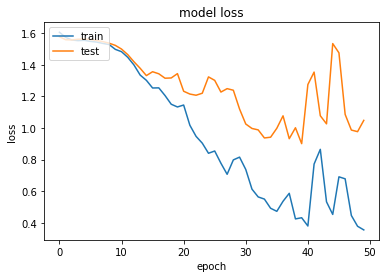

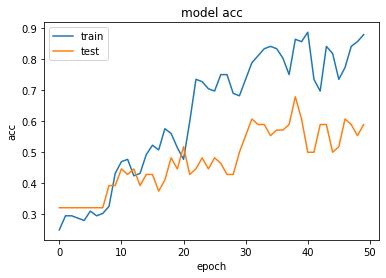

1/2 [==============>...............] - ETA: 0s - loss: 0.9816 - acc: 0.5938

2/2 [==============================] - 0s 19ms/step - loss: 1.0478 - acc: 0.5893


Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_113 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_166 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_54 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_167 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6096 - acc: 0.1515 - val_loss: 1.5887 - val_acc: 0.2500


Epoch 2/50
2/2 - 0s - loss: 1.5794 - acc: 0.3182 - val_loss: 1.5679 - val_acc: 0.4464


Epoch 3/50


2/2 - 0s - loss: 1.5528 - acc: 0.3182 - val_loss: 1.5474 - val_acc: 0.3214


Epoch 4/50
2/2 - 0s - loss: 1.5289 - acc: 0.3106 - val_loss: 1.5412 - val_acc: 0.2857


Epoch 5/50
2/2 - 0s - loss: 1.5232 - acc: 0.2727 - val_loss: 1.5694 - val_acc: 0.2857


Epoch 6/50


2/2 - 0s - loss: 1.5513 - acc: 0.2727 - val_loss: 1.5695 - val_acc: 0.2857


Epoch 7/50


2/2 - 0s - loss: 1.5408 - acc: 0.2727 - val_loss: 1.5510 - val_acc: 0.2857


Epoch 8/50


2/2 - 0s - loss: 1.5133 - acc: 0.2727 - val_loss: 1.5398 - val_acc: 0.2857


Epoch 9/50


2/2 - 0s - loss: 1.4995 - acc: 0.2803 - val_loss: 1.5338 - val_acc: 0.2857


Epoch 10/50
2/2 - 0s - loss: 1.4859 - acc: 0.2955 - val_loss: 1.5236 - val_acc: 0.3036


Epoch 11/50
2/2 - 0s - loss: 1.4732 - acc: 0.3106 - val_loss: 1.5112 - val_acc: 0.3036


Epoch 12/50


2/2 - 0s - loss: 1.4436 - acc: 0.3636 - val_loss: 1.4982 - val_acc: 0.3571


Epoch 13/50


2/2 - 0s - loss: 1.4306 - acc: 0.4015 - val_loss: 1.4771 - val_acc: 0.3571


Epoch 14/50


2/2 - 0s - loss: 1.3742 - acc: 0.4470 - val_loss: 1.4484 - val_acc: 0.3214


Epoch 15/50


2/2 - 0s - loss: 1.3297 - acc: 0.4394 - val_loss: 1.4124 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.2730 - acc: 0.4697 - val_loss: 1.3726 - val_acc: 0.3929


Epoch 17/50


2/2 - 0s - loss: 1.2025 - acc: 0.4773 - val_loss: 1.3297 - val_acc: 0.4286


Epoch 18/50


2/2 - 0s - loss: 1.1276 - acc: 0.4697 - val_loss: 1.2639 - val_acc: 0.5357


Epoch 19/50
2/2 - 0s - loss: 1.0320 - acc: 0.5985 - val_loss: 1.4009 - val_acc: 0.4643


Epoch 20/50


2/2 - 0s - loss: 1.1505 - acc: 0.5606 - val_loss: 1.4417 - val_acc: 0.4286


Epoch 21/50


2/2 - 0s - loss: 1.2088 - acc: 0.5227 - val_loss: 1.2575 - val_acc: 0.5714


Epoch 22/50


2/2 - 0s - loss: 0.9822 - acc: 0.6061 - val_loss: 1.1974 - val_acc: 0.5893


Epoch 23/50


2/2 - 0s - loss: 0.8955 - acc: 0.6667 - val_loss: 1.2139 - val_acc: 0.5000


Epoch 24/50


2/2 - 0s - loss: 0.9048 - acc: 0.6439 - val_loss: 1.2376 - val_acc: 0.5536


Epoch 25/50


2/2 - 0s - loss: 0.9116 - acc: 0.6212 - val_loss: 1.2058 - val_acc: 0.5357


Epoch 26/50

2/2 - 0s - loss: 0.8516 - acc: 0.6742 - val_loss: 1.1599 - val_acc: 0.5893


Epoch 27/50


2/2 - 0s - loss: 0.7578 - acc: 0.7121 - val_loss: 1.1398 - val_acc: 0.5893


Epoch 28/50


2/2 - 0s - loss: 0.7715 - acc: 0.7121 - val_loss: 1.1695 - val_acc: 0.5893


Epoch 29/50


2/2 - 0s - loss: 0.8603 - acc: 0.6288 - val_loss: 1.2245 - val_acc: 0.5536


Epoch 30/50


2/2 - 0s - loss: 0.8951 - acc: 0.5833 - val_loss: 1.1574 - val_acc: 0.5536


Epoch 31/50


2/2 - 0s - loss: 0.8054 - acc: 0.6439 - val_loss: 1.1054 - val_acc: 0.5893


Epoch 32/50


2/2 - 0s - loss: 0.7330 - acc: 0.7348 - val_loss: 1.2300 - val_acc: 0.5536


Epoch 33/50


2/2 - 0s - loss: 0.9234 - acc: 0.6515 - val_loss: 1.3022 - val_acc: 0.5179


Epoch 34/50


2/2 - 0s - loss: 1.0187 - acc: 0.5682 - val_loss: 1.1663 - val_acc: 0.5714


Epoch 35/50


2/2 - 0s - loss: 0.8328 - acc: 0.6212 - val_loss: 1.0974 - val_acc: 0.5714


Epoch 36/50


2/2 - 0s - loss: 0.7105 - acc: 0.7197 - val_loss: 1.0907 - val_acc: 0.5714


Epoch 37/50


2/2 - 0s - loss: 0.7155 - acc: 0.6818 - val_loss: 1.0290 - val_acc: 0.5893


Epoch 38/50
2/2 - 0s - loss: 0.6848 - acc: 0.7045 - val_loss: 1.0233 - val_acc: 0.6071


Epoch 39/50
2/2 - 0s - loss: 0.7314 - acc: 0.6742 - val_loss: 1.0072 - val_acc: 0.6071


Epoch 40/50


2/2 - 0s - loss: 0.7320 - acc: 0.6894 - val_loss: 0.9665 - val_acc: 0.6429


Epoch 41/50


2/2 - 0s - loss: 0.6564 - acc: 0.7955 - val_loss: 0.9686 - val_acc: 0.6071


Epoch 42/50


2/2 - 0s - loss: 0.6163 - acc: 0.7500 - val_loss: 0.9986 - val_acc: 0.6607


Epoch 43/50


2/2 - 0s - loss: 0.6091 - acc: 0.7576 - val_loss: 1.0165 - val_acc: 0.5893


Epoch 44/50

2/2 - 0s - loss: 0.5546 - acc: 0.7955 - val_loss: 1.0456 - val_acc: 0.6250


Epoch 45/50


2/2 - 0s - loss: 0.5491 - acc: 0.8333 - val_loss: 1.0620 - val_acc: 0.6071


Epoch 46/50


2/2 - 0s - loss: 0.5261 - acc: 0.8182 - val_loss: 1.0636 - val_acc: 0.6071


Epoch 47/50


2/2 - 0s - loss: 0.5067 - acc: 0.8182 - val_loss: 1.1307 - val_acc: 0.6071


Epoch 48/50


2/2 - 0s - loss: 0.4951 - acc: 0.7500 - val_loss: 1.1863 - val_acc: 0.6429


Epoch 49/50


2/2 - 0s - loss: 0.5168 - acc: 0.8030 - val_loss: 1.1901 - val_acc: 0.6250


Epoch 50/50


2/2 - 0s - loss: 0.4580 - acc: 0.8485 - val_loss: 1.2034 - val_acc: 0.6429


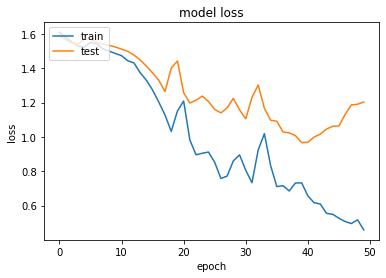

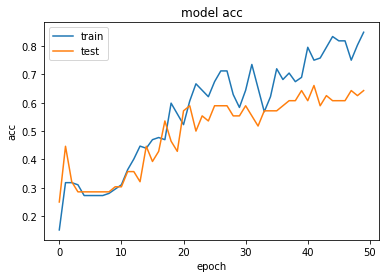

1/2 [==============>...............] - ETA: 0s - loss: 1.1141 - acc: 0.5938

2/2 [==============================] - 0s 17ms/step - loss: 1.2034 - acc: 0.6429


Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         26400     
_________________________________________________________________
lstm_115 (LSTM)              (None, None, 128)         117248    
_________________________________________________________________
dropout_168 (Dropout)        (None, None, 128)         0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, None, 128)         82048     
_________________________________________________________________
average_pooling1d_55 (Averag (None, None, 128)         0         
_________________________________________________________________
dropout_169 (Dropout)        (None, None, 128)         0  

2/2 - 3s - loss: 1.6106 - acc: 0.1667 - val_loss: 1.5866 - val_acc: 0.3036


Epoch 2/50
2/2 - 0s - loss: 1.5812 - acc: 0.2879 - val_loss: 1.5651 - val_acc: 0.3036


Epoch 3/50


2/2 - 0s - loss: 1.5512 - acc: 0.2955 - val_loss: 1.5496 - val_acc: 0.3036


Epoch 4/50
2/2 - 0s - loss: 1.5409 - acc: 0.2803 - val_loss: 1.5434 - val_acc: 0.3036


Epoch 5/50


2/2 - 0s - loss: 1.5225 - acc: 0.2879 - val_loss: 1.5298 - val_acc: 0.3393


Epoch 6/50
2/2 - 0s - loss: 1.5101 - acc: 0.3788 - val_loss: 1.5298 - val_acc: 0.3214


Epoch 7/50
2/2 - 0s - loss: 1.5060 - acc: 0.3485 - val_loss: 1.5295 - val_acc: 0.3214


Epoch 8/50
2/2 - 0s - loss: 1.4988 - acc: 0.3106 - val_loss: 1.5226 - val_acc: 0.3214


Epoch 9/50
2/2 - 0s - loss: 1.4923 - acc: 0.3106 - val_loss: 1.5111 - val_acc: 0.3750


Epoch 10/50
2/2 - 0s - loss: 1.4598 - acc: 0.4545 - val_loss: 1.4941 - val_acc: 0.3393


Epoch 11/50


2/2 - 0s - loss: 1.4367 - acc: 0.4545 - val_loss: 1.4655 - val_acc: 0.3571


Epoch 12/50


2/2 - 0s - loss: 1.3939 - acc: 0.4394 - val_loss: 1.4299 - val_acc: 0.3750


Epoch 13/50


2/2 - 0s - loss: 1.3527 - acc: 0.4848 - val_loss: 1.4312 - val_acc: 0.4107


Epoch 14/50


2/2 - 0s - loss: 1.3494 - acc: 0.4318 - val_loss: 1.4198 - val_acc: 0.3750


Epoch 15/50


2/2 - 0s - loss: 1.3239 - acc: 0.5227 - val_loss: 1.3669 - val_acc: 0.4464


Epoch 16/50


2/2 - 0s - loss: 1.2578 - acc: 0.5758 - val_loss: 1.3360 - val_acc: 0.4464


Epoch 17/50
2/2 - 0s - loss: 1.2077 - acc: 0.6515 - val_loss: 1.3074 - val_acc: 0.4643


Epoch 18/50
2/2 - 0s - loss: 1.1790 - acc: 0.5909 - val_loss: 1.2609 - val_acc: 0.4821


Epoch 19/50


2/2 - 0s - loss: 1.1064 - acc: 0.5455 - val_loss: 1.2410 - val_acc: 0.4821


Epoch 20/50


2/2 - 0s - loss: 1.0511 - acc: 0.5833 - val_loss: 1.2375 - val_acc: 0.4643


Epoch 21/50


2/2 - 0s - loss: 1.0142 - acc: 0.6061 - val_loss: 1.2486 - val_acc: 0.4821


Epoch 22/50


2/2 - 0s - loss: 0.9527 - acc: 0.6212 - val_loss: 1.3384 - val_acc: 0.4821


Epoch 23/50


2/2 - 0s - loss: 1.0601 - acc: 0.5682 - val_loss: 1.3416 - val_acc: 0.4821


Epoch 24/50


2/2 - 0s - loss: 1.0693 - acc: 0.5833 - val_loss: 1.2503 - val_acc: 0.4643


Epoch 25/50
2/2 - 0s - loss: 0.9052 - acc: 0.6818 - val_loss: 1.3154 - val_acc: 0.4286


Epoch 26/50


2/2 - 0s - loss: 0.9478 - acc: 0.6288 - val_loss: 1.2866 - val_acc: 0.4464


Epoch 27/50


2/2 - 0s - loss: 0.9039 - acc: 0.6742 - val_loss: 1.2094 - val_acc: 0.5179


Epoch 28/50


2/2 - 0s - loss: 0.8227 - acc: 0.6818 - val_loss: 1.1725 - val_acc: 0.5714


Epoch 29/50
2/2 - 0s - loss: 0.7714 - acc: 0.7197 - val_loss: 1.2021 - val_acc: 0.4643


Epoch 30/50


2/2 - 0s - loss: 0.7828 - acc: 0.6742 - val_loss: 1.1755 - val_acc: 0.5000


Epoch 31/50


2/2 - 0s - loss: 0.7480 - acc: 0.6970 - val_loss: 1.1590 - val_acc: 0.5179


Epoch 32/50


2/2 - 0s - loss: 0.7122 - acc: 0.7424 - val_loss: 1.2357 - val_acc: 0.5179


Epoch 33/50


2/2 - 0s - loss: 0.7718 - acc: 0.7500 - val_loss: 1.2925 - val_acc: 0.4643


Epoch 34/50


2/2 - 0s - loss: 0.7716 - acc: 0.6970 - val_loss: 1.3561 - val_acc: 0.4464


Epoch 35/50


2/2 - 0s - loss: 0.7704 - acc: 0.6667 - val_loss: 1.2660 - val_acc: 0.5000


Epoch 36/50


2/2 - 0s - loss: 0.6785 - acc: 0.6970 - val_loss: 1.2133 - val_acc: 0.5179


Epoch 37/50


2/2 - 0s - loss: 0.6008 - acc: 0.7424 - val_loss: 1.3337 - val_acc: 0.5714


Epoch 38/50


2/2 - 0s - loss: 0.6946 - acc: 0.7424 - val_loss: 1.3148 - val_acc: 0.5893


Epoch 39/50


2/2 - 0s - loss: 0.6584 - acc: 0.7652 - val_loss: 1.0601 - val_acc: 0.5179


Epoch 40/50


2/2 - 0s - loss: 0.5443 - acc: 0.8106 - val_loss: 0.9591 - val_acc: 0.5893


Epoch 41/50


2/2 - 0s - loss: 0.5254 - acc: 0.7879 - val_loss: 0.9439 - val_acc: 0.6071


Epoch 42/50


2/2 - 0s - loss: 0.5302 - acc: 0.7652 - val_loss: 0.9234 - val_acc: 0.5893


Epoch 43/50


2/2 - 0s - loss: 0.4946 - acc: 0.8106 - val_loss: 0.9331 - val_acc: 0.5893


Epoch 44/50


2/2 - 0s - loss: 0.4714 - acc: 0.8712 - val_loss: 0.9860 - val_acc: 0.5714


Epoch 45/50


2/2 - 0s - loss: 0.4722 - acc: 0.8182 - val_loss: 1.0182 - val_acc: 0.6071


Epoch 46/50


2/2 - 0s - loss: 0.4621 - acc: 0.8485 - val_loss: 0.9910 - val_acc: 0.6071


Epoch 47/50


2/2 - 0s - loss: 0.4253 - acc: 0.8485 - val_loss: 0.9227 - val_acc: 0.6071


Epoch 48/50


2/2 - 0s - loss: 0.4278 - acc: 0.8636 - val_loss: 0.9689 - val_acc: 0.6071


Epoch 49/50


2/2 - 0s - loss: 0.4654 - acc: 0.8409 - val_loss: 0.9579 - val_acc: 0.6250


Epoch 50/50


2/2 - 0s - loss: 0.3463 - acc: 0.8939 - val_loss: 1.2129 - val_acc: 0.5893


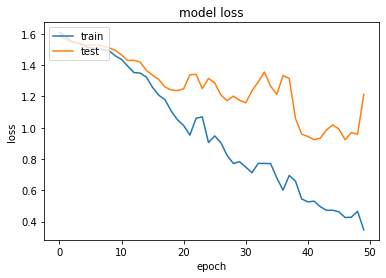

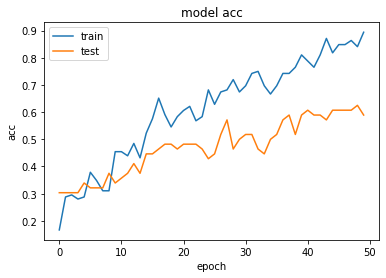

1/2 [==============>...............] - ETA: 0s - loss: 0.9824 - acc: 0.6562

2/2 [==============================] - 0s 17ms/step - loss: 1.2129 - acc: 0.5893


In [114]:
acc = 0
attemps = 20

while acc <= 0.75 and attemps>0 :
    int_sequences_input = tf.keras.layers.Input(shape=(None,), dtype="int64")
    embedded_sequences = embedding_layer(int_sequences_input)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(embedded_sequences)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv1D(128, 5, activation="relu",
                               padding="same")(x)
    x = tf.keras.layers.AveragePooling1D(5)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.Conv1D(128, 5, activation="relu", 
    #                            padding="same")(x)
    # x = tf.keras.layers.AveragePooling1D(5)(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    preds = tf.keras.layers.Dense(5, activation="softmax")(x)
    model = tf.keras.Model(int_sequences_input, preds)
    model.summary()
    
    model.compile("Adam", "categorical_crossentropy", metrics=["acc"])
    
    hist = model.fit(train_x, train_y, epochs=50, batch_size=128,
                     validation_data=(test_x, test_y), verbose=2)
    
    plot_hist(hist)
    
    model.evaluate(test_x, test_y, verbose=1)
    acc = hist.history.get("val_acc")[-1]
    attemps -= 1
    
model.save('glove_model.h5')

0.5357142686843872
